# Todo

# Setup

## Ingest and functions

In [1]:
%%capture

###############################################
###############################################
# Setup
# This chuck ingests pre-computed variables
###############################################
###############################################

# [Shift + Return] to run chunks 

###############################################

# settings
wkdir, s3dir = '/home/ubuntu/data/DL20181011_melanocyte_test_data', 'daniel.le-work/MEL_project'

%reload_ext autoreload
%autoreload 2
from scanpy_helpers_1 import *
from scanpy_helpers_2 import *
warnings.filterwarnings('ignore')
%matplotlib inline

# import data from s3
for file in ['raw_adata', 'full_adata',
             'recluster_0','recluster_1','DE_df',
             'diff_2step_df', 'fet_v_adt_df', 'acr_v_cut_df', 'adt_v_fet_DE','target_v_fol_df',
             'ensembl2symbol_dict'
            ]:
#     ! aws s3 cp s3://{s3dir}/{file}.p {wkdir}/
    var = pickle.load((open(f'{wkdir}/{file}.p', 'rb')))
    exec(f'{file} = var')
    del var
    
usable_cores = multiprocessing.cpu_count()-1



In [2]:
# update subtypes
full_adata.obs['subtypes'] = ['follicular' if x in ['light_foll_mel', 'dark_foll_mel', 'cyc_foll_mel'] \
                         else y \
                         for x,y in zip(full_adata.obs.class_1, full_adata.obs.subtypes)]

# label order
dev_stage_order = ['fet','neo','adt']
subtypes_order = ['cutaneous','acral','foreskin','follicular']
acral_subtype_order = ['acral','not_acral']
foreskin_subtype_order = ['foreskin','not_foreskin']
follicular_subtype_order = ['follicular','not_follicular']
dev_subtype_order = ['fet_acral','fet_cutaneous','fet_follicular','neo_foreskin','adt_acral','adt_cutaneous']

# create class_2 for site granularity
full_adata.obs['class_2'] = [x if x not in ['mel'] \
                             else f'{y}_mel'
                             for x,y in zip(full_adata.obs['class_1'], full_adata.obs['subtypes'])]

# create class_3 for site+dev_stage granularity
full_adata.obs['class_3'] = [x if not x.endswith('_mel') or x.startswith('cyc_') \
                             else f'{y}_{x}'
                             for x,y in zip(full_adata.obs['class_2'], full_adata.obs['dev_stage'])]

# update class_1 to pool by cell type
full_adata.obs['class_1'] = [x if not x.endswith('_mel') \
                             else 'mel' if not x.startswith('cyc_') \
                             else 'cyc_mel' \
                             for x in full_adata.obs['class_1']]
type_order_1 = ['mel',
                'cyc_mel',
                'krt',
                'cyc_krt',
                'eccrine',
                'cyc_eccrine',
                'dendritic',
                'cyc_dendritic',
                'mast',
                'T_cell',]
    
DE_df['class_1'] = (DE_df['class_1']
                      .astype(str)
                      .astype(CategoricalDtype(type_order_1, ordered=True))
                     )
DE_df = DE_df.dropna()

type_order_2 = ['cutaneous_mel',
                'acral_mel',
                'foreskin_mel',
                'dark_foll_mel',
                'light_foll_mel',
                'cyc_mel',
                'cyc_foll_mel',
                'krt',
                'cyc_krt',
                'eccrine',
                'cyc_eccrine',
                'dendritic',
                'cyc_dendritic',
                'mast',
                'T_cell',]

type_order_3 = ['adt_cutaneous_mel',
                'adt_acral_mel',
                'neo_foreskin_mel',
                'fet_cutaneous_mel',
                'fet_acral_mel',
                'fet_dark_foll_mel',
                'fet_light_foll_mel',
                'cyc_mel',
                'cyc_foll_mel',
                'krt',
                'cyc_krt',
                'eccrine',
                'cyc_eccrine',
                'dendritic',
                'cyc_dendritic',
                'mast',
                'T_cell',]


# Figure 1: Overview

## Gene module UMAPs

### UMAP

In [ ]:
print('computing...')

plot_dict = {'class_1':type_order_1,
             'class_2':type_order_2,
             'class_3':type_order_3
            }

for key,value in plot_dict.items():

    class_ref = key
    type_order_ref = value

    input_adata = full_adata[[not x.startswith('cyc_') for x in full_adata.obs[class_ref]]]
    umap_df = pd.DataFrame(input_adata.obsm['X_umap'], columns = ['xvar','yvar'])
    umap_df[class_ref] = input_adata.obs[class_ref].values
    umap_df[class_ref] = (umap_df[class_ref]
                          .astype(str)
                          .astype(CategoricalDtype([x for x in type_order_ref \
                                                    if not x.startswith('cyc_')], ordered=True))
                         )

    plotnine.options.figure_size = (4,4)
    plot = (ggplot(umap_df)
            + theme_bw()
            + theme(aspect_ratio = 1)
            + geom_point(aes('xvar','yvar',color=class_ref), size = 0.1)
           )
    print(plot)


### supplemental: cycling cells analysis

#### all cells label by dev stage

In [ ]:
input_adata = full_adata

counts_df = (pd.DataFrame(input_adata
                         .obs
                         .reset_index()
                         .groupby(['dev_stage','class_1'])['index']
                         .count())
             .reset_index()
            )

counts_df['fraction'] = counts_df.groupby('dev_stage')['index'].apply(lambda x: x/sum(x))
counts_df['dev_stage'] = (counts_df['dev_stage']
                          .astype(str)
                          .astype(CategoricalDtype(['fet','neo','adt'], 
                                                   ordered=True)))
counts_df['class_1'] = (counts_df['class_1']
                      .astype(str)
                      .astype(CategoricalDtype(type_order_1, ordered=True))
                     )

plotnine.options.figure_size = (6,6)
print(ggplot(counts_df)
      + theme_bw()
      + theme(axis_text_x = element_text(angle = 90),
              aspect_ratio = 1,
              panel_spacing_x = 0.6
             )
      + geom_bar(aes('dev_stage','fraction',fill='class_1'), stat='identity')
      + facet_wrap('~class_1', scales = 'free_y', ncol = 3)
     )


#### cycling vs non-cycling MEL by dev stage or true age

In [ ]:
mel_counts = counts_df[[x == 'mel' or x == 'cyc_mel' for x in counts_df['class_1']]]
mel_counts['fraction'] = mel_counts.groupby('dev_stage')['index'].apply(lambda x: x/sum(x))

plotnine.options.figure_size = (4,4)
print(ggplot(mel_counts)
      + theme_bw()
      + theme(axis_text_x = element_text(angle = 90),
              aspect_ratio = 1,
              panel_spacing_x = 0.5,
              legend_position = 'none'
             )
      + geom_bar(aes('dev_stage','fraction',fill='class_1'), stat='identity')
      + facet_wrap('~class_1', scales = 'free_y', ncol = 3)
     )

input_adata = full_adata
plot_df = input_adata.obs.loc[:,['class_1','true_year','patient']]
plot_df = plot_df[[x == 'cyc_mel' or x == 'mel' for x in plot_df['class_1']]]
plot_df['class_1'] = plot_df['class_1'].astype(str)
plot_df['patient'] = plot_df['patient'].astype(str)

plot_df = pd.pivot_table(plot_df.groupby(['true_year','class_1']).count().dropna().reset_index(), 
               values = 'patient', 
               index='true_year', 
               columns = 'class_1')
plot_df['fraction'] = plot_df.cyc_mel/plot_df.mel
plot_df = plot_df.fillna(0).reset_index()

plotnine.options.figure_size = (2,2)
print(ggplot(plot_df)
      + theme_bw()
      + geom_line(aes('true_year','fraction'))
      + geom_point(aes('true_year','fraction'))
      + scale_x_log10()
     )

#### cycling MEL vs cycling KRT DE genes

In [ ]:
# gene_n = 15
# input_adata = full_adata[full_adata.obs.dev_stage == 'fet']
# clusterOI = 'cyc_mel'
# reference= 'cyc_krt'  #'rest'
# groupby = 'class_1'

# sc.tl.rank_genes_groups(input_adata, groupby=groupby, groups=[clusterOI], method='wilcoxon',reference=reference)
# gene = [x[0] for x in input_adata.uns['rank_genes_groups']['names']]
# out = symbol2field(gene[:gene_n])
# output = [print(f'{idx}: ', 
#        x['query'],
#        '\n',x['summary']) if ('summary' in x.keys()) else print(f'{idx}: ', 
#                                                                 x['query'],
#                                                                 '\n','N/A') for idx, x in enumerate(out)]


### supplemental: gate assignments

In [ ]:
input_adata = full_adata

gate_df = pd.DataFrame(input_adata
             .obs
             .loc[:,['gate_label', 'class_1']]
             .groupby('class_1')['gate_label']
             .value_counts()
            )
          
gate_df = gate_df/gate_df.groupby(level=0).sum()
gate_df = (gate_df
             .rename(columns={'gate_label':'group_prop'})
             .reset_index() 
            )
gate_df['gate_label'] = (gate_df['gate_label']
                                 .astype(str)
                                 .astype(CategoricalDtype(['a6high', 'a6mid', 'a6low', 'ckitpos', 'null'],ordered=True))
                                )
gate_df['class_1'] = (gate_df['class_1']
                      .astype(str)
                      .astype(CategoricalDtype(type_order_1, ordered=True))
                     )

plotnine.options.figure_size = (3,3)
plot = (ggplot(gate_df)
        + theme_bw()
        + theme(axis_text_x = element_text(angle = 90))
        + geom_bar(aes('class_1','group_prop',fill='gate_label'),stat='identity')
        + labs(x='',y='proportion')
       )
plot


### (decommissioned) Supplemental: 2-feature scatter

In [ ]:
# # input_adata = full_adata # all cells
# input_adata = full_adata # mels only

# feat1 = 'NTRK2'
# feat2 = 'true_year'
# groupby = 'dev_subtype'
# alpha = 0.5
# print_metadata_fields = False

# if print_metadata_fields == True:
#     print('possible metadata or grouping features:\n')
#     print(input_adata.obs.columns)
# else:
#     gene = []
#     meta = []
#     tmpdf = pd.DataFrame()

#     for feat in [feat1, feat2]:
#         if feat in input_adata.var_names:
#             cat, exp_df = prepare_dataframe(input_adata,
#                      var_names = feat,
#                      groupby = groupby)
#             tmpdf[feat] = exp_df[feat].values
#         elif feat in input_adata.obs.columns:
#             tmpdf[feat] = input_adata.obs[feat].values

#     tmpdf[groupby] = input_adata.obs[groupby].values

#     plotnine.options.figure_size = (4,4)
#     plot = (ggplot(tmpdf)
#             + theme_bw()
#             + theme(aspect_ratio = 1)
#             + geom_point(aes(feat1, feat2, color = groupby), alpha = alpha)
#            )

#     print(plot)

#     plotnine.options.figure_size = (5,5)
#     plot = (ggplot(pd.melt(tmpdf, id_vars=groupby))
#             + theme_bw()
#             + theme(aspect_ratio = 1,
#                     panel_spacing = 0.4
#                    )
#             + geom_histogram(aes('value', fill = 'variable'), position='dodge')
#             + facet_grid(f'{groupby}~variable', scales = 'free')
#            )

#     print(plot)


## Gene module heatmaps

### cell type by gene module heatmap

In [ ]:
print('computing...')
input_adata = full_adata
n_cells = 100

# extract cell types and genes order
type_order = DE_df.class_1.cat.categories.tolist()
gene_order = []
for x in type_order:
    df_slice = DE_df[DE_df.class_1 == x]
    df_slice = df_slice[~df_slice.gene.duplicated(keep='first')]
    gene_order = gene_order + [x for x in df_slice.gene if x not in gene_order]


cat, exp_df = prepare_dataframe(input_adata,
                 var_names = gene_order,
                 groupby = 'cell')

exp_df = exp_df.apply(lambda x: min_max_scaler(np.log1p(x).values))
exp_df['class_1'] = input_adata.obs.class_1.tolist()

compiled_rows = pd.DataFrame()
type_order_revised = []
for x in type_order:
    df_slice = exp_df[exp_df.class_1 == x]
    df_nrow = len(df_slice)
    if df_nrow >= n_cells:
        df_sample = df_slice.sample(n_cells)
        num_cell = n_cells
    else:
        df_sample = df_slice
        num_cell = df_nrow
    df_sample['idx'] = [x for x in range(len(df_sample))]
    df_sample['class_1'] = f'{x} ({num_cell}/{df_nrow})'
    type_order_revised = type_order_revised + [f'{x} ({num_cell}/{df_nrow})']
    compiled_rows = compiled_rows.append(df_sample)
    
compiled_rows_melt = pd.melt(compiled_rows, id_vars=['class_1','idx'])
compiled_rows_melt['class_1'] = (compiled_rows_melt['class_1']
                                 .astype(str)
                                 .astype(CategoricalDtype(type_order_revised,
                                                          ordered=True
                                                         )
                                        )
                                )
compiled_rows_melt['variable'] = (compiled_rows_melt['variable']
                                 .astype(str)
                                 .astype(CategoricalDtype(gene_order,
                                                          ordered=True
                                                         )
                                        )
                                )

plotnine.options.figure_size = (14,14)
plot = (ggplot(compiled_rows_melt)
      + theme_bw()
      + theme(axis_text_x = element_blank(),
              strip_text_x = element_text(angle = 90, vjust = 0),
              strip_background_x = element_rect(fill = 'white', color = 'white') )
      + geom_tile(aes('idx','variable',fill='value'))
      + facet_grid('~class_1', scales='free')
      + scale_fill_cmap('magma')
      + labs(x = '', y = ''))

print(plot)

plot_df = compiled_rows_melt[[not x.startswith('cyc_') for x in compiled_rows_melt.class_1]]
gene_order_trimmed = DE_df[[not x.startswith('cyc_') for x in DE_df.class_1]].gene.tolist()
plot_df = plot_df[[x in gene_order_trimmed for x in plot_df.variable]]

plotnine.options.figure_size = (7.5,7.5)
plot = (ggplot(plot_df)
      + theme_bw()
      + theme(axis_text_x = element_blank(),
              strip_text_x = element_text(angle = 90, vjust = 0),
              strip_background_x = element_rect(fill = 'white', color = 'white') )
      + geom_tile(aes('idx','variable',fill='value'))
      + facet_grid('~class_1', scales='free')
      + scale_fill_cmap('magma')
      + labs(x = '', y = ''))

print(plot)


### supplemental: MEL-only recluster

computing...


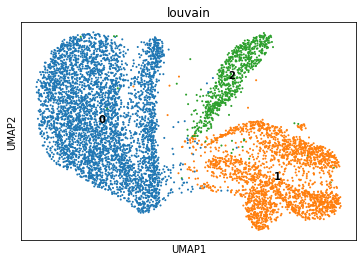

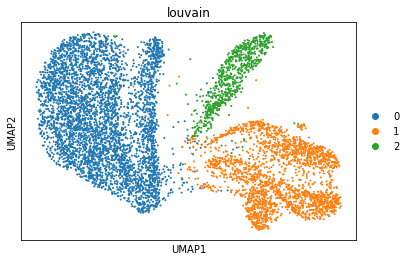

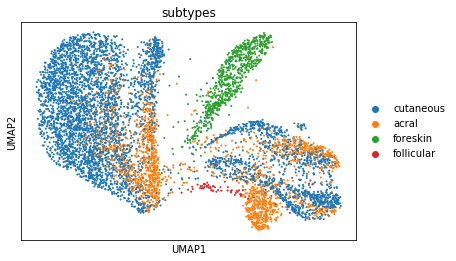

In [3]:
print('computing...')

n_pcs = 75
coi = full_adata[[x in ['cutaneous_mel',
                'acral_mel',
                'foreskin_mel',
                'dark_foll_mel',
                'light_foll_mel',] for x in full_adata.obs.class_2]].obs.index.tolist()
raw_adata.obs['recluster'] = [x in coi for x in raw_adata.obs.index]
adata_subset2 = raw_adata[raw_adata.obs['recluster'] == True]
adata_subset2 = sc.pp.log1p(adata_subset2, copy=True) # new
sc.pp.highly_variable_genes(adata_subset2,min_mean=0.1,max_mean=10,min_disp=0.5) # new
sc.pp.scale(adata_subset2) # new
sc.tl.pca(adata_subset2, use_highly_variable = True, n_comps=n_pcs) # new
sc.pp.neighbors(adata_subset2, n_pcs=n_pcs, n_neighbors=100) # new
sc.tl.umap(adata_subset2, min_dist = 0.5)
sc.tl.louvain(adata_subset2, resolution = 0.25)
sc.pl.umap(adata_subset2, color=['louvain'], legend_loc='on data')
sc.pl.umap(adata_subset2, color=['louvain'])


# add feature labels
for input_adata in [adata_subset2]:
    input_adata.obs['true_year'] = [float(x.split('WK')[0])/52 if len(x.split('WK')[0]) <= 3 else np.nan for x in input_adata.obs.patient]
    input_adata.obs['true_year'] = [y+(9/12) if np.isnan(x) else x for x,y in zip(input_adata.obs['true_year'], input_adata.obs['age']) ]

    input_adata.obs['dev_stage'] = ['adt' if x > 0 else 'neo' if x == 0 else 'fet' for x in input_adata.obs.age]
    input_adata.obs['subtypes'] = [x if x in ['acral','foreskin'] else 'cutaneous' for x in input_adata.obs.general_location]
    foll_idx = full_adata[[x in ['light_foll_mel','dark_foll_mel'] for x in full_adata.obs.class_2]].obs.index.tolist()
    input_adata.obs['subtypes'] = ['follicular' if x in foll_idx \
                                   else y for x,y in zip(input_adata.obs.index, input_adata.obs['subtypes'])]
    input_adata.obs['acral_subtype'] = [x if x == 'acral' else 'not_acral' for x in input_adata.obs['subtypes']]
    input_adata.obs['foreskin_subtype'] = [x if x == 'foreskin' else 'not_foreskin' for x in input_adata.obs['subtypes']]
    input_adata.obs['follicular_subtype'] = [x if x == 'follicular' else 'not_follicular' for x in input_adata.obs['subtypes']]

    input_adata.obs['dev_subtype'] = [f'{x}_{y}' for x,y in zip(input_adata.obs.dev_stage, input_adata.obs.subtypes)]

    
    for i in ['dev_stage', 'subtypes', 'acral_subtype' ,'foreskin_subtype','follicular_subtype','dev_subtype']:
        input_adata.obs[i] =  (input_adata
                                 .obs[i]
                                 .astype(str)
                               .astype(CategoricalDtype(eval(f'{i}_order'), ordered = True))
                              )
        
sc.pl.umap(adata_subset2, color = 'subtypes')

In [ ]:
print('computing...')
input_adata = adata_subset2
class_ref = 'subtypes'
type_order_ref = ['cutaneous','acral','foreskin','follicular']

umap_df = pd.DataFrame(input_adata.obsm['X_umap'], columns = ['xvar','yvar'])
umap_df[class_ref] = input_adata.obs[class_ref].values
umap_df[class_ref] = (umap_df[class_ref]
                      .astype(str)
                      .astype(CategoricalDtype(type_order_ref, ordered=True))
                     )

plotnine.options.figure_size = (4,4)
plot = (ggplot(umap_df)
        + theme_bw()
        + theme(aspect_ratio = 1)
        + geom_point(aes('xvar','yvar',color=class_ref), size = 0.1)
       )
print(plot)


In [ ]:
# n_pcs = 75
# coi = full_adata[full_adata.obs.class_1 == 'mel'].obs.index.tolist()
# raw_adata.obs['recluster'] = [x in coi for x in raw_adata.obs.index]
# adata_subset2 = raw_adata[raw_adata.obs['recluster'] == True]
# adata_subset2 = sc.pp.log1p(adata_subset2, copy=True) # new
# sc.pp.highly_variable_genes(adata_subset2,min_mean=0.1,max_mean=10,min_disp=0.5) # new
# sc.pp.scale(adata_subset2) # new
# sc.tl.pca(adata_subset2, use_highly_variable = True, n_comps=n_pcs) # new
# sc.pp.neighbors(adata_subset2, n_pcs=n_pcs, n_neighbors=100) # new
# sc.tl.umap(adata_subset2, min_dist = 0.5)
# sc.tl.louvain(adata_subset2, resolution = 0.25)
# sc.pl.umap(adata_subset2, color=['louvain'], legend_loc='on data')
# sc.pl.umap(adata_subset2, color=['louvain'])


### BSC comparison between acral and cutaneous sites

In [ ]:
print('computing...')

input_adata = adata_subset2
plot_df = pd.DataFrame(input_adata.obs.groupby(['patient','subtypes'])['bsc'].mean()).reset_index()
plot_df = plot_df[[x in ['acral','cutaneous'] for x in plot_df.subtypes]]

# determine samples with acral and cutaneous
filter_df = pd.DataFrame(plot_df['patient'].value_counts())
filter_df = filter_df[filter_df['patient'] > 1]
filter_list = filter_df.index.tolist()

# filter plot_df
plot_df = plot_df[[x in filter_list for x in plot_df.patient]]

# normalize by patient
plot_df['norm_bsc'] = plot_df.groupby('patient')['bsc'].apply(lambda x: x/np.min(x)).values
plot_df['subtypes'] = (plot_df['subtypes']
                      .astype(str)
                      .astype(CategoricalDtype(['acral','cutaneous'], ordered = True))
                     )

# plot
plotnine.options.figure_size = (3,3)
plot = (ggplot(plot_df) 
        + theme_bw()
        + theme(axis_text_x = element_text(angle = 90))
        + geom_bar(aes('patient','norm_bsc', fill = 'subtypes'), stat = 'identity', position = 'dodge')
        + labs(y = "min-normalized mean BSC-A")
       )
print(plot)



### Acral vs cutaneous DE

In [ ]:
print('computing...')
target_set = ['acral']
ref_set = ['cutaneous']
source_groupby = 'subtypes'
gene_n=100
input_adata = adata_subset2

input_adata = input_adata[[x in target_set+ref_set for x in input_adata.obs[source_groupby]]]
input_adata.obs['DE_grouping'] = ['target' if x in target_set \
                            else 'ref' \
                            for x in input_adata.obs[source_groupby]]

genelist = fast_DE(input_adata, clusterOI='target', groupby='DE_grouping', reference='ref', gene_n=gene_n)

In [ ]:
# gene correlation to bsc
print('computing...')
input_adata = adata_subset2
input_adata = input_adata[[x in filter_list for x in input_adata.obs.patient]]

for goi in ['LGI3','OCA2','HPGD',
            'NTRK2',
            'TYR','DCT','MITF']:
    cat, df = prepare_dataframe(input_adata,
                                goi,
                                'patient'
                               )
    df = df.reset_index()
    df['subtypes'] = input_adata.obs.subtypes.tolist() 
    df['subtypes'] = (df['subtypes']
                      .astype(str)
                      .astype(CategoricalDtype(['acral','cutaneous'], ordered = True))
                     )
    df = df.dropna()
    plotnine.options.figure_size = (4,4)
    plot = (ggplot(df)
            + theme_bw()
            + theme(axis_text_x = element_text(angle = 90),
                    aspect_ratio = 1)
            + geom_boxplot(aes('patient',goi,color='subtypes'))
            + facet_wrap('~subtypes', ncol = 6)
           )
    print(plot)


### (decommissioned) BSC correlation to gene expression
- weak correlation

In [ ]:
# print('computing...')
# input_adata = adata_subset2[[x in filter_list for x in adata_subset2.obs.patient]]
# cat, df = prepare_dataframe(input_adata,
#                             ['NTRK2','HPGD','TYR'],
#                             'patient'
#                            )
# df = df.reset_index()
# df['bsc'] = input_adata.obs.bsc.values
# df['subtypes'] = input_adata.obs.subtypes.values
# df['subtypes'] = (df['subtypes']
#                   .astype(str)
#                   .astype(CategoricalDtype(['acral','cutaneous'], ordered = True))
#                  )
# df = df.dropna()
# df = pd.melt(df, id_vars = ['subtypes','bsc','patient'])

# plotnine.options.figure_size = (4,4)
# plot = (ggplot(df)
#         + theme_bw()
#         + theme(aspect_ratio = 1)
#         + geom_point(aes('value','bsc', color = 'variable'), alpha = 0.2)
#         + facet_grid('patient~subtypes', scales = 'free')
# #         + scale_y_log10()
#        )
# print(plot)


### supplemental: PCA-based feature analysis

##### Tukey test and recluster

In [ ]:
# # initial PC coordinates
# cutoff = 5
# n_pcs = 75
# input_adata = adata_subset2
# sc.pl.pca(input_adata, components=['1,2', '2,3','3,4'], color=['louvain'])

# # cull cells using Tukey outlier threshold
# df = pd.DataFrame(input_adata.obsm['X_pca'])
# df.columns = ['PC_{}'.format(x) for x in range(n_pcs)]

# omit_names = []
# for pc in df.columns:
# #     print(len(set(omit_names)))
#     Q1 = df[pc].quantile(0.25)
#     Q3 = df[pc].quantile(0.75)
#     IQR = Q3 - Q1

#     bool_idx = [(Q1 - (cutoff * IQR)) > x or x > (Q3 + (cutoff * IQR)) for x in df[pc]]
#     filtered = df[bool_idx]
# #     print('Filtered cells: ', len(df)-len(filtered))
    
#     omit_names = omit_names + input_adata.obs[bool_idx].index.tolist()

# print('Filtered cells: ', len(set(omit_names)))
# print('Fraction filtered: ', len(set(omit_names))/len(input_adata.obs) )

# # check where the outliers lie in original projection
# input_adata.obs['outliers'] = ['outlier' if x in set(omit_names) else 'ingroup' for x in input_adata.obs.index]

# # outliers among adt-mels
# components = ['1,2', '2,3','3,4','4,5','5,6','6,7','7,8','8,9']
# sc.pl.pca(input_adata, components=components, color=['outliers'], ncols =3)
# sc.pl.umap(input_adata, color=['outliers'], cmap='magma')

# # outliers on all-cells projection
# type_dict = {'ingroup':['ingroup'],
#              'outlier':['outlier']}
    
# classify_type(full_adata, input_adata, 'outliers', type_dict, 'outliers')
# classify_type(raw_adata, input_adata, 'outliers', type_dict, 'outliers')

# sc.pl.umap(full_adata, color = ['outliers'])

# # recompute PCA and clustering
# n_pcs = 100

# feature_dict = {'outliers':['ingroup']}
# adata_subset2_trimmed = subset_adata_v3(raw_adata,feature_dict)
# sc.pp.log1p(adata_subset2_trimmed) # new
# sc.pp.highly_variable_genes(adata_subset2_trimmed,min_mean=0.5,max_mean=10,min_disp=0.5) # new
# sc.pp.scale(adata_subset2_trimmed) # new
# sc.tl.pca(adata_subset2_trimmed, use_highly_variable = True, n_comps=n_pcs) # new
# sc.pl.pca(adata_subset2_trimmed, components=components)
# sc.pp.neighbors(adata_subset2_trimmed,n_pcs=n_pcs) # new
# sc.tl.umap(adata_subset2_trimmed, min_dist = 0.25)
# sc.tl.louvain(adata_subset2_trimmed, resolution = 0.2)
# sc.pl.umap(adata_subset2_trimmed, color=['louvain'], legend_loc='on data')

# # add feature labels
# for input_adata in [adata_subset2_trimmed]:
#     input_adata.obs['true_year'] = [float(x.split('WK')[0])/52 if len(x.split('WK')[0]) <= 3 else np.nan for x in input_adata.obs.patient]
#     input_adata.obs['true_year'] = [y+(9/12) if np.isnan(x) else x for x,y in zip(input_adata.obs['true_year'], input_adata.obs['age']) ]

#     input_adata.obs['dev_stage'] = ['adt' if x > 0 else 'neo' if x == 0 else 'fet' for x in input_adata.obs.age]
#     input_adata.obs['subtypes'] = [x if x in ['acral','foreskin'] else 'cutaneous' for x in input_adata.obs.general_location]
#     input_adata.obs['acral_subtype'] = [x if x == 'acral' else 'not_acral' for x in input_adata.obs['subtypes']]
#     input_adata.obs['foreskin_subtype'] = [x if x == 'foreskin' else 'not_foreskin' for x in input_adata.obs['subtypes']]
#     input_adata.obs['dev_subtype'] = [f'{x}_{y}' for x,y in zip(input_adata.obs.dev_stage, input_adata.obs.subtypes)]

    
#     for i in ['dev_stage', 'subtypes', 'acral_subtype' ,'foreskin_subtype', 'dev_subtype']:
#         input_adata.obs[i] =  (input_adata
#                                  .obs[i]
#                                  .astype(str)
#                                .astype(CategoricalDtype(eval(f'{i}_order'), ordered = True))
#                               )
        

##### outlier DE analysis

In [ ]:
# input_adata = adata_subset2
# clusterOI = 'outlier'
# reference= 'ingroup'  #'rest'
# groupby = 'outliers'

# sc.tl.rank_genes_groups(input_adata, groupby=groupby, groups=[clusterOI], method='wilcoxon',reference=reference)
# gene = [x[0] for x in input_adata.uns['rank_genes_groups']['names']]
# out = symbol2field(gene[:50])
# output = [print(f'{idx}: ', 
#        x['query'],
#        '\n',x['summary']) if ('summary' in x.keys()) else print(f'{idx}: ', 
#                                                                 x['query'],
#                                                                 '\n','N/A') for idx, x in enumerate(out)]


In [ ]:
# # top10 genes:
# gene[:10]

#### logistic regression for feature analysis using PC space
- logistic regression trained on PCs to classify feature labels
    - top 2 models with highest accuracy (f1 statistic) are identified for visualization

##### logistic regression

In [ ]:
# # enforce class balance
# sample_n = 1500
# pc_n = 10
# input_adata = adata_subset2
# label_groups = ['dev_stage','subtypes','acral_subtype','foreskin_subtype','follicular_subtype']
# # label_groups = ['dev_stage']


# master_df = pd.DataFrame()
# for key in label_groups:
#     print(key)
    
#     acc_list = []
#     PCA_list = []
#     PCB_list = []
#     for PC_tup in tqdm.tqdm([x for x in combinations([x for x in range(pc_n)],2)]):
        
#         labels = list(set(input_adata.obs[key]))
#         label_master = []
#         PCA = PC_tup[0]
#         PCB = PC_tup[1]
#         PCA_coord = []
#         PCB_coord = []
        
#         for label in labels:
#             input_slice = input_adata[input_adata.obs[key] == label]
#             sample_idx = random.choices(range(len(input_slice)), k = sample_n)
#             label_slice = [label]*sample_n
#             label_master = label_master + label_slice
#             PCA_coord = PCA_coord + input_slice.obsm['X_pca'][:,PCA][sample_idx].tolist()
#             PCB_coord = PCB_coord + input_slice.obsm['X_pca'][:,PCB][sample_idx].tolist()
        
#         pc_master = np.zeros((sample_n*len(labels),2))
#         pc_master[:,0] = PCA_coord
#         pc_master[:,1] = PCB_coord
            
#         acc = pca_logistic(pred = pc_master, res = np.array(label_master))
#         acc_list.append(acc)
#         PCA_list.append(PCA)
#         PCB_list.append(PCB)
        
#         df_slice = pd.DataFrame({'PCA':[x+1 for x in PCA_list],
#                                  'PCB':[x+1 for x in PCB_list],
#                                  'f1':acc_list}
#                                )
#         df_slice['label_group'] = key

#     master_df = master_df.append(df_slice)

#     comps = (master_df[master_df.label_group == key]
#              .sort_values('f1', ascending = False)
#              .iloc[0:1,:]
#              .loc[:,['PCA','PCB']]
#              .values
#              .flatten()
#              .tolist()
#             )
#     sc.pl.pca(input_adata, color = [key], components=comps)
        

##### PC loadings gene list

In [ ]:
# input_adata = adata_subset2_trimmed
# print('acral pc loadings')
# sc.pl.pca_loadings(input_adata, components = [2,6])
# print('forskin pc loadings')
# sc.pl.pca_loadings(input_adata, components = [4,3])

##### (decommissioned) dev_subtype covariance matrix

In [ ]:
# ### correlation of bulkized expression vectors
# input_adata = adata_subset2_trimmed
# groupby = 'dev_subtype'
# high_var_genes = (input_adata.var['highly_variable'] \
#                   [input_adata.var['highly_variable'] == True]).index.tolist()

# cat, df = prepare_dataframe(input_adata,
#                             high_var_genes,
#                             groupby
#                            )

# corr_df = df.reset_index()
# corr_df[groupby] = corr_df[groupby].astype(str)
# corr_df = corr_df.groupby(groupby).mean().T.corr('spearman') ** 2
# corr_df = corr_df.reset_index()
# corr_df = pd.melt(corr_df, id_vars=groupby, var_name = 'variable')

# plotnine.options.figure_size = (3,3)
# print(ggplot(corr_df)
#       + theme_bw()
#       + theme(axis_text_x = element_text(angle = 90))
#       + geom_tile(aes(groupby, 'variable', fill = 'value'))
#       + geom_text(aes(groupby, 'variable', label = 'value'), 
#                   format_string='{:.2f}', color = 'grey')
#       + scale_fill_cmap('magma')
#      )


# Figure 2: Age differences

## Adult vs. fetal differential expression in MELs

### functional genesets

computing...


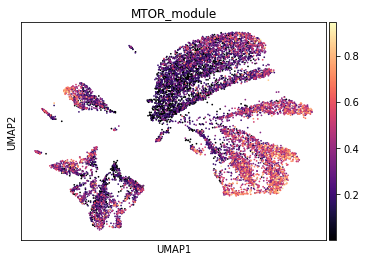

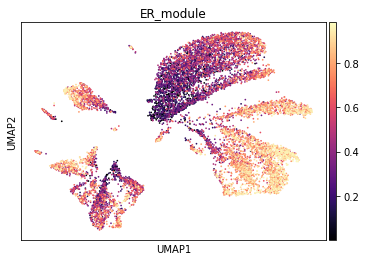

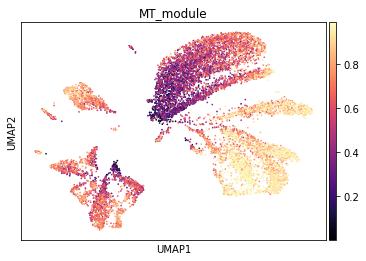

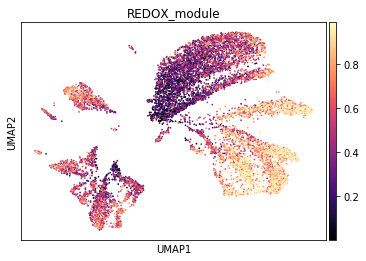

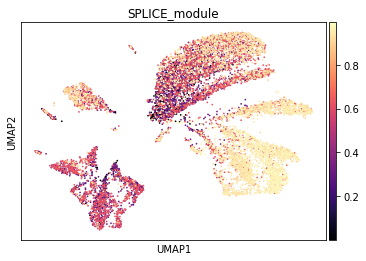

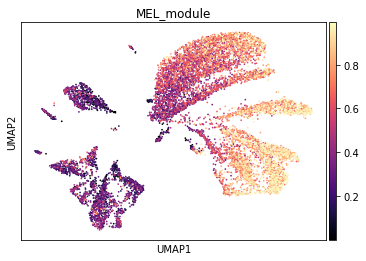

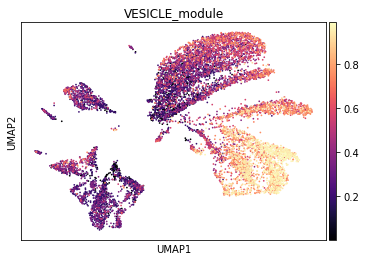

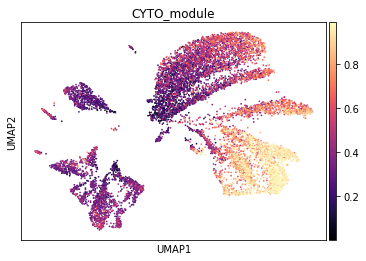

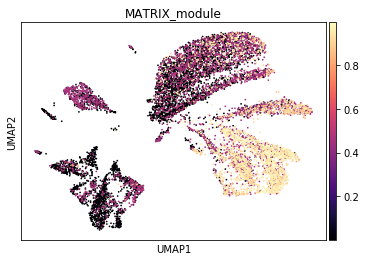

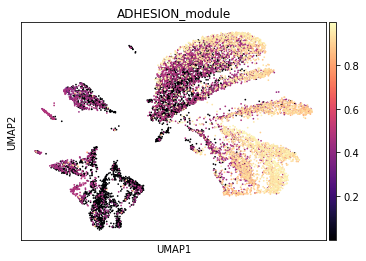

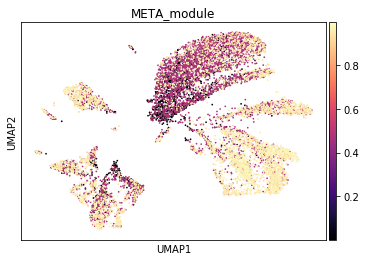

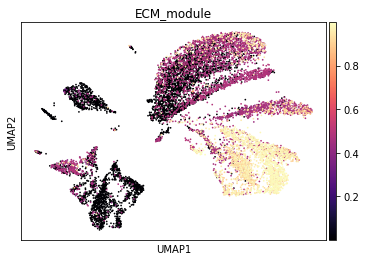

In [80]:
print('computing...')
MTOR_module = ['TBC1D7','TSC1', 'TSC2','AKT1S1',
              'RICTOR ','MAPKAP1','RHEB '
              ]
ER_module = ['HSPD1','HSPH1','DNAJA1','HSF1','HSPA4','HSPA5']
MT_module = ['CHCHD3','SLC25A5','HIGD2A','ZNF106',
             'MRPL12','SLC25A6','TIMM13','PPA1','QPRT']
REDOX_module = ['GPX1','PPA1','QPRT','GSTA4',
               'HMOX2']
SPLICE_module = ['TRA2A','CELF2','ZNF106']
MEL_module = ['WIPI1','CHCHD3','PMEL','GPNMB','STX3','TPCN2']
VESICLE_module = ['STX7','MYO1B','ANXA6','CHP1','RAB3B']
CYTO_module = ['PDLIM3','TUBB3','PHACTR3','TMSB4X',
               'TUBB2B','IQGAP1','ANK2','PLS3']
MATRIX_module = ['LIMS2','TP53I11']
ADHESION_module = ['L1CAM','SEMA3C']
META_module = ['PGLS','GPI']
ECM_module = ['MMP17','COL1A2']

# compile modules
modules_dict = {'MTOR_module':MTOR_module,
                'ER_module':ER_module,
                'MT_module':MT_module,
                'REDOX_module':REDOX_module,
                'SPLICE_module':SPLICE_module,
                'MEL_module':MEL_module,
                'VESICLE_module':VESICLE_module,
                'CYTO_module':CYTO_module,
                'MATRIX_module':MATRIX_module,
                'ADHESION_module':ADHESION_module,
                'META_module':META_module,
                'ECM_module':ECM_module
               }

input_adata = full_adata
input_adata.obs['cell'] = input_adata.obs.index.tolist()
input_adata.obs['cell'] = (input_adata
                              .obs['cell']
                              .astype(str)
                              .astype(CategoricalDtype(input_adata.obs['cell'].tolist())))
cat, exp_df = prepare_dataframe(input_adata,
                 var_names = input_adata.var_names,
                 groupby = 'cell')
exp_df = exp_df.rank(pct=True, axis=1, method = 'min') # ranked expression per cell

for key,value in modules_dict.items():
    input_adata.obs[key] = exp_df.loc[:,value].mean(axis=1)
    sc.pl.umap(input_adata, color=[key], cmap = 'magma', palette = 'tab20')


In [91]:
print('computing...')
mod_df = input_adata.obs.loc[:,list(modules_dict.keys())+['class_3']]
mod_df = mod_df[[x.endswith('_mel') and not x.startswith('cyc_') for x in mod_df.class_3]]
mod_df = pd.melt(mod_df, id_vars='class_3')
mod_df['class_3'] = (mod_df['class_3']
                     .astype(str)
                     .astype(CategoricalDtype([x for x in type_order_3 if x in set(mod_df['class_3'])],
                                             ordered=True)
                            )
                    )


computing...


computing...


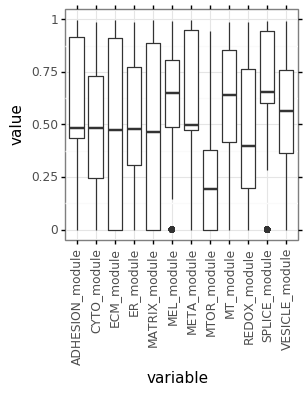

<ggplot: (8744238628742)>


In [94]:
print('computing...')

plot = (ggplot(mod_df)
        + theme_bw()
        + theme(axis_text_x = element_text(angle = 90))
        + geom_boxplot(aes('class','value'))
       )
print(plot)

### MWU tests
- iterative downsampling used to overcome machine precision limit on p-values

In [ ]:
set(input_adata.obs['dev_subtype'])

In [ ]:
print('computing...')
target_set = ['acr']
ref_set = ['cutaneous_mel',
            'acral_mel',
            'foreskin_mel']
source_groupby = 'class_2'
gene_n=100
input_adata = adata_subset2

input_adata = input_adata[[x in target_set+ref_set for x in input_adata.obs[source_groupby]]]
input_adata.obs['DE_grouping'] = ['target' if x in target_set \
                            else 'ref' \
                            for x in input_adata.obs[source_groupby]]

fast_DE(input_adata, clusterOI='target', groupby='DE_grouping', reference='ref', gene_n=gene_n)

In [ ]:
# n_print = 10
# run_me = True

# if run_me == True:
#     adt_v_fet_DE = pd.DataFrame()
#     cell_type_key = {'mel':adata_subset2,'krt':full_adata[full_adata.obs.class_1 == 'krt']}
#     for cell_type in ['mel', 'krt']:
#         input_adata = cell_type_key[cell_type]
#         genes = input_adata.var_names.tolist()
#         cat, prep_slice = prepare_dataframe(input_adata,
#                                              var_names = genes,
#                                              groupby = 'dev_stage')
#         for i in ['greater', 'less']:
#             if run_me == True:
#                 print(f'fetal {cell_type} {i} than adult {cell_type}:')

#                 frac = 1
#                 n_uncert = 1
#                 while n_uncert > 0:

#                     fet_slice = (prep_slice[[x == 'fet' for x in prep_slice.index]]
#                                  .sample(frac=frac))
#                     adt_slice = (prep_slice[[x == 'adt' for x in prep_slice.index]]
#                                  .sample(frac=frac))

#                     print(f'Testing downsample fraction = {frac}')
#                     stat_pval_tuple = parallel_mwu(genes, 
#                                                fet_slice, 
#                                                adt_slice, 
#                                                i, 
#                                                usable_cores)
#                     stat_list = stat_pval_tuple[0]
#                     pval_list = stat_pval_tuple[1]
#                     results_df = pd.DataFrame({'gene':genes,
#                                              'stat_1':stat_list,
#                                              'pval_1':pval_list,
#                                             })
#                     results_df['frac'] = frac
#                     results_df['test'] = f'fetal {i} than adult'
#                     results_df['cell_type'] = cell_type
#                     n_uncert = sum(results_df['pval_1'] == 0)
#                     frac /= 2
#                 print(f'downsample fraction: {frac}')
#                 adt_v_fet_DE = adt_v_fet_DE.append(results_df)
#             if len(adt_v_fet_DE) != 0:
#                 filtered_df = adt_v_fet_DE[[x == f'fetal {i} than adult' and y == cell_type \
#                                             for x,y in zip(adt_v_fet_DE.test,adt_v_fet_DE.cell_type)]]
#                 print_df = (filtered_df
#                             .dropna()
#                             .sort_values('pval_1')
#                             .head(10))
#                 display(print_df)
                
#     # pickle adatas
#     wkdir, s3dir = '/home/ubuntu/data/DL20181011_melanocyte_test_data', 'daniel.le-work/MEL_project'

#     for objname in ['adt_v_fet_DE']:
#         pickle.dump(eval(objname), open( f"{wkdir}/{objname}.p", "wb" ) )
#         syscmd = f'aws s3 cp {wkdir}/{objname}.p s3://{s3dir}/'
#         subprocess.run(syscmd.split(' '))


### heatmap of DE genes: fet vs adt

In [ ]:
# gene_n = 50
# cell_type = 'mel'
# # cell_type = 'krt'
# test_type = 'fetal greater than adult'
# # test_type = 'fetal less than adult'
# clust_dict = {'fetal less than adult':4,
#               'fetal greater than adult':3
#              }
# n_clust = clust_dict.get(test_type)

# results = (adt_v_fet_DE[[x == cell_type and y == test_type for x,y in zip(adt_v_fet_DE.cell_type, adt_v_fet_DE.test)]]
#              .sort_values('pval_1')
#             )
# # display(results.head(gene_n))

# gene_order = results.gene.tolist()[:gene_n]
# input_adata = full_adata
# n_cells = 100
# groupby = 'class_stage'
# input_adata.obs[groupby] = [f'{x}_{y}' for x,y in zip(input_adata.obs['class_1'],input_adata.obs['dev_stage'])]

# type_order = ['mel_fet','mel_adt','krt_fet','krt_adt','eccrine_fet','eccrine_adt']

# cat, exp_df = prepare_dataframe(input_adata,
#                  var_names = gene_order,
#                  groupby = 'cell')

# exp_df = exp_df.apply(lambda x: min_max_scaler(np.log1p(x).values))
# exp_df[groupby] = input_adata.obs[groupby].tolist()

# compiled_rows = pd.DataFrame()
# type_order_revised = []
# for x in type_order:
#     df_slice = exp_df[exp_df[groupby] == x]
#     df_nrow = len(df_slice)
#     if df_nrow >= n_cells:
#         df_sample = df_slice.sample(n_cells)
#         num_cell = n_cells
#     else:
#         df_sample = df_slice
#         num_cell = df_nrow
#     df_sample['idx'] = [x for x in range(len(df_sample))]
#     df_sample[groupby] = f'{x} ({num_cell}/{df_nrow})'
#     type_order_revised = type_order_revised + [f'{x} ({num_cell}/{df_nrow})']
#     compiled_rows = compiled_rows.append(df_sample)
    
# ### gene clustering
# data = compiled_rows.iloc[:,:-2].T.values

# cluster = AgglomerativeClustering(n_clusters=n_clust, 
#                                   affinity='euclidean', 
#                                   linkage='ward')  
# labels = cluster.fit_predict(data).tolist()
# label_df = pd.DataFrame({'gene':compiled_rows.iloc[:,:-2].columns.values,
#                          'label':labels})
# gene_order = label_df.sort_values('label').gene.tolist()
# ###

# compiled_rows_melt = pd.melt(compiled_rows, id_vars=[groupby,'idx'])
# compiled_rows_melt[groupby] = (compiled_rows_melt[groupby]
#                                  .astype(str)
#                                  .astype(CategoricalDtype(type_order_revised,
#                                                           ordered=True
#                                                          )
#                                         )
#                                 )
# compiled_rows_melt['variable'] = (compiled_rows_melt['variable']
#                                  .astype(str)
#                                  .astype(CategoricalDtype(gene_order,
#                                                           ordered=True
#                                                          )
#                                         )
#                                 )

# plotnine.options.figure_size = (7,7)
# plot = (ggplot(compiled_rows_melt)
#       + theme_bw()
#       + theme(axis_text_x = element_blank(),
#               strip_text_x = element_text(angle = 90, vjust = 0),
#               strip_background_x = element_rect(fill = 'white', color = 'white') )
#       + geom_tile(aes('idx','variable',fill='value'))
#       + facet_grid(f'~{groupby}', scales='free')
#       + scale_fill_cmap('magma')
#       + labs(x = '', y = ''))

# print(plot)


### gene look-up

In [ ]:
# # look up gene
# gene = 'MCAM'
# groupby = 'dev_stage'
# input_adata = adata_subset2_trimmed

# sc.pl.umap(input_adata, color = [gene,groupby], cmap='nipy_spectral', palette = 'tab20')

# cat, plot_df = prepare_dataframe(input_adata,
#                             gene,
#                             groupby
#                            )

# plot_df = plot_df.reset_index().dropna()
# plotnine.options.figure_size = (3,3)
# print(ggplot(plot_df)
#       + theme_bw()
#       + theme(axis_text_x = element_text(angle = 90))
#       + geom_violin(aes(groupby, gene, color = groupby))
#       + geom_jitter(aes(groupby, gene, color = groupby), alpha = 0.01)
#      )

# out = symbol2field(gene)
# output = [print(f'{idx}: ', 
#        x['query'],
#        '\n',x['summary']) if ('summary' in x.keys()) else print(f'{idx}: ', 
#                                                                 x['query'],
#                                                                 '\n','N/A') for idx, x in enumerate(out)]


## (decommissioned) Age rank correlations in MELs
n_genes correlation computed for control

### (decommissioned) spearman correlation

In [ ]:
# n_print = 20

# ### select MEL vs KRT ###
# input_adata = adata_subset2_trimmed
# # input_adata = adata_subset1_KRT

# ### select adt vs fet ###
# # dev_stage = 'adt'
# dev_stage = 'fet'

# ### select acral vs cutaneous ###
# # subtype = 'acral'
# subtype = 'cutaneous'

# print(f'{dev_stage} {subtype} age correlation')

# input_adata = input_adata[[x == dev_stage and y == subtype \
#                            for x,y in zip(input_adata.obs.dev_stage, 
#                                           input_adata.obs.subtypes)]]

# groupby = 'patient'
# cat, gene_df = prepare_dataframe(input_adata,
#                                  input_adata.var_names.tolist(),
#                                  groupby
#                                 )
# gene_df = gene_df.transform(lambda x: np.log1p(x))

# age_vec = input_adata.obs['true_year'].values
# ngenes_vec = input_adata.obs['n_genes'].values

# stat1_list = []
# pval1_list = []
# stat2_list = []
# pval2_list = []
# gene_list = []
# for i in input_adata.var_names.tolist():
#     gene_vec = gene_df.loc[:, i].values
#     stat1, pval1 = stats.spearmanr(age_vec, gene_vec)
#     stat2, pval2 = stats.spearmanr(ngenes_vec, gene_vec)
#     stat1_list.append(stat1)
#     pval1_list.append(pval1)
#     stat2_list.append(stat2)
#     pval2_list.append(pval2)
#     gene_list.append(i)
    
# corr_df = pd.DataFrame({'gene':gene_list,
#                         'stat_1':stat1_list,
#                         'pval_1':pval1_list,
#                         'stat_2':stat2_list,
#                         'pval_2':pval2_list
#                        })
# display(corr_df.sort_values('pval_1').head(n_print))


### (decommissioned) gene lookup

In [ ]:
# # look up gene
# input_adata = full_adata
# gene = 'RPS27'

# sc.pl.umap(input_adata, color = [gene, 'true_year', 'n_genes'], cmap='nipy_spectral')
# groupby = 'patient'
# cat, plot_df = prepare_dataframe(input_adata,
#                             gene,
#                             groupby
#                            )
# plot_df['true_year'] =  input_adata.obs.true_year.tolist()
# plotnine.options.figure_size = (4,4)
# print(ggplot(plot_df)
#       + theme_bw()
#       + theme(axis_text_x = element_text(angle = 90))
#       + geom_point(aes('true_year',gene), alpha = 0.05)
#       + geom_point(plot_df.reset_index().groupby('patient').mean(), aes('true_year',gene), 
#                    shape = '_', color = 'red', size = 5)
#       + geom_line(plot_df.reset_index().groupby('patient').mean(), aes('true_year',gene), 
#                    color = 'red')
#       + scale_x_log10()
#      )

# print(ggplot(pd.DataFrame(plot_df
#                      .reset_index()
#                      .groupby('patient')[gene]
#                      .apply(lambda x: zero_fraction(x))
#                     )
#                      .assign(true_year = plot_df.reset_index()
#                                                            .groupby('patient')
#                                                            .mean()
#                                                            .true_year)
#                      .rename(columns = {gene:'zero_fraction'}))
#       + theme_bw()
#       + geom_point(aes('true_year','zero_fraction'))
#       + geom_line(aes('true_year','zero_fraction'))
#       + scale_x_log10()
#      )

# out = symbol2field(gene)
# output = [print(f'{idx}: ', 
#        x['query'],
#        '\n',x['summary']) if ('summary' in x.keys()) else print(f'{idx}: ', 
#                                                                 x['query'],
#                                                                 '\n','N/A') for idx, x in enumerate(out)]


## (decommissioned) MEL- or KRT-specific adult vs. fetal differential expression
- Identify differentially-expressed genes unique to cell type

### (decommissioned) Determine difference in MWU adult vs fetal test p-values between cell types
- Normalize against fetal vs adult KRT DE genes

#### (decommissioned) MWU test and ad hoc subtraction

In [ ]:
# # correlate KRT vs MEL to determine unique development program
# n_print = 20
# sort_term = 'mel'
# i = 'less' #'fetal {i} than adult'
# ref1 = 'krt' # baseline for normalization
# ref2 = 'mel'
# delta_cutoff = 0.9
# DE_cutoff = 0.2

# print(f'fetal {sort_term} {i} than adult {sort_term}, normalized by {ref1}. Minimum differential expression percentile = {DE_cutoff}')
# print(f'Minimum squared difference between {ref2} and {ref1} percentile = {delta_cutoff}')

# # Ranked MWU p-values
# for idx, ref in enumerate([ref1, ref2]):
#     vec = ((adt_v_fet_DE[[x == ref and y == f'fetal {i} than adult' for x,y in zip(adt_v_fet_DE.cell_type, 
#                                                                                                adt_v_fet_DE.test)]]
#                     .sort_values('gene')
#                     .fillna(1)
#                     .assign(pval_1 = lambda x: 1-x.pval_1.rank(pct = True))
#                 )['pval_1']
#                 .values
#                 .reshape(-1,1))
#     ref_idx = idx + 1
#     exec(f'ref{ref_idx}_vec = vec')

# plot_df = pd.DataFrame({ref1:ref1_vec.flatten(),
#                         ref2:ref2_vec.flatten(),
#                        })

# plot_df['gene'] = sorted(list(set(adt_v_fet_DE.gene)))
# plot_df['delta'] = plot_df[ref1] - plot_df[ref2]
# plot_df['sq_delta'] = plot_df['delta'] ** 2
# plot_df['ranked_sq_delta'] = plot_df['sq_delta'].rank(pct = True)
# plot_df = plot_df[[x > DE_cutoff and y > DE_cutoff \
#                    for x,y in zip(plot_df.mel,plot_df.krt)]]

# plotnine.options.figure_size = (3,3)
# print(ggplot(plot_df)
#       + theme_bw()
#       + geom_histogram(aes('ranked_sq_delta'))
#       + geom_vline(aes(xintercept = delta_cutoff), color = 'red', linetype = '--')
#      )

# print_df = (plot_df[plot_df['ranked_sq_delta'] > delta_cutoff]
#             .sort_values(sort_term, ascending=False)
#             .head(n_print))
# display(print_df)
# glist = print_df.gene.tolist()

# plotnine.options.figure_size = (3,3)
# print(ggplot(plot_df)
#       + theme_bw()
#       + geom_bin2d(aes(ref1, ref2))
#       + geom_bin2d(plot_df[plot_df['ranked_sq_delta'] <= DE_cutoff], aes(ref1,ref2), fill = 'grey', alpha = 0.7)
#       + scale_fill_cmap('nipy_spectral')
#       + ggtitle(f'fetal {i} than adult')
#       + labs(x = f'{ref1} ranked MWU p-value',
#              y = f'{ref2} ranked MWU p-value'
#             )
#      )


### (decommissioned) Geneset enrichment of top genes

In [ ]:
# adt_v_fet_DE[adt_v_fet_DE.test == 'fetal greater than adult'].sort_values('pval_1').gene.tolist()[:100]

In [ ]:
# # determine the geneset of top genes
# glist = adt_v_fet_DE[adt_v_fet_DE.test == 'fetal less than adult'].sort_values('pval_1').gene.tolist()[:100]
# results = geneset_lookup(glist)
# results.filter(items = ['Term','Overlap','Adjusted P-value','Genes','Gene_set'])


### (decommissioned) DEV: fetal scoring 

In [ ]:
# # filter: fetal gene median expression > 0 and adult gene median expression == 0

# ### MUST run above section: MWU test and ad hoc subtraction

# print_n = 10

# input_adata = adata_subset2_trimmed
# genes = input_adata.var_names.tolist()
# cat, prep_slice = prepare_dataframe(input_adata,
#                                      var_names = genes,
#                                      groupby = 'dev_stage')

# df = (prep_slice
#       .reset_index()
#       .groupby('dev_stage')
#       .median()
#       .reset_index()
#      )

# df['dev_stage'] = df['dev_stage'].astype(str)
# df = df[df.dev_stage != 'neo']
# df = df.set_index('dev_stage').T
# df['pass'] = [x > y and y == 0 for x,y in zip(df.fet, df.adt)]
# df = df.reset_index().rename(columns ={'index':'gene'})
# df = pd.merge(print_df, df, 'left', 'gene')

# display(df[df['pass'] == True].head(print_n))


In [ ]:
# # fetal scoring module
# gene_n = 10
# fet_genes = df[df['pass'] == True].head(gene_n)['gene'].tolist()
# input_adata = adata_subset2_trimmed
# input_adata.obs['cell'] = input_adata.obs.index.tolist()
# input_adata.obs['cell'] = (input_adata
#                           .obs['cell']
#                           .astype(str)
#                           .astype(CategoricalDtype(input_adata.obs['cell'].tolist())))

# cat, exp_df = prepare_dataframe(input_adata,
#                  var_names = fet_genes,
#                  groupby = 'cell')
# exp_df = exp_df.rank(pct=True, axis=0, method = 'min') # ranked expression per cell
# exp_df = exp_df.rank(pct=True, axis=1, method = 'min') # ranking ranked expression per gene

# input_adata.obs['FET_score'] = exp_df.loc[:,fet_genes].mean(axis=1)

# sc.pl.umap(input_adata, color=['FET_score','n_genes','true_year'], 
#            ncols = 3, cmap = 'magma', palette = 'tab20')

# print(ggplot(input_adata.obs.loc[:,['FET_score','dev_subtype']])
#       + theme_bw()
#       + theme(axis_text_x = element_text(angle = 90))
#       + geom_boxplot(aes('dev_subtype','FET_score'))
#       + geom_jitter(aes('dev_subtype','FET_score'), 
#                     alpha = 0.01, width = 0.25)
#      )


In [ ]:
# print(ggplot(input_adata.obs.loc[:,['FET_score','dev_subtype']])
#       + theme_bw()
#       + theme(axis_text_x = element_text(angle = 90))
#       + geom_density(aes('FET_score'))
#       + facet_wrap('~dev_subtype')
#      )

In [ ]:
# # correlation to n_genes

# fet_genes = df[df['pass'] == True].head(gene_n)['gene'].tolist()
# input_adata = adata_subset2_trimmed[adata_subset2_trimmed.obs.age > 0]
# input_adata.obs['cell'] = input_adata.obs.index.tolist()
# input_adata.obs['cell'] = (input_adata
#                           .obs['cell']
#                           .astype(str)
#                           .astype(CategoricalDtype(input_adata.obs['cell'].tolist())))

# cat, exp_df = prepare_dataframe(input_adata,
#                  var_names = fet_genes,
#                  groupby = 'cell')
# exp_df = exp_df.rank(pct=True, axis=0, method = 'min') # ranked expression per cell
# exp_df = exp_df.rank(pct=True, axis=1, method = 'min') # ranking ranked expression per gene

# input_adata.obs['FET_score'] = exp_df.loc[:,fet_genes].mean(axis=1)
# plot_df = input_adata.obs.loc[:,['n_genes','FET_score']]
# results = plot_df.corr('spearman') ** 2
# display(results)

# print(ggplot(plot_df)
#       + theme_bw()
#       + geom_bin2d(aes('n_genes','FET_score'))
#      )


### (decommissioned) DEV: adult scoring 

In [ ]:
# # filter: adt gene median expression > 0 and fet gene median expression == 0

# ### MUST run above section: MWU test and ad hoc subtraction

# print_n = 10

# input_adata = adata_subset2_trimmed
# genes = input_adata.var_names.tolist()
# cat, prep_slice = prepare_dataframe(input_adata,
#                                      var_names = genes,
#                                      groupby = 'dev_stage')

# df = (prep_slice
#       .reset_index()
#       .groupby('dev_stage')
#       .median()
#       .reset_index()
#      )

# df['dev_stage'] = df['dev_stage'].astype(str)
# df = df[df.dev_stage != 'neo']
# df = df.set_index('dev_stage').T
# df['pass'] = [x < y and x == 0 for x,y in zip(df.fet, df.adt)]
# df = df.reset_index().rename(columns ={'index':'gene'})
# df = pd.merge(print_df, df, 'left', 'gene')

# display(df[df['pass'] == True].head(print_n))



In [ ]:
# # fetal scoring module
# gene_n = 10
# adt_genes = df[df['pass'] == True].head(gene_n)['gene'].tolist()
# input_adata = adata_subset2_trimmed
# input_adata.obs['cell'] = input_adata.obs.index.tolist()
# input_adata.obs['cell'] = (input_adata
#                           .obs['cell']
#                           .astype(str)
#                           .astype(CategoricalDtype(input_adata.obs['cell'].tolist())))

# cat, exp_df = prepare_dataframe(input_adata,
#                  var_names = adt_genes,
#                  groupby = 'cell')
# exp_df = exp_df.rank(pct=True, axis=0, method = 'min') # ranked expression per cell
# exp_df = exp_df.rank(pct=True, axis=1, method = 'min') # ranking ranked expression per gene

# input_adata.obs['ADT_score'] = exp_df.loc[:,adt_genes].mean(axis=1)

# sc.pl.umap(input_adata, color=['ADT_score','n_genes','true_year'], 
#            ncols = 3, cmap = 'magma', palette = 'tab20')

# plotnine.options.figure_size = (6,6)
# print(ggplot(input_adata.obs.loc[:,['ADT_score','dev_subtype']])
#       + theme_bw()
#       + theme(axis_text_x = element_text(angle = 90))
#       + geom_boxplot(aes('dev_subtype','ADT_score'))
#       + geom_jitter(aes('dev_subtype','ADT_score'), 
#                     alpha = 0.01, width = 0.25)
#      )
    

In [ ]:
# plotnine.options.figure_size = (6,6)
# print(ggplot(input_adata.obs.loc[:,['ADT_score','dev_subtype']])
#       + theme_bw()
#       + theme(axis_text_x = element_text(angle = 90))
#       + geom_density(aes('ADT_score'))
#       + facet_wrap('~dev_subtype')
#      )


# Figure 3: Site differences

## acral vs cutaneous differential expression in MELs

### MWU acral vs cutaneous

In [ ]:
gene_n = 50

run_me = True

if run_me == True:

    # simple DE between acral an cutaneous cells
    input_adata = adata_subset2
    acr_v_cut_df = pd.DataFrame()
    for test in ['less','greater']:

        genes = input_adata.var_names.tolist()
        cat, prep_slice = prepare_dataframe(input_adata,
                                             var_names = genes,
                                             groupby = 'subtypes')
        cut_input = prep_slice[[x == 'cutaneous' for x in prep_slice.index]]
        acr_input = prep_slice[[x == 'acral' for x in prep_slice.index]]

        stat_pval_tuple = parallel_mwu(genes, 
                                       acr_input,
                                       cut_input,  
                                       test,
                                       usable_cores)
        stat_list = stat_pval_tuple[0]
        pval_list = stat_pval_tuple[1]
        diff_df = (pd.DataFrame({'gene':genes,
                                 'stat_1':stat_list,
                                 'pval_1':pval_list
                                })
                  )
        diff_df['test'] = test
        acr_v_cut_df = acr_v_cut_df.append(diff_df)

    acr_v_cut_df['log10_pval_1'] = [-np.log10(x) for x in acr_v_cut_df['pval_1']]

## slice to top genes
greater_gene = (acr_v_cut_df[acr_v_cut_df.test == 'greater']
                .sort_values('log10_pval_1', ascending = False).head(gene_n)
               )
greater_gene['stat_1'] = [np.log10(x) for x in greater_gene['stat_1']]

less_gene = (acr_v_cut_df[acr_v_cut_df.test == 'less']
                .sort_values('log10_pval_1', ascending = False).head(gene_n)
            )
less_gene['stat_1'] = [-np.log10(x) for x in less_gene['stat_1']]

top_gene_df = less_gene.append(greater_gene)


In [ ]:
(top_gene_df[top_gene_df.test == 'less'].head(10)
.append(top_gene_df[top_gene_df.test == 'greater'].head(10)))


### MWU acral vs cutaneous, with respect to adult or fetal labels

In [ ]:
run_me = True

if run_me == True:

    input_adata = adata_subset2
    fet_v_adt_df = pd.DataFrame()
    for test in ['less','greater']:
        for dev_stage in ['fet','adt']:
            print(f'Calculating {dev_stage} acr {test} than cut...')
            input_slice = input_adata[input_adata.obs.dev_stage == dev_stage]
            genes = input_slice.var_names.tolist()
            cat, prep_slice = prepare_dataframe(input_slice,
                                                 var_names = genes,
                                                 groupby = 'subtypes')
            prep_slice = prep_slice[prep_slice.index != 'foreskin']
            cut_input = prep_slice[[x == 'cutaneous' for x in prep_slice.index]]
            acr_input = prep_slice[[x == 'acral' for x in prep_slice.index]]

            stat_pval_tuple = parallel_mwu(genes, 
                                           acr_input,
                                           cut_input,  
                                           test,
                                           usable_cores)
            stat_list = stat_pval_tuple[0]
            pval_list = stat_pval_tuple[1]
            diff_df = (pd.DataFrame({'gene':genes,
                                     'stat_1':stat_list,
                                     'pval_1':pval_list
                                    })
                      )
            diff_df['dev_stage'] = dev_stage
            diff_df['test'] = test
            fet_v_adt_df = fet_v_adt_df.append(diff_df)
        

In [ ]:
# pickle adatas
wkdir, s3dir = '/home/ubuntu/data/DL20181011_melanocyte_test_data', 'daniel.le-work/MEL_project'

for objname in ['fet_v_adt_df']:
    pickle.dump(eval(objname), open( f"{wkdir}/{objname}.p", "wb" ) )
    syscmd = f'aws s3 cp {wkdir}/{objname}.p s3://{s3dir}/'
    subprocess.run(syscmd.split(' '))

In [ ]:
n_print = 10
dev_stage = 'fet'
print(f'{dev_stage} acral (less/greater) than {dev_stage} cutaneous')

results_less = (fet_v_adt_df
             .fillna(1)
             .sort_values('pval_1')
             .query(f'dev_stage == "{dev_stage}"')
             .query(f'test == "less"')
          )
results_greater = (fet_v_adt_df
             .fillna(1)
             .sort_values('pval_1')
             .query(f'dev_stage == "{dev_stage}"')
             .query(f'test == "greater"')
          )

display(results_less.head(n_print).append(results_greater.head(n_print)))


In [ ]:
# gene_n = 300
# master_common = pd.DataFrame()
# for test in ['greater','less']:
#     results_fet = (fet_v_adt_df
#              .fillna(1)
#              .sort_values('pval_1')
#              .query(f'dev_stage == "fet"')
#              .query(f'test == "{test}"')
#           ).head(gene_n)
#     results_adt = (fet_v_adt_df
#          .fillna(1)
#          .sort_values('pval_1')
#          .query(f'dev_stage == "adt"')
#          .query(f'test == "{test}"')
#       ).head(gene_n)
    
#     common_genes = results_fet.append(results_adt)
#     common_genes = common_genes[common_genes.gene.duplicated('first')]
#     master_common = master_common.append(common_genes)
    

### MWU acral vs cutaneous, control for dev stage

#### 2-step test

In [ ]:
# To isolate acral-specific expression, the union of age-independent genes 
#between acral and cutaneous gene sets are tested for differential expression
run_me = True

if run_me == True:
    input_adata = adata_subset2
    genes = adata_subset2_trimmed.var_names.tolist()

    # Which acral or cutanesous-specific genes are NOT significantly different between FET and ADT?
    alpha = 0.05
    adj_alpha = alpha / (len(genes) * 2)

    type_specific_df = pd.DataFrame()
    for subtype in ['acral', 'cutaneous']:
        slice_df = input_adata[[x == subtype for x in input_adata.obs.subtypes]]
        cat, prep_slice = prepare_dataframe(slice_df,
                                         var_names = genes,
                                         groupby = 'dev_stage')
        fet_splice = (prep_slice[[x == 'fet' for x in prep_slice.index]])
        nfet_splice = (prep_slice[[x == 'adt' for x in prep_slice.index]])

        stat_pval_tuple = parallel_mwu(genes, 
                                   fet_splice, 
                                   nfet_splice, 
                                   'two-sided',
                                   usable_cores)
        stat_list = stat_pval_tuple[0]
        pval_list = stat_pval_tuple[1]
        tmp_df = (pd.DataFrame({'gene':genes,
                                 'stat_1':stat_list,
                                 'pval_1':pval_list
                                })
                  )
        tmp_df['subtypes'] = subtype
        tmp_df['pass'] = [x < adj_alpha for x in tmp_df['pval_1']]
        type_specific_df = type_specific_df.append(tmp_df)

    testable = type_specific_df[type_specific_df['pass'] == False]['gene'].value_counts()
    testable = testable[testable == 2]
    testable = testable.index.tolist()

    # Of the identified genes, which exhibit a significant difference between acral and cutaneous cell type

    adj_alpha = alpha / ((len(genes) * 2) + len(testable))
    cat, prep_slice = prepare_dataframe(input_adata,
                                         var_names = testable,
                                         groupby = 'subtypes')
    prep_slice = prep_slice[prep_slice.index != 'foreskin']
    cut_input = (prep_slice[[x == 'cutaneous' for x in prep_slice.index]])
    acr_input = (prep_slice[[x == 'acral' for x in prep_slice.index]])

    stat_pval_tuple = parallel_mwu(testable, 
                                   cut_input, 
                                   acr_input, 
                                   'two-sided',
                                   usable_cores)
    stat_list = stat_pval_tuple[0]
    pval_list = stat_pval_tuple[1]
    diff_2step_df = (pd.DataFrame({'gene':testable,
                             'stat_1':stat_list,
                             'pval_1':pval_list
                            })
          )
    diff_2step_df['pass'] = [x < adj_alpha for x in diff_2step_df['pval_1']]
    
    # pickle adatas
    wkdir, s3dir = '/home/ubuntu/data/DL20181011_melanocyte_test_data', 'daniel.le-work/MEL_project'

    for objname in ['diff_2step_df']:
        pickle.dump(eval(objname), open( f"{wkdir}/{objname}.p", "wb" ) )
        syscmd = f'aws s3 cp {wkdir}/{objname}.p s3://{s3dir}/'
        subprocess.run(syscmd.split(' '))


In [ ]:
# results
n_print = 10

display(diff_2step_df[diff_2step_df['pass'] == True].sort_values('pval_1').head(n_print))

#### Expression overlay on PC embeddings

In [ ]:
input_adata = adata_subset2
sc.pl.pca(input_adata, color = ['NTRK2','HPGD','dev_subtype','acral_subtype'], components=[2,6], ncols = 2, cmap = 'nipy_spectral')


#### Binarized NTRK2 and HPGD expression

In [ ]:
input_adata = adata_subset2_trimmed
cat,df = prepare_dataframe(input_adata,
                          ['NTRK2','HPGD'],
                           'cell'
                          )
df['label'] = ['NTRK2+/HPGD+' if (x > 0 and y > 0) else \
                 'NTRK2+/HPGD-' if (x > 0 and y == 0) else \
                 'NTRK2-/HPGD+' if (x == 0 and y > 0) else \
                 'NTRK2-/HPGD-' if (x == 0 and y == 0) else 'none' for x,y in zip(df['NTRK2'], df['HPGD'])]
df['dev_subtype'] = input_adata.obs.dev_subtype.tolist()

input_adata.obs['NTRK2_HPGD_label'] = df['label']
sc.pl.pca(input_adata, color = ['NTRK2_HPGD_label','dev_subtype','acral_subtype'], components=[2,6], ncols = 1, cmap = 'nipy_spectral')
sc.pl.umap(input_adata, color = ['NTRK2_HPGD_label','dev_subtype','acral_subtype'],ncols = 1, cmap = 'nipy_spectral')

plot_df = pd.DataFrame(df.groupby('dev_subtype')['label'].value_counts()).rename(columns = {'label':'count'}).reset_index()
plot_df['pct'] = plot_df.groupby('dev_subtype').apply(lambda x: x['count'] / float(x['count'].sum())).tolist()
plotnine.options.figure_size = (3,3)
plot = (ggplot(plot_df)
        + theme_bw()
        + theme(axis_text_x = element_text(angle = 90))
        + geom_bar(aes('dev_subtype','pct',fill = 'label'), stat = 'identity')
       )
print(plot)

In [ ]:
# simple de list
input_adata = adata_subset2_trimmed
clusterOI = 'NTRK2-/HPGD+'
reference=  'NTRK2+/HPGD-' #'rest'
groupby = 'NTRK2_HPGD_label'
gene_n = 20

sc.tl.rank_genes_groups(input_adata, groupby=groupby, groups=[clusterOI], method='wilcoxon',reference=reference)
gene = [x[0] for x in input_adata.uns['rank_genes_groups']['names']]
 

In [ ]:
gene[:20]

### Gene look-up

In [ ]:
# look up gene

gene = 'MFSD12'
groupby = 'dev_subtype'
input_adata = adata_subset2_trimmed

sc.pl.umap(input_adata, color = [gene, groupby], cmap='nipy_spectral', palette = 'tab20')

cat, plot_df = prepare_dataframe(input_adata,
                            gene,
                            groupby
                           )
plot_df = plot_df.reset_index()
plotnine.options.figure_size = (4,4)
print(ggplot(plot_df)
      + theme_bw()
      + theme(axis_text_x = element_text(angle = 90))
      + geom_boxplot(aes(groupby, gene, color = groupby))
      + geom_jitter(aes(groupby, gene, color = groupby), alpha = 0.1)
     )

out = symbol2field(gene)
output = [print(f'{idx}: ', 
       x['query'],
       '\n',x['summary']) if ('summary' in x.keys()) else print(f'{idx}: ', 
                                                                x['query'],
                                                                '\n','N/A') for idx, x in enumerate(out)]

# correlation to true year
groupby = 'subtypes'
cat, plot_df = prepare_dataframe(input_adata,
                            gene,
                            groupby
                           )
plot_df['true_year'] =  input_adata.obs.true_year.tolist()
plot_df = plot_df.reset_index()

plotnine.options.figure_size = (4,4)
print(ggplot(plot_df)
      + theme_bw()
      + theme(axis_text_x = element_text(angle = 90))
      + geom_point(aes('true_year',gene, color = groupby), alpha = 0.05)
      + scale_x_log10()
      + geom_point(pd.DataFrame(plot_df
                                .reset_index()
                                .groupby([groupby, 'true_year'])[gene]
                                .mean())
                   .reset_index(), aes('true_year',gene, color = 'subtypes'), 
                   shape = '_', size = 5)
      + geom_line(pd.DataFrame(plot_df
                                .reset_index()
                                .groupby([groupby, 'true_year'])[gene]
                                .mean())
                   .reset_index(), aes('true_year',gene, color = 'subtypes'))
     )





### (decommissioned) DEV: gene anti-correlation look-up

#### Pearson's correlation

In [ ]:
# input_adata = adata_subset2_trimmed
# cat, exp_df = prepare_dataframe(input_adata,
#                  var_names = input_adata.var_names,
#                  groupby = 'dev_stage')

# geneoi = 'NTRK2'
    
# ref_values = exp_df.loc[:,geneoi].values
# stat_list = []
# pval_list = []
# for i in tqdm.tqdm(exp_df.columns.tolist()):
#     cross_values = exp_df.loc[:,i].values
#     try:
#         stat, pval = stats.pearsonr(ref_values,cross_values)
#     except:    
#         stat = pval = np.nan
#     stat_list.append(stat)
#     pval_list.append(pval)

# corr_df = pd.DataFrame({'gene':exp_df.columns.tolist(),
#                         'stat':stat_list,
#                         'pval':pval_list,
#                        })
# corr_df = corr_df.dropna()

# corr_df.sort_values('stat', ascending=True)


#### gene to BSC scatter

In [ ]:
# gene1 = 'NTRK2'
# gene2 = 'OCA2'
# genes = [gene1,gene2]

# input_adata = adata_subset2_trimmed
# cat, bsc_corr = prepare_dataframe(input_adata,
#                  var_names = genes,
#                  groupby = 'dev_stage')


# plot = (ggplot(bsc_corr)
#         + theme_bw()
#         + geom_point(aes(gene1,gene2))
#        )
# plot


### (decommissioned) DEV: Acral vs cutaneous per-sample UMAP
- Analysis of individual samples

In [ ]:
# input_adata = adata_subset2_trimmed

# acral_patients = list(set([y for x,y in zip(input_adata.obs['subtypes'], 
#                                             input_adata.obs['patient']) \
#                            if x == 'acral']))
# input_adata.obs['acral_recluster'] = [y if x in acral_patients else 'drop' \
#                                       for x,y in zip(input_adata.obs['patient'],
#                                                      input_adata.obs['dev_subtype'])]

# type_dict = {'fetal_group':['fet_acral','fet_cutaneous'],
#              'adult_group':['adt_acral', 'adt_cutaneous']}
    
# classify_type(full_adata, input_adata, 'acral_recluster', type_dict, 'acral_recluster')
# classify_type(raw_adata, input_adata, 'acral_recluster', type_dict, 'acral_recluster')

# for grouping in [['fetal_group'], ['adult_group'], ['fetal_group','adult_group']]:
#     n_pcs = 30
#     feature_dict = {'acral_recluster':grouping}
#     adata_subset3 = subset_adata_v3(raw_adata,feature_dict)
#     sc.pp.log1p(adata_subset3) # new
#     sc.pp.highly_variable_genes(adata_subset3,min_mean=0.5,max_mean=10,min_disp=0.5) # new
#     sc.pp.scale(adata_subset3) # new
#     sc.tl.pca(adata_subset3, use_highly_variable = True, n_comps=n_pcs) # new
#     sc.pp.neighbors(adata_subset3,n_pcs=n_pcs) # new
#     sc.tl.umap(adata_subset3, min_dist = 0.25)
#     sc.tl.louvain(adata_subset3, resolution = 0.2)
#     sc.pl.umap(adata_subset3, color=['patient', 'general_location'], ncols = 1)


### (decommissioned) DEV: Acral scoring
- Determine the level of acral-like expression in each of the anatomical locations

In [ ]:
# # scored using top DE gene lists

# gene_n = 10
# dev_stage = 'adt'
# test = 'less' # acr {test} than cut
# results = (fet_v_adt_df
#              .fillna(1)
#              .sort_values('pval_1')
#              .query(f'dev_stage == "{dev_stage}"')
#              .query(f'test == "{test}"')
#           )

# acral_module = results.head(gene_n)['gene'].tolist()
# input_adata = adata_subset2_trimmed[adata_subset2_trimmed.obs.dev_stage == dev_stage]

# input_adata.obs['cell'] = input_adata.obs.index.tolist()
# input_adata.obs['cell'] = (input_adata
#                           .obs['cell']
#                           .astype(str)
#                           .astype(CategoricalDtype(input_adata.obs['cell'].tolist())))
# cat, exp_df = prepare_dataframe(input_adata,
#                  var_names = acral_module,
#                  groupby = 'cell')
# exp_df = exp_df.rank(pct=True, axis=0, method = 'min') # ranked expression per cell
# exp_df = exp_df.rank(pct=True, axis=1, method = 'min') # ranking ranked expression per gene (normalizing contribution of each gene)

# if test == 'less':
#     input_adata.obs['acral_score'] = 1-exp_df.loc[:,acral_module].mean(axis=1)
# else:
#     input_adata.obs['acral_score'] = exp_df.loc[:,acral_module].mean(axis=1)

# sc.pl.umap(input_adata, color=['acral_score','anatomical_location'], cmap = 'nipy_spectral', palette = 'tab20')

# summary_df = (input_adata
#               .obs
#               .loc[:,['acral_score','anatomical_location']]
#               .groupby('anatomical_location')
#               .mean()
#               .reset_index()
#              )
# summary_df['normalized_score'] = [(x-min(summary_df['acral_score'].values))/\
#                                   (max(summary_df['acral_score'].values)-min(summary_df['acral_score'].values))\
#                                   for x in summary_df['acral_score']]    
# summ_order = summary_df.sort_values('normalized_score', ascending = False)
# display(summ_order)

# summ_order = summ_order.anatomical_location.tolist()
# plot_df = (input_adata
#             .obs
#             .loc[:,['acral_score','anatomical_location']]).dropna()
# plot_df['anatomical_location'] = (plot_df['anatomical_location']
#                                   .astype(str)
#                                   .astype(CategoricalDtype(summ_order, ordered=True)))
# plotnine.options.figure_size = (4,4)
# print(ggplot(plot_df)
#       + theme_bw()
#       + theme(axis_text_x = element_text(angle = 90))
#       + geom_boxplot(aes('anatomical_location','acral_score', color = 'anatomical_location'), outlier_alpha = 0)
#       + geom_jitter(aes('anatomical_location','acral_score', color = 'anatomical_location'), alpha = 0.05)
#      )


In [ ]:
# # score by single gene of interest
# gene = 'HPGD'
# input_adata = adata_subset2_trimmed[adata_subset2_trimmed.obs.dev_stage == dev_stage]
# summary_df = (input_adata
#               .obs
#               .loc[:,['anatomical_location']])
# cat, exp_df = prepare_dataframe(input_adata,
#                  var_names = gene,
#                  groupby = 'anatomical_location')
# summary_df[gene] = exp_df[gene].values
# plot_df = summary_df

# summary_df = (summary_df
#               .groupby('anatomical_location')
#               .mean()
#              )
# summary_df['normalized_mean_expression'] = [(x-min(summary_df[gene].values))/\
#                                   (max(summary_df[gene].values)-min(summary_df[gene].values))\
#                                   for x in summary_df[gene]]   

# summ_order = (summary_df
#               .sort_values('normalized_mean_expression', ascending = False)
#               .reset_index()
#              )
# display(summ_order)

# summ_order = summ_order.anatomical_location.tolist()
# plot_df['anatomical_location'] = (plot_df['anatomical_location']
#                                   .astype(str)
#                                   .astype(CategoricalDtype(summ_order, ordered=True)))
# plotnine.options.figure_size = (4,4)
# plot = (ggplot(plot_df)
#       + theme_bw()
#       + theme(axis_text_x = element_text(angle = 90))
#       + geom_boxplot(aes('anatomical_location',gene, color = 'anatomical_location'), outlier_alpha = 0)
#       + geom_jitter(aes('anatomical_location',gene, color = 'anatomical_location'), alpha = 0.05)
#       + geom_text(plot_df.groupby('anatomical_location').count().reset_index(), 
#                   aes('anatomical_location', 
#                       max(plot_df[gene]) *1.2,
#                       label=gene, 
#                       color = 'anatomical_location'), 
#                   angle = 90
#                  )
#       + ylim(0, max(plot_df[gene]) *1.3))
# print(plot)



In [ ]:
# plot.save('/home/ubuntu/data/DL20181011_melanocyte_test_data/DL20190529_acral_boxplot.pdf', height=5, width=5)


In [ ]:
# groupby = 'anatomical_location'
# zf_df = pd.DataFrame(plot_df
#                          .reset_index()
#                          .groupby(groupby)[gene]
#                          .apply(lambda x: zero_fraction(x))
#                                             ).reset_index().rename(columns = {gene:'zero_fraction'})
# zf_df['group'] = 0

# print(ggplot(zf_df)
#       + theme_bw()
#       + theme(axis_text_x = element_text(angle = 90))
#       + geom_line(aes(groupby,'zero_fraction', group=0))
#       + geom_point(aes(groupby,'zero_fraction', color = groupby))
#      )

In [ ]:
# input_adata = adata_subset2_trimmed
# cat, exp_df = prepare_dataframe(input_adata,
#                  var_names = ['NTRK2','HPGD'],
#                  groupby = 'anatomical_location')
# input_adata.obs['NTRK2_HPGD'] = exp_df['NTRK2'].values/exp_df['HPGD'].values
# input_adata.obs['NTRK2_HPGD'] = input_adata.obs['NTRK2_HPGD'].replace([np.nan,np.inf],0)
# sc.pl.umap(input_adata, color = 'NTRK2_HPGD', cmap='nipy_spectral')


## foreskin mel analysis

### mel subtype heatmap

In [ ]:
# parse adt and fet MWU table
input_adata = adata_subset2_trimmed
gene_n = 20

DE_df = pd.DataFrame()
type_order = ['fet','adt']
for x in tqdm.tqdm(type_order):
    tmpdf = pd.DataFrame()
    if x == 'adt':
        tmpdf['gene'] = fast_DE(input_adata, x,'dev_stage',
                                gene_n=gene_n,
                                reference=[y for y in type_order if not y == x][0])[::-1]
    else:
        tmpdf['gene'] = fast_DE(input_adata, x,'dev_stage',
                                gene_n=gene_n,
                                reference=[y for y in type_order if not y == x][0])
    tmpdf['dev_stage'] = x
    DE_df = DE_df.append(tmpdf)
    
gene_order = DE_df[~DE_df.gene.duplicated(keep='first')].gene.tolist()

##################

input_adata = adata_subset2_trimmed
n_cells = 100
type_order = ['fet', 'neo', 'adt']

cat, exp_df = prepare_dataframe(input_adata,
                 var_names = gene_order,
                 groupby = 'cell')

exp_df = exp_df.apply(lambda x: min_max_scaler(np.log1p(x).values))
exp_df['dev_stage'] = input_adata.obs.dev_stage.tolist()

compiled_rows = pd.DataFrame()
type_order_revised = []
for x in type_order:
    df_slice = exp_df[exp_df.dev_stage == x]
    df_nrow = len(df_slice)
    if df_nrow >= n_cells:
        df_sample = df_slice.sample(n_cells)
        num_cell = n_cells
    else:
        df_sample = df_slice
        num_cell = df_nrow
    df_sample['idx'] = [x for x in range(len(df_sample))]
    df_sample['dev_stage'] = f'{x} ({num_cell}/{df_nrow})'
    type_order_revised = type_order_revised + [f'{x} ({num_cell}/{df_nrow})']
    compiled_rows = compiled_rows.append(df_sample)
    
compiled_rows_melt = pd.melt(compiled_rows, id_vars=['dev_stage','idx'])
compiled_rows_melt['dev_stage'] = (compiled_rows_melt['dev_stage']
                                 .astype(str)
                                 .astype(CategoricalDtype(type_order_revised,
                                                          ordered=True
                                                         )
                                        )
                                )
compiled_rows_melt['variable'] = (compiled_rows_melt['variable']
                                 .astype(str)
                                 .astype(CategoricalDtype(gene_order,
                                                          ordered=True
                                                         )
                                        )
                                )

plotnine.options.figure_size = (6,6)
plot = (ggplot(compiled_rows_melt)
      + theme_bw()
      + theme(axis_text_x = element_blank(),
              strip_text_x = element_text(angle = 90, vjust = 0),
              strip_background_x = element_rect(fill = 'white', color = 'white') )
      + geom_tile(aes('idx','variable',fill='value'))
      + facet_grid('~dev_stage', scales='free')
      + scale_fill_cmap('magma')
      + labs(x = '', y = ''))

plot


### mean expression as function of dev_stage

In [ ]:
plot_df = pd.merge((compiled_rows_melt
                     .groupby(['dev_stage','variable'])['value']
                     .mean()
                     .reset_index()
                    ), 
                   DE_df.rename(columns = {'dev_stage':'specific',
                                           'gene':'variable'
                                          }), 
                   'left', 
                   'variable')

plotnine.options.figure_size = (5,5)
print(ggplot(plot_df.dropna())
      + theme_bw()
      + theme(axis_text_x = element_text(angle = 90))
      + geom_point(aes('dev_stage','value', color='variable'))
      + geom_line(aes('dev_stage','value', 
                      group='variable', color='variable'))
      + facet_wrap('~specific')
     )


### foreskin vs rest DE gene list

In [ ]:
input_adata = adata_subset2_trimmed
clusterOI = 'neo'
reference= 'rest'  #'rest'
groupby = 'dev_stage'
gene_n = 20

sc.tl.rank_genes_groups(input_adata, groupby=groupby, groups=[clusterOI], method='wilcoxon',reference=reference)
gene = [x[0] for x in input_adata.uns['rank_genes_groups']['names']]

DE_df = pd.DataFrame({'gene':gene[:gene_n]})
DE_df[groupby] = clusterOI

gene_order = DE_df[~DE_df.gene.duplicated(keep='first')].gene.tolist()
 

### foreskin-specific heatmap

In [ ]:
input_adata = adata_subset2_trimmed
n_cells = 100
n_clust = 3
type_order = ['fet', 'neo', 'adt']

cat, exp_df = prepare_dataframe(input_adata,
                 var_names = gene_order,
                 groupby = 'cell')

exp_df = exp_df.apply(lambda x: min_max_scaler(np.log1p(x).values))
exp_df['dev_stage'] = input_adata.obs.dev_stage.tolist()

compiled_rows = pd.DataFrame()
type_order_revised = []
for x in type_order:
    df_slice = exp_df[exp_df.dev_stage == x]
    df_nrow = len(df_slice)
    if df_nrow >= n_cells:
        df_sample = df_slice.sample(n_cells)
        num_cell = n_cells
    else:
        df_sample = df_slice
        num_cell = df_nrow
    df_sample['idx'] = [x for x in range(len(df_sample))]
    df_sample['dev_stage'] = f'{x} ({num_cell}/{df_nrow})'
    type_order_revised = type_order_revised + [f'{x} ({num_cell}/{df_nrow})']
    compiled_rows = compiled_rows.append(df_sample)
    
### gene clustering
data = compiled_rows.iloc[:,:-2].T.values

cluster = AgglomerativeClustering(n_clusters=n_clust, 
                                  affinity='euclidean', 
                                  linkage='ward')  
labels = cluster.fit_predict(data).tolist()
label_df = pd.DataFrame({'gene':compiled_rows.iloc[:,:-2].columns.values,
                         'label':labels})
gene_order = label_df.sort_values('label').gene.tolist()
###
    
compiled_rows_melt = pd.melt(compiled_rows, id_vars=['dev_stage','idx'])
compiled_rows_melt['dev_stage'] = (compiled_rows_melt['dev_stage']
                                 .astype(str)
                                 .astype(CategoricalDtype(type_order_revised,
                                                          ordered=True
                                                         )
                                        )
                                )
compiled_rows_melt['variable'] = (compiled_rows_melt['variable']
                                 .astype(str)
                                 .astype(CategoricalDtype(gene_order,
                                                          ordered=True
                                                         )
                                        )
                                )

plotnine.options.figure_size = (3,3)
plot = (ggplot(compiled_rows_melt)
      + theme_bw()
      + theme(axis_text_x = element_blank(),
              strip_text_x = element_text(angle = 90, vjust = 0),
              strip_background_x = element_rect(fill = 'white', color = 'white') )
      + geom_tile(aes('idx','variable',fill='value'))
      + facet_grid('~dev_stage', scales='free')
      + scale_fill_cmap('magma')
      + labs(x = '', y = ''))

plot


### foreskin-specific mean expression as function of dev_stage

In [ ]:
plot_df = pd.merge((compiled_rows_melt
                     .groupby(['dev_stage','variable'])['value']
                     .mean()
                     .reset_index()
                    ), 
                   DE_df.rename(columns = {'dev_stage':'specific',
                                           'gene':'variable'
                                          }), 
                   'left', 
                   'variable')

plotnine.options.figure_size = (5,5)
print(ggplot(plot_df.dropna())
      + theme_bw()
      + theme(axis_text_x = element_text(angle = 90))
      + geom_point(aes('dev_stage','value', color='variable'))
      + geom_line(aes('dev_stage','value', 
                      group='variable', color='variable'))
      + facet_wrap('~specific')
     )


# (decommissioned) DEV: ridge plots

In [ ]:
# # "ridge plots"
# #####################
# genelist = ['SOX2','MITF','TYR','PMEL','NTRK2','ID2']
# groupby = 'dev_subtype'
# # groupby = 'dev_stage'
# print_umaps = False
# print_anno = False
# #####################

# input_adata = adata_subset2
# cat, plot_df = prepare_dataframe(input_adata,
#                             genelist,
#                             groupby
#                            )
# plot_df = plot_df.reset_index()
# plot_df = pd.melt(plot_df, id_vars=groupby)
# plot_df = plot_df.sample(frac = 0.1)

# plotnine.options.figure_size = (8,8)
# print(ggplot(plot_df)
#       + theme_bw()
#       + theme(axis_text_x = element_text(angle = 90),
#               aspect_ratio = 1
#              )
#       + facet_grid(f'{groupby} ~ variable')
#       + geom_histogram(aes('value','..density..', fill='variable'))
#      )

# if print_umaps == True:
#     sc.pl.umap(input_adata, color = [groupby]+genelist, cmap='nipy_spectral', 
#                palette = 'tab20', legend_loc = 'on data', ncols = 3)

# if print_anno == True:
#     out = symbol2field(genelist)
#     output = [print(f'{idx}: ', 
#            x['query'],
#            '\n',x['summary']) if ('summary' in x.keys()) else print(f'{idx}: ', 
#                                                                     x['query'],
#                                                                     '\n','N/A') for idx, x in enumerate(out)]


# DEV: Cancer correlation

### (decommissioned) Correlation to bulk melanoma cell lines

#### (decommissioned) Bulkized ranked correlation

In [ ]:
# # download raw data from s3
# wkdir, s3dir = '/home/ubuntu/data/DL20181011_melanocyte_test_data', 'daniel.le-work/MEL_project'

# # import data from s3
# for file in ['acraldata.MvA.counts.csv']:
#     ! aws s3 cp s3://{s3dir}/{file} {wkdir}/

# input_adata = adata_subset2_trimmed
# # high_var_genes = input_adata.var_names.tolist()

# cell_line_df = pd.read_csv('/home/ubuntu/data/DL20181011_melanocyte_test_data/acraldata.MvA.counts.csv',
#                            index_col=0)
# cell_line_df.columns = [x.replace('-','_') for x in cell_line_df.columns]
# cell_line_df = (cell_line_df.set_index(pd.Index([x.split(' ')[0] for x in cell_line_df.index]))
#                 .sort_index())
# # match genes to adata
# # cell_line_df = cell_line_df[[x in high_var_genes for x in cell_line_df.index]]
# cell_line_df = cell_line_df.apply(np.log1p)
# # remove duplicate gene
# cell_line_df = cell_line_df[~cell_line_df.index.duplicated(keep='first')]
# cell_line_df = cell_line_df.T
# cell_line_df['cancer_origin'] = ['CMM' if x.startswith('1205LU') or x.startswith('SKMEL') else 'AM' for x in cell_line_df.index]
# cell_line_df = cell_line_df.set_index('cancer_origin')
# cell_line_df = (cell_line_df
#                 .reset_index()
#                 .groupby('cancer_origin')
#                 .mean()
#                 .T
#                 .reset_index()
#                )

# # # return only genes found in both sets
# # groupby = 'dev_stage'
# # cat, gene_df = prepare_dataframe(input_adata,
# #                          cell_line_df['index'].tolist(),
# #                          groupby)
# # gene_df = (gene_df
# #            .reset_index())
# # gene_df[groupby] = gene_df[groupby].astype(str)
# # gene_df = (gene_df
# #            .groupby(groupby)
# #            .mean()
# #            .T
# #            .reset_index()
# #           )

# # cross_merge = pd.merge(cell_line_df, gene_df, 'inner', 'index')
# # cross_merge = cross_merge.corr(method = 'spearman')**2
# # cross_merge = cross_merge.reset_index()
# # cross_melt = pd.melt(cross_merge, id_vars='index')
# # cross_melt['val_label'] = [f'{x:.2g}' for x in cross_melt['value']]
# # plotnine.options.figure_size = (4,4)
# # print(ggplot(cross_melt)
# #       + theme_bw()
# #       + theme(axis_text_x = element_text(angle = 90))
# #       + geom_tile(aes('index','variable',fill='value'))
# #       + geom_text(aes('index','variable',label='val_label'), color = 'grey')
# #       + scale_fill_cmap('magma')
# #       + ggtitle('variance explained')
# #      )


#### (decommissioned) Bulkized ranked correlation scatter

In [ ]:
# # example correlated expression plot
# ref1='CMM'
# ref2='adt'
# run_full = True

# cross_merge = pd.merge(cell_line_df, gene_df, 'inner', 'index')
# cross_merge['pass'] = [x.startswith('MTRNR2L') for x in cross_merge['index']]

# plot = (ggplot(cross_merge) 
#         + geom_point(aes(ref1,ref2,color='pass'), alpha = 0.2)
#        )

# plot = (plot
#       + theme_bw()
# #       + scale_x_log10()
# #       + scale_y_log10()
#      )
# print(plot)


### Correlate to single cell melanoma biopsies

#### ingest data

In [14]:
print('computing...')
groupby = 'dev_stage'

###############

# original Tirosh data
sc_mel_df = pd.read_csv('/home/ubuntu/data/DL20181011_melanocyte_test_data/cancer_ext_data/GSE72056_melanoma_single_cell_revised_v2.txt',
           sep = '\t')

sc_mel_counts = (sc_mel_df.iloc[3:,:]
                 .rename(columns = {'Cell':'gene'})
                 .set_index('gene')
                 .T
                )
# add patient annotations
sc_mel_counts['cancer_patient'] = ['mel_{}'.format(int(x)) for x in sc_mel_df.iloc[0,1:]]
# remove non-malignant cells
sc_mel_counts = sc_mel_counts[sc_mel_df.iloc[1,1:] == 2]
# remove duplicate genes
sc_mel_counts = (sc_mel_counts
                 .iloc[:,~sc_mel_counts.columns.duplicated(keep = 'first')]
                )

# filter based on Fig1C constituents from paper
# mel_cell_id = [53,58,60,72,74,78,79,80,81,82,84,88,89,94]
# filter based on AXL-MITF scatter figure
mel_cell_id = [53,81,82,79,80,59,84,78,88,71]
sc_mel_counts = sc_mel_counts[[int(x.split('_')[1]) in mel_cell_id for x in sc_mel_counts.cancer_patient]]

###############

# newer melanoma dataset
mel_anno_df2 = pd.read_csv('s3://daniel.le-work/MEL_project/tumors.mal_tsne_anno.txt', 
                           sep = '\t', index_col = 0)
mel_anno_df2 = mel_anno_df2.iloc[1:,:]

mel_df2 = pd.read_csv('s3://daniel.le-work/MEL_project/tumors_tpm.txt', sep = '\t', index_col = 0).T
mel_df2_fltrd = pd.merge(mel_df2.reset_index().rename(columns={'GENE':'index'}),
                         mel_anno_df2.reset_index().rename(columns={'NAME':'index'}).loc[:,['index','tumor']],
                         'right',
                         'index')
mel_df2_fltrd = (mel_df2_fltrd
                 .set_index('index')
                 .rename(columns = {'tumor':'cancer_patient'})
                )
mel_df2_fltrd['cancer_patient'] = ['mel_{}'.format(x.split('Mel')[-1]) for x in mel_df2_fltrd.cancer_patient]
mel_df2_fltrd = (mel_df2_fltrd
                .iloc[:,~mel_df2_fltrd.columns.duplicated(keep = 'first')])

# remove samples from original Tirosh paper
mel_df2_fltrd = mel_df2_fltrd[[x not in [f'mel_{y}' for y in mel_cell_id] for x in mel_df2_fltrd.cancer_patient]]

# intersect of gene names
mel_df2_fltrd = mel_df2_fltrd.loc[:,list(set(mel_df2_fltrd.columns) & set(sc_mel_counts.columns))]

###############

# merge two datasets
sc_mel_counts = sc_mel_counts.append(mel_df2_fltrd).dropna(axis = 1)

patient_values = sc_mel_counts['cancer_patient'].values.tolist()
cell_id = sc_mel_counts.index.tolist()


### append module scores to input_adata
for input_adata in [full_adata]:
    program_df = pd.read_csv('s3://daniel.le-work/MEL_project/axl_mitf_genes.csv')
    AXL_module = [x for x in program_df.axl_program.tolist() if x in input_adata.var_names.tolist()]
    MITF_module = [x for x in program_df.mitf_program.tolist() if x in input_adata.var_names.tolist()]

    modules_dict = {'AXL_module':AXL_module,
                    'MITF_module':MITF_module,
                   }

    input_adata.obs['cell'] = input_adata.obs.index.tolist()
    input_adata.obs['cell'] = (input_adata
                              .obs['cell']
                              .astype(str)
                              .astype(CategoricalDtype(input_adata.obs['cell'].tolist())))
    cat, exp_df = prepare_dataframe(input_adata,
                     var_names = input_adata.var_names,
                     groupby = 'cell')
    exp_df = exp_df.rank(pct=True, axis=1, method = 'min') # ranked expression per cell
#     exp_df = exp_df.rank(pct=True, axis=1, method = 'min') # ranking ranked expression per gene (normalizing contribution of each gene)

    for key,value in modules_dict.items():
        input_adata.obs[key] = exp_df.loc[:,value].mean(axis=1)
    #     sc.pl.umap(input_adata, color=[key], cmap = 'magma', palette = 'tab20')

    input_adata.obs['AXL_MITF'] = input_adata.obs['AXL_module']/input_adata.obs['MITF_module']


computing...


#### AXL-MITF analysis

##### AXL to MITF correlation

computing...


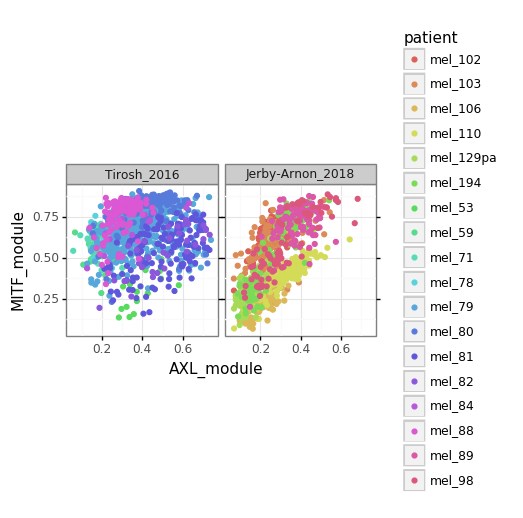

<ggplot: (8744211566063)>


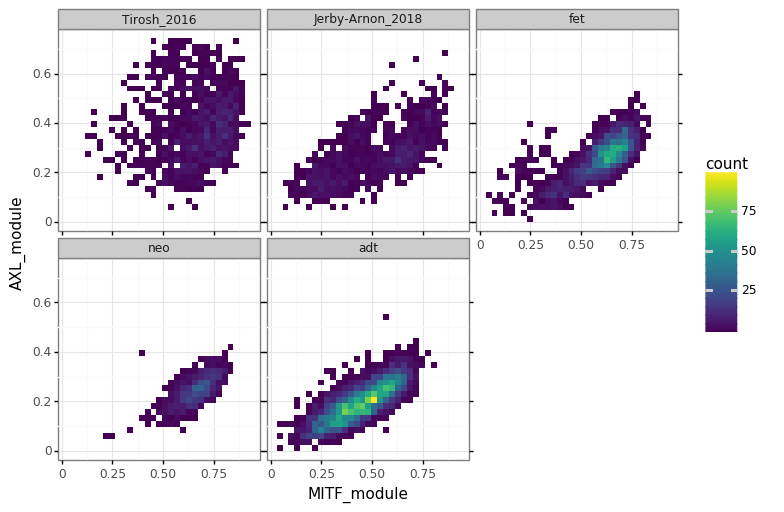

<ggplot: (8744234997501)>


In [46]:
print('computing...')

# select normal cells from trimmed data
indicesOI = adata_subset2.obs.index.tolist() #+ full_adata[full_adata.obs.named_cluster == 'follicular_mel']
input_adata = full_adata[[x in indicesOI for x in full_adata.obs.index]]
groupby = 'dev_stage'
plot_df = input_adata.obs.loc[:, ['AXL_module','MITF_module',groupby]]

melanoma_df = sc_mel_counts.drop(['cancer_patient'], axis=1)
# genesoi = [x for x in set(AXL_module + MITF_module) if x in melanoma_df.columns.tolist()]
# melanoma_df = melanoma_df.loc[:, genesoi]
melanoma_df = melanoma_df.rank(pct=True, axis=1, method = 'min') # ranked expression per cell
# melanoma_df = melanoma_df.rank(pct=True, axis=1, method = 'min') # ranking ranked expression per gene (normalizing contribution of each gene)

# plot scatter
mel_mod_df = pd.DataFrame({'MITF_module':(melanoma_df.loc[:,list(set(MITF_module) & set(melanoma_df.columns))]
                                       .mean(axis=1)
                                       .values),
                         'AXL_module':(melanoma_df.loc[:,list(set(AXL_module) & set(melanoma_df.columns))]
                                       .mean(axis=1)
                                       .values),
                         'patient':patient_values      
                       })
mel_mod_df['AXL_MITF'] = mel_mod_df['AXL_module'] / mel_mod_df['MITF_module']
mel_mod_df['type'] = ['Tirosh_2016' if x in [f'mel_{y}' for y in mel_cell_id] \
                       else 'Jerby-Arnon_2018' for x in mel_mod_df.patient]
mel_mod_df['type'] = (mel_mod_df['type']
                    .astype(str)
                    .astype(CategoricalDtype(['Tirosh_2016', 'Jerby-Arnon_2018'], 
                                             ordered = True))
                     )
mel_mod_df[groupby] = ['Tirosh_2016' if x in [f'mel_{y}' for y in mel_cell_id] \
                       else 'Jerby-Arnon_2018' for x in mel_mod_df.patient]
mel_mod_df[groupby] = (mel_mod_df[groupby]
                    .astype(str)
                    .astype(CategoricalDtype(['Tirosh_2016', 'Jerby-Arnon_2018'], 
                                             ordered = True))
                      )

plotnine.options.figure_size = (4,4)
plot = (ggplot(mel_mod_df)
        + theme_bw()
        + theme(aspect_ratio = 1)
        + geom_point(aes('AXL_module', 'MITF_module', color = 'patient'))
        + facet_wrap(f'~{groupby}', ncol = 2)
       )
print(plot)

plot_df = plot_df.append(mel_mod_df.
                         loc[:,['MITF_module',
                                'AXL_module',
                                groupby]])
plot_df[groupby] = (plot_df[groupby]
                    .astype(str)
                    .astype(CategoricalDtype(['Tirosh_2016', 'Jerby-Arnon_2018']+(input_adata
                                                         .obs[groupby]
                                                         .cat
                                                         .categories
                                                         .tolist()),
                                             ordered = True)))
                                             
plotnine.options.figure_size = (8,8)
plot = (ggplot(plot_df)
        + theme_bw()
        + theme(aspect_ratio = 1)
        + geom_bin2d(aes('MITF_module','AXL_module'))
        + facet_wrap(f'~{groupby}', ncol = 3)
       )
print(plot)


computing...


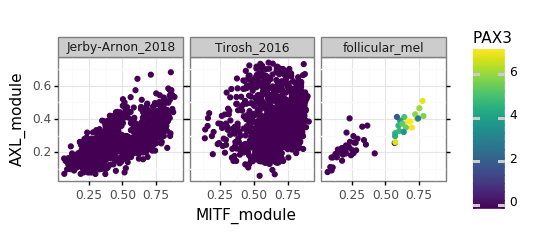

<ggplot: (8744211865885)>


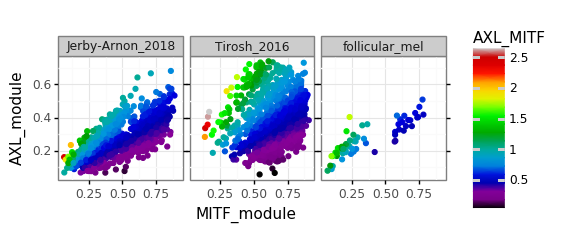

<ggplot: (8744235461324)>


In [47]:
# look up gene expression along axl_mitf
print('computing...')

## possible genes of interest: ref = https://www.cell.com/cell-stem-cell/pdf/S1934-5909(09)00633-X.pdf
GOI = 'PAX3'
groupby = 'class_2'

# select normal cells from trimmed data
indicesOI = full_adata[[x in ['dark_foll_mel','light_foll_mel'] for x in full_adata.obs[groupby]]].obs.index.tolist()
input_adata = full_adata[[x in indicesOI for x in full_adata.obs.index]]

plot_df = input_adata.obs.loc[:, ['AXL_module','MITF_module']]
cat, df = prepare_dataframe(input_adata, GOI, 'cell')
plot_df[GOI] = df.values
plot_df[groupby] = 'follicular_mel'

# merge with cancer data
plot_df = plot_df.append(mel_mod_df
                         .loc[:,['MITF_module','AXL_module','dev_stage']]
                         .rename(columns = {'dev_stage':groupby})
                        )
plot_df['AXL_MITF'] = plot_df['AXL_module']/plot_df['MITF_module']
                                             
plotnine.options.figure_size = (5,5)
plot = (ggplot(plot_df)
        + theme_bw()
        + theme(aspect_ratio = 1)
        + geom_point(aes('MITF_module','AXL_module', color = GOI))
        + facet_wrap(f'~{groupby}', ncol = 4)
       )
print(plot)

plot = (ggplot(plot_df)
        + theme_bw()
        + theme(aspect_ratio = 1)
        + geom_point(aes('MITF_module','AXL_module', color = 'AXL_MITF'))
        + facet_wrap(f'~{groupby}', ncol = 4)
        + scale_color_cmap('nipy_spectral')
       )
print(plot)


##### AXL-MITF ratio density

In [ ]:
print('computing...')

groupby = 'class_3'
color_ref = groupby

input_adata = full_adata[[x in adata_subset2.obs.index for x in full_adata.obs.index]]
norm_mod_df = input_adata.obs.loc[:,['AXL_MITF',groupby]]

mod_df = mel_mod_df.loc[:,['AXL_MITF']]
mod_df[groupby] = 'melanoma'
mod_df = mod_df.append(norm_mod_df)             

ref_order = (mod_df
             .groupby(color_ref)
             .median()
             .sort_values('AXL_MITF')
             .reset_index()
            )
ref_order[color_ref] = (ref_order[color_ref]
                  .astype(str)
                  .astype(CategoricalDtype(ref_order[color_ref].tolist(),ordered = True)))

mod_df[color_ref] = (mod_df[color_ref]
                  .astype(str)
                  .astype(CategoricalDtype(ref_order[color_ref].tolist(),ordered = True)))

plotnine.options.figure_size = (5,5)
plot = (ggplot(mod_df)
        + theme_bw()
        + theme(aspect_ratio = 1/2)
        + geom_vline(ref_order, 
                     aes(xintercept = 'AXL_MITF', color = color_ref))
        + geom_density(aes('AXL_MITF', 
                           fill = color_ref, 
                           color = color_ref), position = 'stack')
#         + facet_grid(f'{color_ref}~.')
       )
plot


computing...


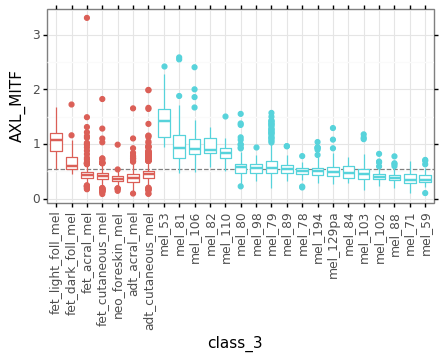

<ggplot: (-9223363292642210139)>

In [48]:
print('computing...')

groupby = 'class_3'
color_ref = groupby

# low grain groups
input_adata = full_adata[[x in adata_subset2.obs.index for x in full_adata.obs.index]]
norm_mod_df = input_adata.obs.loc[:,['AXL_MITF',groupby]]

mod_df = mel_mod_df.loc[:,['AXL_MITF']]
mod_df[groupby] = 'melanoma'
mod_df = mod_df.append(norm_mod_df)    
mod_df['level'] = 0 
mel_median = np.median(mod_df[mod_df[color_ref] == 'melanoma']['AXL_MITF'].values)

# merge low grain + per-sample melanomas
mel_mod_adapted = mel_mod_df.rename(columns = {'patient':'class_3'}).loc[:,['AXL_MITF','class_3']]
mel_mod_adapted['level'] = 1
mod_df = mod_df.append(mel_mod_adapted)

ref_order = (mel_mod_df
             .groupby('patient')
             .median()
             .sort_values('AXL_MITF')
             .reset_index()
            )['patient'].tolist()
mod_df['class_3'] = (mod_df['class_3']
                    .astype(str)
                    .astype(CategoricalDtype([x for x in type_order_3 \
                                              if x in set(mod_df[color_ref])][::-1]+ref_order[::-1], ordered = True)))
mod_df = mod_df.dropna()

plotnine.options.figure_size = (5,5)
plot = (ggplot(mod_df)
        + theme_bw()
        + theme(aspect_ratio = 1/2,
                axis_text_x = element_text(angle = 90),
                legend_position = 'none'
               )
        + geom_hline(aes(yintercept = mel_median), color = 'grey', linetype = '--')
        + geom_boxplot(aes('class_3','AXL_MITF', color = 'factor(level)'))
       )
plot


##### light foll DE genes compared to adt mel

In [ ]:
print('computing...')
target_set = ['fet_dark_foll_mel',
 'fet_light_foll_mel',]
ref_set = ['adt_cutaneous_mel',
 'adt_acral_mel',
 'neo_foreskin_mel',
 'fet_cutaneous_mel',
 'fet_acral_mel',]
source_groupby = 'class_3'
gene_n=100
input_adata = full_adata

input_adata = input_adata[[x in target_set+ref_set for x in input_adata.obs[source_groupby]]]
input_adata.obs['DE_grouping'] = ['target' if x in target_set \
                            else 'ref' \
                            for x in input_adata.obs[source_groupby]]

foll_module = fast_DE(input_adata, clusterOI='target', groupby='DE_grouping', reference='ref', gene_n=gene_n)
set(foll_module) & set(AXL_module)

In [ ]:
print('computing...')
ref_set = ['fet_dark_foll_mel',
 'fet_light_foll_mel',]
target_set = ['adt_cutaneous_mel',
 'adt_acral_mel',
 'neo_foreskin_mel',
 'fet_cutaneous_mel',
 'fet_acral_mel',]
source_groupby = 'class_3'
gene_n=100
input_adata = full_adata

input_adata = input_adata[[x in target_set+ref_set for x in input_adata.obs[source_groupby]]]
input_adata.obs['DE_grouping'] = ['target' if x in target_set \
                            else 'ref' \
                            for x in input_adata.obs[source_groupby]]

all_mel_module = fast_DE(input_adata, clusterOI='target', groupby='DE_grouping', reference='ref', gene_n=gene_n)
set(all_mel_module) & set(MITF_module)

##### per-sample MITF-AXL ratio boxplots

In [ ]:
mel_melt = (pd.melt(mel_mod_df.loc[:,['AXL_MITF','patient','type']], 
                   id_vars=['type', 'patient'])
            .drop('variable', axis =1)
           )

input_adata = full_adata[[x in adata_subset2_trimmed.obs.index for x in full_adata.obs.index]]
norm_mel = (input_adata.obs.loc[:,['AXL_MITF','dev_subtype']]
            .rename(columns = {'AXL_MITF':'value'}))
norm_mel['type'] = 'normal'
norm_mel = norm_mel.rename(columns = {'dev_subtype':'patient'})

norm_fol = (full_adata[full_adata.obs.class_1 == 'msc'].obs.loc[:,['AXL_MITF']]
                .rename(columns = {'AXL_MITF':'value'}))
norm_fol['type'] = 'normal'
norm_fol['patient'] = 'msc'

mel_merge = mel_melt.append(norm_mel).append(norm_fol)

# patient order
mel_order = mel_merge.groupby('patient').median().reset_index()
mel_order = mel_order[[x.startswith('mel_') for x in mel_order.patient]]
mel_order['med_rank'] = mel_order['value'].rank().astype(int)
mel_order = mel_order.sort_values('med_rank')['patient'].tolist()
mel_order_axl_mitf = mel_order
mel_merge['patient'] = (mel_merge['patient']
                          .astype(str)
                          .astype(CategoricalDtype(input_adata.obs.dev_subtype.cat.categories.tolist()[::-1] \
                                                   + ['msc'] \
                                                   + mel_order ,
                                                  ordered = True)))

plotnine.options.figure_size = (3,3)
plot = (ggplot(mel_merge)
         + theme_bw()
         + theme(legend_position = 'none')
         + theme(axis_text_x = element_text(angle = 90))
         + geom_boxplot(aes('patient', 'value', color = 'type'))
         + scale_y_continuous(trans = 'log2')
        )
print(plot)

# jitter plot
plotnine.options.figure_size = (3,3)
plot = (ggplot(mel_merge)
         + theme_bw()
         + theme(legend_position = 'none')
         + theme(axis_text_x = element_text(angle = 90))
         + geom_jitter(aes('patient', 'value', color = 'type'), alpha = 0.1)
         + scale_y_continuous(trans = 'log2')
        )
print(plot)


##### DE dark msc vs light msc

In [ ]:
# print('computing...')

# print_results = True
# run_me = True

# if run_me == True:
#     ## dark msc
#     input_adata = full_adata
#     genes = input_adata.var_names.tolist()
#     cat, prep_slice = prepare_dataframe(input_adata,
#                                          var_names = genes,
#                                          groupby = 'class_2')
#     dark_msc_input = prep_slice[[x == 'msc' for x in prep_slice.index]]

#     ## light msc
#     input_adata = full_adata
#     genes = input_adata.var_names.tolist()
#     cat, prep_slice = prepare_dataframe(input_adata,
#                                          var_names = genes,
#                                          groupby = 'class_2')
#     light_msc_input = prep_slice[[x == 'fibroblast' for x in prep_slice.index]]

#     dark_v_light = pd.DataFrame()
#     for test in ['less','greater']:

#         stat_pval_tuple = parallel_mwu(genes, 
#                                        dark_msc_input,
#                                        light_msc_input,  
#                                        test,
#                                        usable_cores)
#         stat_list = stat_pval_tuple[0]
#         pval_list = stat_pval_tuple[1]
#         diff_df = (pd.DataFrame({'gene':genes,
#                                  'stat_1':stat_list,
#                                  'pval_1':pval_list
#                                 })
#                   )
#         diff_df['test'] = test
#         dark_v_light = dark_v_light.append(diff_df)

#     dark_v_light['log10_pval_1'] = [-np.log10(x) for x in dark_v_light['pval_1']]
#     dark_v_light = dark_v_light.dropna()

# dark_less_light = (dark_v_light[dark_v_light.test == 'less']
#               .sort_values('pval_1')['gene']
#               .tolist()
#              )[:100]

# dark_greater_light = (dark_v_light[dark_v_light.test == 'greater']
#               .sort_values('pval_1')['gene']
#               .tolist()
#              )[:100]

# if print_results == True:
#     display(dark_less_light)
#     display(dark_greater_light)
    

##### melanoma expression on AXL-MITF ordering of samples

In [ ]:
sc.pl.umap(full_adata, color = ['LGALS1'])

In [ ]:
# from geneset, prioritize ranked correlation to axl-mitf ordering

pigment_set = ['DCT','PMEL','MITF','TYR','TYRP1']
mel_set = ['SOX10','PAX3','PLP1','TFAP2A','KIT']
common_set = ['NGFRAP1','ID2']
neural_early_set = ['TGFBI','CLDN11','NRP1','SLIT3','ID3','TCF4']
## CLDN11 = 10.1002/(SICI)1097-4547(20000315)59:6<706::AID-JNR2>3.0.CO;2-D
## TCF4 = 10.1006/bbrc.2000.3090
## NRP1 = 10.1007/978-1-4615-0119-0_4
## SLIT3 = 10.1016/S0896-6273(01)00566-9
## ID2/3 = 10.1002/(SICI)1098-1136(199812)24:4<372::AID-GLIA2>3.0.CO;2-B
## TFAP2A = 10.1016/j.ydbio.2011.09.019
## NGFRAP1 = 10.1523/JNEUROSCI.4646-14.2015
## TGFBI = 10.1016/j.ajpath.2011.12.035

geneset_oi = neural_early_set+common_set+mel_set+pigment_set
# gene_n = 10
# geneset_oi = dark_less_light[:gene_n] + dark_greater_light[:gene_n]

# sc.pl.umap(full_adata, color = geneset_oi, cmap = 'magma')

## look at neural crest geneset
### ranked expression ###
GOI_df = pd.DataFrame(sc_mel_counts
#                       .set_index('cancer_patient')
#                       .rank(pct=True, axis=1)
#                       .reset_index()
                      .groupby('cancer_patient')
                      .mean()
                      .loc[:,geneset_oi]).reset_index()
GOI_df['cancer_patient'] = (GOI_df['cancer_patient']
                              .astype(str)
                              .astype(CategoricalDtype(mel_order_axl_mitf, ordered = True))
                             )
goi_melt = pd.melt(GOI_df, id_vars='cancer_patient')
goi_melt['group'] = ['pigmentation' if x in pigment_set \
                     else 'late_neural_lineage' if x in mel_set+common_set \
                     else 'early_neural_lineage' for x in goi_melt.variable]
goi_melt['group'] = (goi_melt['group']
                     .astype(str)
                     .astype(CategoricalDtype(['early_neural_lineage','late_neural_lineage','pigmentation'], 
                                              ordered=True))
                    )
# goi_melt['group'] = ['light_msc' if x in dark_less_light[:gene_n] \
#                      else 'dark_msc' for x in goi_melt.variable]
# goi_melt['group'] = (goi_melt['group']
#                      .astype(str)
#                      .astype(CategoricalDtype(['light_msc','dark_msc'], ordered=True))
#                     )
goi_melt['variable'] = (goi_melt['variable']
                        .astype(str)
                        .astype(CategoricalDtype(geneset_oi, ordered=True))
                       )

plotnine.options.figure_size = (6,6)
plot=(ggplot(goi_melt)
      + theme_bw()
      + theme(aspect_ratio = 1)
      + theme(axis_text_x = element_text(angle = 90))
      + geom_line(aes('cancer_patient','value', color='variable', group='variable'))
      + facet_wrap('~group')
     )
print('axl_mitf ordering')
print(plot)

# ranked correlation

patient_encode_dict = {}
for idx,x in enumerate(mel_order_axl_mitf):
    patient_encode_dict[x] = idx

input_df = pd.DataFrame(sc_mel_counts.groupby('cancer_patient').mean().loc[:,geneset_oi]).reset_index()
input_df['order'] = [patient_encode_dict.get(x) for x in input_df['cancer_patient']]

rho_list = []
pval_list = []
for gene in tqdm.tqdm(geneset_oi):
    xval = input_df[gene].values
    yval = input_df['order'].values
    rho, pval = stats.spearmanr(xval, yval)
    rho_list = rho_list+[rho]
    pval_list = pval_list+[pval]
results_df = pd.DataFrame({'gene':geneset_oi,
              'rho':rho_list,
              'pval':pval_list
             })
results_df['rho2'] = results_df['rho']**2

display(results_df.sort_values('pval'))


##### DE follicular vs adult melanocyte

In [ ]:
# print('computing...')

# print_results = False
# run_me = False

# if run_me == True:
#     ## adt mel
#     input_adata = adata_subset2_trimmed
#     genes = input_adata.var_names.tolist()
#     cat, prep_slice = prepare_dataframe(input_adata,
#                                          var_names = genes,
#                                          groupby = 'dev_stage')
#     target_input = prep_slice[[x == 'adt' for x in prep_slice.index]]

#     ## follicular mel
#     input_adata = full_adata
#     genes = input_adata.var_names.tolist()
#     cat, prep_slice = prepare_dataframe(input_adata,
#                                          var_names = genes,
#                                          groupby = 'class_2')
#     fol_input = prep_slice[[x == 'fibroblast' for x in prep_slice.index]]

#     target_v_fol_df = pd.DataFrame()
#     for test in ['less','greater']:

#         stat_pval_tuple = parallel_mwu(genes, 
#                                        target_input,
#                                        fol_input,  
#                                        test,
#                                        usable_cores)
#         stat_list = stat_pval_tuple[0]
#         pval_list = stat_pval_tuple[1]
#         diff_df = (pd.DataFrame({'gene':genes,
#                                  'stat_1':stat_list,
#                                  'pval_1':pval_list
#                                 })
#                   )
#         diff_df['test'] = test
#         target_v_fol_df = target_v_fol_df.append(diff_df)

#     target_v_fol_df['log10_pval_1'] = [-np.log10(x) for x in target_v_fol_df['pval_1']]
#     target_v_fol_df = target_v_fol_df.dropna()

# gene_order_less = (target_v_fol_df[target_v_fol_df.test == 'less']
#               .sort_values('pval_1')['gene']
#               .tolist()
#              )[:100]

# gene_order_greater = (target_v_fol_df[target_v_fol_df.test == 'greater']
#               .sort_values('pval_1')['gene']
#               .tolist()
#              )[:100]

# if print_results == True:
#     display(gene_order_greater)
#     display(gene_order_less)
    

##### single cell heatmap of genes along AXL-MITF ordering compared to normal development 

In [ ]:
print('computing...')
# normal cell heatmap

idx_oi = adata_subset2_trimmed.obs.index.tolist() + full_adata[full_adata.obs.class_1 == 'msc'].obs.index.tolist()
input_adata = full_adata[[x in idx_oi for x in full_adata.obs.index]]
n_cells = 100
gene_order = geneset_oi
# gene_n = 20
# gene_order = dark_less_light[:gene_n] + dark_greater_light[:gene_n]

cat, exp_df = prepare_dataframe(input_adata,
                 var_names = gene_order,
                 groupby = 'cell')

exp_df = exp_df.apply(lambda x: min_max_scaler(np.log1p(x).values))
exp_df['class_2'] = input_adata.obs.class_2.tolist()
exp_df['class_2'] = ['dark_msc' if x == 'msc' \
                     else 'light_msc' if x == 'fibroblast' \
                     else x for x in exp_df['class_2']]
exp_df['dev_stage'] = input_adata.obs.dev_stage.tolist()
exp_df['target'] = [f'{x}_{y}' for x,y in zip(exp_df['dev_stage'], exp_df['class_2'])]
targetoi = ['adt_mel','neo_mel','fet_mel','fet_dark_msc','fet_light_msc']
exp_df = exp_df[[x in targetoi for x in exp_df['target']]]

compiled_rows = pd.DataFrame()
type_order_revised = []
for x in targetoi:
    df_slice = exp_df[exp_df.target == x]
    df_nrow = len(df_slice)
    if df_nrow >= n_cells:
        df_sample = df_slice.sample(n_cells)
        num_cell = n_cells
    else:
        df_sample = df_slice
        num_cell = df_nrow
    df_sample['idx'] = [x for x in range(len(df_sample))]
    df_sample['target'] = f'{x} ({num_cell}/{df_nrow})'
    type_order_revised = type_order_revised + [f'{x} ({num_cell}/{df_nrow})']
    compiled_rows = compiled_rows.append(df_sample)
    
compiled_rows_melt = pd.melt(compiled_rows, id_vars=['class_2','idx','target','dev_stage'])
compiled_rows_melt['target'] = (compiled_rows_melt['target']
                                 .astype(str)
                                 .astype(CategoricalDtype(type_order_revised,
                                                          ordered=True
                                                         )
                                        )
                                )
compiled_rows_melt['variable'] = (compiled_rows_melt['variable']
                                 .astype(str)
                                 .astype(CategoricalDtype(gene_order,
                                                          ordered=True
                                                         )
                                        )
                                )

plotnine.options.figure_size = (4,4)
plot = (ggplot(compiled_rows_melt)
      + theme_bw()
      + theme(axis_text_x = element_blank(),
              strip_text_x = element_text(angle = 90, vjust = 0),
              strip_background_x = element_rect(fill = 'white', color = 'white') )
      + geom_tile(aes('idx','variable',fill='value'))
      + facet_grid('~target', scales='free')
      + scale_fill_cmap('magma')
      + labs(x = '', y = ''))

print(plot)

# melanoma heatmap along axl-mitf ordering

n_cells = 100
exp_df = sc_mel_counts.loc[:,gene_order]
exp_df = exp_df.apply(lambda x: min_max_scaler(x.values))
exp_df['cancer_patient'] = sc_mel_counts['cancer_patient'].values
exp_df['cancer_patient'] = (exp_df['cancer_patient']
                              .astype(str)
                              .astype(CategoricalDtype(mel_order_axl_mitf, ordered = True))
                             )

compiled_rows = pd.DataFrame()
type_order_revised = []
for x in mel_order_axl_mitf:
    df_slice = exp_df[exp_df.cancer_patient == x]
    df_nrow = len(df_slice)
    if df_nrow >= n_cells:
        df_sample = df_slice.sample(n_cells)
        num_cell = n_cells
    else:
        df_sample = df_slice
        num_cell = df_nrow
    df_sample['idx'] = [x for x in range(len(df_sample))]
    df_sample['cancer_patient'] = f'{x} ({num_cell}/{df_nrow})'
    type_order_revised = type_order_revised + [f'{x} ({num_cell}/{df_nrow})']
    compiled_rows = compiled_rows.append(df_sample)
    
compiled_rows_melt = pd.melt(compiled_rows, id_vars=['idx','cancer_patient'])
compiled_rows_melt['cancer_patient'] = (compiled_rows_melt['cancer_patient']
                                 .astype(str)
                                 .astype(CategoricalDtype(type_order_revised,
                                                          ordered=True
                                                         )
                                        )
                                )
compiled_rows_melt['variable'] = (compiled_rows_melt['variable']
                                 .astype(str)
                                 .astype(CategoricalDtype(gene_order,
                                                          ordered=True
                                                         )
                                        )
                                )

plotnine.options.figure_size = (10,4)
plot = (ggplot(compiled_rows_melt)
      + theme_bw()
      + theme(axis_text_x = element_blank(),
              strip_text_x = element_text(angle = 90, vjust = 0),
              strip_background_x = element_rect(fill = 'white', color = 'white') )
      + geom_tile(aes('idx','variable',fill='value'))
      + facet_grid('~cancer_patient', scales='free')
      + scale_fill_cmap('magma')
      + labs(x = '', y = ''))

print(plot)


In [ ]:
# # melanoma heatmap along axl-mitf ordering

# print('computing...')
# # prioritize genes
# geneset_oi = dark_less_light[:50]

# patient_encode_dict = {}
# for idx,x in enumerate(mel_order_axl_mitf):
#     patient_encode_dict[x] = idx

# input_df = pd.DataFrame(sc_mel_counts.groupby('cancer_patient').mean().loc[:,geneset_oi]).reset_index()
# input_df['order'] = [patient_encode_dict.get(x) for x in input_df['cancer_patient']]

# rho_list = []
# pval_list = []
# for gene in tqdm.tqdm(geneset_oi):
#     xval = input_df[gene].values
#     yval = input_df['order'].values
#     rho, pval = stats.spearmanr(xval, yval)
#     rho_list = rho_list+[rho]
#     pval_list = pval_list+[pval]
# results_df = pd.DataFrame({'gene':geneset_oi,
#               'rho':rho_list,
#               'pval':pval_list
#              })
# results_df['rho2'] = results_df['rho']**2

# display(results_df.sort_values('pval'))


# # plot heatmap

# input_adata = full_adata
# n_cells = 100
# gene_order = results_df.sort_values('pval').gene.tolist()

# exp_df = sc_mel_counts.loc[:,gene_order]
# exp_df = exp_df.apply(lambda x: min_max_scaler(x.values))
# exp_df['cancer_patient'] = sc_mel_counts['cancer_patient'].values
# exp_df['cancer_patient'] = (exp_df['cancer_patient']
#                               .astype(str)
#                               .astype(CategoricalDtype(mel_order_axl_mitf, ordered = True))
#                              )

# compiled_rows = pd.DataFrame()
# type_order_revised = []
# for x in mel_order_axl_mitf:
#     df_slice = exp_df[exp_df.cancer_patient == x]
#     df_nrow = len(df_slice)
#     if df_nrow >= n_cells:
#         df_sample = df_slice.sample(n_cells)
#         num_cell = n_cells
#     else:
#         df_sample = df_slice
#         num_cell = df_nrow
#     df_sample['idx'] = [x for x in range(len(df_sample))]
#     df_sample['cancer_patient'] = f'{x} ({num_cell}/{df_nrow})'
#     type_order_revised = type_order_revised + [f'{x} ({num_cell}/{df_nrow})']
#     compiled_rows = compiled_rows.append(df_sample)
    
# compiled_rows_melt = pd.melt(compiled_rows, id_vars=['idx','cancer_patient'])
# compiled_rows_melt['cancer_patient'] = (compiled_rows_melt['cancer_patient']
#                                  .astype(str)
#                                  .astype(CategoricalDtype(type_order_revised,
#                                                           ordered=True
#                                                          )
#                                         )
#                                 )
# compiled_rows_melt['variable'] = (compiled_rows_melt['variable']
#                                  .astype(str)
#                                  .astype(CategoricalDtype(gene_order,
#                                                           ordered=True
#                                                          )
#                                         )
#                                 )

# plotnine.options.figure_size = (10,10)
# plot = (ggplot(compiled_rows_melt)
#       + theme_bw()
#       + theme(axis_text_x = element_blank(),
#               strip_text_x = element_text(angle = 90, vjust = 0),
#               strip_background_x = element_rect(fill = 'white', color = 'white') )
#       + geom_tile(aes('idx','variable',fill='value'))
#       + facet_grid('~cancer_patient', scales='free')
#       + scale_fill_cmap('magma')
#       + labs(x = '', y = ''))

# print(plot)

##### (decommissioned) acral signature in melanoma

In [ ]:
# dev_stage = 'adt'
# print(f'{dev_stage} acral (less/greater) than {dev_stage} cutaneous')

# results_less = (fet_v_adt_df
#              .fillna(1)
#              .sort_values('pval_1')
#              .query(f'dev_stage == "{dev_stage}"')
#              .query(f'test == "less"')
#           )
# results_greater = (fet_v_adt_df
#              .fillna(1)
#              .sort_values('pval_1')
#              .query(f'dev_stage == "{dev_stage}"')
#              .query(f'test == "greater"')
#           )


In [ ]:
# # select normal cells from trimmed data
# indicesOI = adata_subset2_trimmed.obs.index.tolist() #+ full_adata[full_adata.obs.named_cluster == 'follicular_mel']
# input_adata = full_adata[[x in indicesOI for x in full_adata.obs.index]]
# groupby = 'dev_stage'

# melanoma_df = sc_mel_counts.drop(['cancer_patient'], axis=1)
# genesoi = [x for x in set(AXL_module + MITF_module) if x in melanoma_df.columns.tolist()]
# melanoma_df = melanoma_df.loc[:, genesoi]
# melanoma_df = melanoma_df.rank(pct=True, axis=0, method = 'min') # ranked expression per cell
# melanoma_df = melanoma_df.rank(pct=True, axis=1, method = 'min') # ranking ranked expression per gene (normalizing contribution of each gene)

# # plot scatter
# mel_mod_df = pd.DataFrame({'HPGD_module':(melanoma_df.loc[:,[x for x in set(results_less.head(100).gene.tolist()) if x in melanoma_df.columns.tolist()]]
#                                        .mean(axis=1)
#                                        .values),
#                          'NTRK2_module':(melanoma_df.loc[:,[x for x in set(results_greater.head(100).gene.tolist()) if x in melanoma_df.columns.tolist()]]
#                                        .mean(axis=1)
#                                        .values),
#                          'patient':patient_values      
#                        })
# mel_mod_df['NTRK2_HPGD'] = mel_mod_df['NTRK2_module'] / mel_mod_df['HPGD_module']
# mel_mod_df['type'] = ['Tirosh_2016' if x in [f'mel_{y}' for y in mel_cell_id] \
#                        else 'Jerby-Arnon_2018' for x in mel_mod_df.patient]
# mel_mod_df['type'] = (mel_mod_df['type']
#                     .astype(str)
#                     .astype(CategoricalDtype(['Tirosh_2016', 'Jerby-Arnon_2018'], 
#                                              ordered = True))
#                      )
# mel_mod_df[groupby] = ['Tirosh_2016' if x in [f'mel_{y}' for y in mel_cell_id] \
#                        else 'Jerby-Arnon_2018' for x in mel_mod_df.patient]
# mel_mod_df[groupby] = (mel_mod_df[groupby]
#                     .astype(str)
#                     .astype(CategoricalDtype(['Tirosh_2016', 'Jerby-Arnon_2018'], 
#                                              ordered = True))
#                       )

# plotnine.options.figure_size = (3,3)
# plot = (ggplot(mel_mod_df)
#          + theme_bw()
#          + theme(legend_position = 'none')
#          + theme(axis_text_x = element_text(angle = 90))
#          + geom_boxplot(aes('patient', 'NTRK2_HPGD', color = 'type'), alpha = 0.1)
#          + scale_y_continuous(trans = 'log2')
#         )
# print(plot)

# plotnine.options.figure_size = (3,3)
# plot = (ggplot(mel_mod_df)
#          + theme_bw()
#          + theme(legend_position = 'none')
#          + theme(axis_text_x = element_text(angle = 90))
#          + geom_jitter(aes('patient', 'NTRK2_HPGD', color = 'type'), alpha = 0.1)
#          + scale_y_continuous(trans = 'log2')
#         )
# print(plot)

# sc_mel_counts[sc_mel_counts.cancer_patient == 'mel_84'].loc[:,['NTRK2','HPGD']]


##### (decommissioned) pair-wise cancer sample linear regression

In [ ]:
# ref1 = 'mel_53'
# ref2 = 'mel_71'
# n_print = 10
# glist = gene_order_less

# mean_df = sc_mel_counts.groupby('cancer_patient').mean()
# # only genes in module
# mean_df = mean_df.loc[:,glist].T.dropna()

# ref1_vec = mean_df[ref1].values.reshape(-1, 1)
# ref2_vec = mean_df[ref2].values.reshape(-1, 1)

# y_predicted, y_residuals = regress(ref1_vec, ref2_vec, intercept = False)

# plot_df = pd.DataFrame({ref1:ref1_vec.flatten(),
#                         ref2:ref2_vec.flatten(),
#                         'fitted':y_predicted.flatten(),
#                         'resid':y_residuals.flatten()
#                        })
# plot_df['group'] = 'group'
# plot_df['sq_resid'] = plot_df['resid'] ** 2
# plot_df['norm_resid'] = plot_df['resid']/plot_df['fitted']
# plot_df['gene'] = mean_df.index.values

# plot_df_slice = plot_df[plot_df.norm_resid < 0].sort_values('sq_resid', ascending=False).head(n_print)
# plot_df_slice['idx'] = [x for x in range(len(plot_df_slice))]
# plot_df_slice = plot_df_slice.sort_values('sq_resid', ascending=False)

# plotnine.options.figure_size = (3,3)
# print(ggplot(plot_df)
#       + theme_bw()
#       + geom_point(aes(ref1, ref2), alpha = 0.1)
#       + geom_line(aes(ref1, 'fitted', group='group'), color = 'red')
#       + geom_label(plot_df_slice, 
#                   aes(ref1, ref2, label = 'idx'), color = 'red', size = 7)
# #       + scale_y_log10()
# #       + scale_x_log10()
#      )
# display(plot_df_slice)
# gene=plot_df_slice.gene.tolist()
# out = symbol2field(gene)
# output = [print(f'{idx}: ', 
#        x['query'],
#        '\n',x['summary']) if ('summary' in x.keys()) else print(f'{idx}: ', 
#                                                                 x['query'],
#                                                                 '\n','N/A') for idx, x in enumerate(out)]


#### Follicular melanocyte and melanoma connection
- composed of only fetal samples

##### Calculate FOLL-ADT melanocyte ratio

In [ ]:
print('computing...')
input_adata = full_adata
modules_dict = {'all_mel_module':all_mel_module,
                'foll_module':foll_module,
               }

input_adata.obs['cell'] = input_adata.obs.index.tolist()
input_adata.obs['cell'] = (input_adata
                          .obs['cell']
                          .astype(str)
                          .astype(CategoricalDtype(input_adata.obs['cell'].tolist())))
cat, exp_df = prepare_dataframe(input_adata,
                 var_names = input_adata.var_names,
                 groupby = 'cell')
exp_df = exp_df.rank(pct=True, axis=1, method = 'min') # ranked expression per cell
# exp_df = exp_df.rank(pct=True, axis=1, method = 'min') # ranking ranked expression per gene (normalizing contribution of each gene)

for key,value in modules_dict.items():
    input_adata.obs[key] = exp_df.loc[:,value].mean(axis=1)
#     sc.pl.umap(input_adata, color=[key], cmap = 'magma', palette = 'tab20')

input_adata.obs['foll_all'] = input_adata.obs['foll_module']/input_adata.obs['all_mel_module']
sc.pl.umap(input_adata, color=['foll_adt'], 
           cmap = 'nipy_spectral', palette = 'tab20')


##### per-sample follicular-adult melanocyte ratio boxplots

In [ ]:
print('computing...')

groupby = 'class_3'
color_ref = groupby

# ingest and comput
melanoma_df = sc_mel_counts.drop(['cancer_patient'], axis=1)
melanoma_df = melanoma_df.rank(pct=True, axis=1, method = 'min') # ranked expression per cell
mel_mod_df = pd.DataFrame({'all_mel_module':(melanoma_df.loc[:, list(set(all_mel_module) & set(melanoma_df.columns))]
                                       .mean(axis=1)
                                       .values),
                         'foll_module':(melanoma_df.loc[:, list(set(foll_module) & set(melanoma_df.columns))]
                                       .mean(axis=1)
                                       .values),
                         'patient':patient_values,
                         'cell_id':cell_id
                         })
mel_mod_df['foll_all'] = mel_mod_df['foll_module'] / mel_mod_df['all_mel_module']

# low grain groups
input_adata = full_adata[[x in adata_subset2.obs.index for x in full_adata.obs.index]]
norm_mod_df = input_adata.obs.loc[:,['foll_all',groupby]]

mod_df = mel_mod_df.loc[:,['foll_all']]
mod_df[groupby] = 'melanoma'
mod_df = mod_df.append(norm_mod_df)    
mod_df['level'] = 0 
mel_median = np.median(mod_df[mod_df[color_ref] == 'melanoma']['foll_all'].values)

# merge low grain + per-sample melanomas
mel_mod_adapted = mel_mod_df.rename(columns = {'patient':'class_3'}).loc[:,['foll_all','class_3']]
mel_mod_adapted['level'] = 1
mod_df = mod_df.append(mel_mod_adapted)

ref_order = (mel_mod_df
             .groupby('patient')
             .median()
             .sort_values('foll_all')
             .reset_index()
            )['patient'].tolist()
mod_df['class_3'] = (mod_df['class_3']
                    .astype(str)
                    .astype(CategoricalDtype([x for x in type_order_3 \
                                              if x in set(mod_df[color_ref])][::-1]+ref_order[::-1], ordered = True)))
mod_df = mod_df.dropna()

plotnine.options.figure_size = (5,5)
plot = (ggplot(mod_df)
        + theme_bw()
        + theme(aspect_ratio = 1/2,
                axis_text_x = element_text(angle = 90),
                legend_position = 'none'
               )
        + geom_hline(aes(yintercept = mel_median), color = 'grey', linetype = '--')
        + geom_boxplot(aes('class_3','foll_all', color = 'factor(level)'))
        + scale_y_continuous(trans='log2')
       )
plot

# plotnine.options.figure_size = (3,3)
# plot = (ggplot(mel_merge)
#          + theme_bw()
#          + theme(legend_position = 'none')
#          + theme(axis_text_x = element_text(angle = 90))
#          + geom_boxplot(aes('patient', 'value', color = 'type'))
#          + scale_y_continuous(trans = 'log2')
#         )
# print(plot)

# plotnine.options.figure_size = (3,3)
# plot = (ggplot(mel_merge)
#          + theme_bw()
#          + theme(legend_position = 'none')
#          + theme(axis_text_x = element_text(angle = 90))
#          + geom_jitter(aes('patient', 'value', color = 'type'), alpha = 0.1)
#          + scale_y_continuous(trans = 'log2')
#         )
# print(plot)


##### axl_mitf vs foll_adt scatter

In [ ]:
print('computing...')
melanoma_df = sc_mel_counts.drop(['cancer_patient'], axis=1)
melanoma_df = melanoma_df.rank(pct=True, axis=1, method = 'min') # ranked expression per cell
mel_mod_df = pd.DataFrame({'all_mel_module':(melanoma_df.loc[:, list(set(all_mel_module) & set(melanoma_df.columns))]
                                       .mean(axis=1)
                                       .values),
                         'foll_module':(melanoma_df.loc[:, list(set(foll_module) & set(melanoma_df.columns))]
                                       .mean(axis=1)
                                       .values),
                         'MITF_module':(melanoma_df.loc[:, list(set(MITF_module) & set(melanoma_df.columns))]
                                       .mean(axis=1)
                                       .values),
                         'AXL_module':(melanoma_df.loc[:, list(set(AXL_module) & set(melanoma_df.columns))]
                                       .mean(axis=1)
                                       .values),
                         'patient':patient_values,
                         'cell_id':cell_id
                         })
mel_mod_df['foll_all'] = mel_mod_df['foll_module'] / mel_mod_df['all_mel_module']
mel_mod_df['axl_mitf'] = mel_mod_df['AXL_module'] / mel_mod_df['MITF_module']

mel_mod_df['type'] = 'cancer'
mel_mod_df[groupby] = 'cancer'

# append metadata
plot_input = pd.merge(mel_mod_df, 
                     (mel_anno_df2
                      .loc[:,['tumor','treatment', 'Immune_resistance',
       'Immune_resistance.up', 'Immune_resistance.down',
       'OE.Immune_resistance', 'OE.Immune_resistance.up',
       'OE.Immune_resistance.down', 'no.genes']]
                      .reset_index()
                      .rename(columns = {'NAME':'cell_id'})),
                      'left',
                      'cell_id')

plotnine.options.figure_size = (3,3)
plot = (ggplot(plot_input)
        + theme_bw()
        + theme(aspect_ratio = 1)
        + geom_bin2d(aes('axl_mitf','foll_all'))
#         + scale_x_continuous(trans = 'log2')
#         + scale_y_continuous(trans = 'log2')
       )
print(plot)

plotnine.options.figure_size = (6,6)
plot = (ggplot(plot_input)
        + theme_bw()
        + theme(aspect_ratio = 1)
        + geom_point(aes('axl_mitf','foll_all',color='Immune_resistance'), alpha = 0.1)
#         + scale_x_continuous(trans = 'log2')
#         + scale_y_continuous(trans = 'log2')
        + facet_wrap('~Immune_resistance')
       )
print(plot)

print('computing...')

plot_input['OE.Immune_resistance'] = plot_input['OE.Immune_resistance'].astype(float)
plot_input_melt = pd.melt(plot_input.dropna().loc[:,['Immune_resistance', 'treatment',
                                                     'foll_all','axl_mitf','OE.Immune_resistance']],
                          id_vars=['treatment','Immune_resistance'])
plot_input_melt.head()

plotnine.options.figure_size = (4,4)
plot = (ggplot(plot_input_melt)
        + theme_bw()
        + theme(axis_text_x = element_text(angle = 90),
                panel_spacing = 0.2
               )
        + theme(aspect_ratio = 1)
        + geom_boxplot(aes('variable','value', color='Immune_resistance'), alpha = 0.2)
#         + scale_x_continuous(trans = 'log2')
#         + scale_y_continuous(trans = 'log2')
        + facet_grid('variable~treatment', scales = 'free')
       )
print(plot)

print('computing...')

plot_input_melt = pd.melt(plot_input.dropna().loc[:,['foll_all','axl_mitf','OE.Immune_resistance']],
                          id_vars=['OE.Immune_resistance'])
plot_input_melt.head()

plotnine.options.figure_size = (4,4)
plot = (ggplot(plot_input_melt)
        + theme_bw()
        + theme(axis_text_x = element_text(angle = 90),
                panel_spacing = 0.2
               )
        + theme(aspect_ratio = 1)
        + geom_point(aes('value','OE.Immune_resistance', color = 'variable'), alpha = 0.2)
#         + scale_x_continuous(trans = 'log2')
#         + scale_y_continuous(trans = 'log2')
        + facet_grid('~variable', scales = 'free')
       )
print(plot)




##### Comparison of module scores with tumor resampling 

In [ ]:
print('computing...')

# read in pre-post transcriptome is respect to foll_adt
pre_post_T = (pd.read_csv('s3://daniel.le-work/MEL_project/pre_post_melanoma.csv')
             .drop('Name', axis=1)
             .rename(columns = {'Gene Symbol':'gene'})
              .set_index('gene')
              .T
             )
# genesoi = [x for x in set(gene_order_greater + gene_order_less + \
#                           MITF_module + AXL_module) if x in pre_post_T.columns.tolist()]
# pre_post_T = pre_post_T.loc[:, genesoi]
pre_post_T = pre_post_T.rank(pct=True, axis=1, method = 'min') # ranked expression per cell
# pre_post_T = pre_post_T.rank(pct=True, axis=1, method = 'min') # ranking ranked expression per gene (normalizing contribution of each gene)


pre_post_mod = pd.DataFrame({'all_mel_module':(pre_post_T.loc[:, list(set(all_mel_module) & set(pre_post_T.columns))]
                                       .mean(axis=1)
                                       .values),
                         'foll_module':(pre_post_T.loc[:, list(set(foll_module) & set(pre_post_T.columns))]
                                       .mean(axis=1)
                                       .values),
                             'MITF_module':(pre_post_T.loc[:, list(set(MITF_module) & set(pre_post_T.columns))]
                                       .mean(axis=1)
                                       .values),
                         'AXL_module':(pre_post_T.loc[:, list(set(AXL_module) & set(pre_post_T.columns))]
                                       .mean(axis=1)
                                       .values),
                         'patient':pre_post_T.index.tolist()      
                       })
pre_post_mod['foll_all'] = pre_post_mod['foll_module'] / pre_post_mod['all_mel_module']
pre_post_mod['axl_mitf'] = pre_post_mod['AXL_module'] / pre_post_mod['MITF_module']

pre_post_mod['type'] = 'cancer'
pre_post_mod[groupby] = 'cancer'

plot_df = pd.melt(pre_post_mod.loc[:,['patient','axl_mitf','foll_all']], id_vars='patient')
plot_df['patient_id'] = [x.split('Patient ')[-1].split(' ')[0] for x in plot_df.patient]
plot_df['treatment'] = [x.split('Patient ')[-1].split(' ')[-1].split('-')[0] for x in plot_df.patient]
plot_df['treatment'] = (plot_df['treatment']
                        .astype(str)
                        .astype(CategoricalDtype(['Pre','Post'], ordered = True))
                       )

# append metadata
pre_post_meta = pd.DataFrame({'patient_id':[1,2,3,4,5,6],
                              'response':[-100,-20,-51,-42,-53,-23],
                              'PFS':[18,10,5,3,2,2]
                             })
pre_post_meta['patient_id'] = pre_post_meta['patient_id'].astype(str)

plot_df = pd.merge(plot_df, pre_post_meta, 'left', 'patient_id')

plotnine.options.figure_size = (4,4)
plot1 = (ggplot(plot_df)
 + theme_bw()
 + theme(axis_text_x = element_text(angle = 90),
         panel_spacing = 0.5,
         aspect_ratio = 1
        )
 + geom_bar(aes('patient_id','value',fill='treatment'),stat='identity', position='dodge')
 + facet_wrap('~variable', scales = 'free')
)
print(plot1)

plotnine.options.figure_size = (2,2)
plot2 = (ggplot(plot_df)
         + theme_bw()
         + geom_point(aes('patient_id','response'))
         + geom_line(aes('patient_id','response', group='variable'))
        )
plot3 = (ggplot(plot_df)
         + theme_bw()
         + geom_point(aes('patient_id','PFS'))
         + geom_line(aes('patient_id','PFS', group='variable'))
        )

print(plot2, plot3)

# module cross analysis
plot2d = plot_df.pivot(index='patient', columns='variable', values = 'value').reset_index()
plot2d = pd.merge(plot2d, plot_df[plot_df.variable == 'axl_mitf'].drop('variable', axis=1), 'left', 'patient')

plotnine.options.figure_size = (4,4)
plot = (ggplot(plot2d)
        + theme_bw()
        + theme(aspect_ratio = 1,
                panel_spacing = 0.4
               )
        + geom_point(aes('axl_mitf','foll_all', color = 'PFS'))
        + facet_wrap('~treatment', scales='free')
       )
print(plot)

plot = (ggplot(plot2d)
        + theme_bw()
        + theme(aspect_ratio = 1,
                panel_spacing = 0.4
               )
        + geom_point(aes('axl_mitf','foll_all', color = 'response'))
        + facet_wrap('~treatment', scales='free')
       )
print(plot)


##### all mels vs melanoma linear regression

computing...


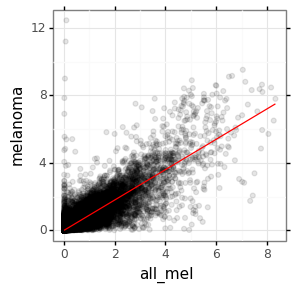

<ggplot: (-9223363292366674870)>


,all_mel,melanoma,fitted,resid,group,sq_resid,norm_resid,gene,label,idx
11750,0.091210,12.451163,0.082031,12.369131,group,152.995412,150.785739,MTRNR2L2,False,0
11756,0.062605,11.193003,0.056304,11.136699,group,124.026063,197.794578,MTRNR2L8,False,1
11748,0.035095,8.996259,0.031563,8.964696,group,80.365778,284.024953,MTRNR2L1,False,2
11749,0.011387,7.846506,0.010241,7.836265,group,61.407055,765.209716,MTRNR2L10,False,3
11754,0.010230,6.906282,0.009200,6.897082,group,47.569738,749.674369,MTRNR2L6,False,4


In [73]:
print('computing...')

n_print = 5
ref1 = 'all_mel'
ref2 = 'melanoma'
GOI = 'MITF'

cat, df = prepare_dataframe(adata_subset2, 
                                 adata_subset2.var_names,
                                 'cell'
                                )

compare_df = pd.merge(sc_mel_counts.mean().reset_index().rename(columns = {'index':'gene', 0:'melanoma'}), 
                      df.mean().T.reset_index().rename(columns={'index':'gene', 0:'all_mel'}), 
                      'inner', 'gene')
ref1_vec = compare_df[ref1].values.reshape(-1, 1)
ref2_vec = compare_df[ref2].values.reshape(-1, 1)

y_predicted, y_residuals = regress(ref1_vec, ref2_vec, fit_intercept=False)

plot_df = pd.DataFrame({ref1:ref1_vec.flatten(),
                        ref2:ref2_vec.flatten(),
                        'fitted':y_predicted.flatten(),
                        'resid':y_residuals.flatten()
                       })
plot_df['group'] = 'group'
plot_df['sq_resid'] = plot_df['resid'] ** 2
plot_df['norm_resid'] = plot_df['resid']/plot_df['fitted']
plot_df['gene'] = compare_df.gene.values
plot_df['label'] = [x == GOI for x in plot_df.gene]

plot_df_slice = plot_df[plot_df.norm_resid > 0].sort_values('sq_resid', ascending=False).head(n_print)
plot_df_slice['idx'] = [x for x in range(len(plot_df_slice))]
plot_df_slice = plot_df_slice.sort_values('sq_resid', ascending=False)

plotnine.options.figure_size = (3,3)
print(ggplot(plot_df)
      + theme_bw()
      + geom_point(aes(ref1, ref2), alpha = 0.1)
#       + geom_point(plot_df[plot_df.label == True], aes(ref1, ref2), color = 'blue')
      + geom_line(aes(ref1, 'fitted', group='group'), color = 'red')
#       + geom_label(plot_df_slice, 
#                   aes(ref1, ref2, label = 'idx'), color = 'red', size = 7)
#       + scale_y_log10()
#       + scale_x_log10()
     )
display(plot_df_slice)


#### Re-activated fetal expression in melanoma

##### Identify top fetal-specific genes

In [ ]:
gene_n = 50
cell_type = 'mel'
# cell_type = 'krt'
# test_type = 'fetal greater than adult'
test_type = 'fetal greater than adult'
clust_dict = {'fetal less than adult':5,
              'fetal greater than adult':3
             }
n_clust = clust_dict.get(test_type)

results = (adt_v_fet_DE[[x == cell_type and y == test_type for x,y in zip(adt_v_fet_DE.cell_type, adt_v_fet_DE.test)]]
             .sort_values('pval_1')
            )
# display(results.head(gene_n))

gene_order = results.gene.tolist()[:gene_n]
input_adata = full_adata
n_cells = 100
groupby = 'class_stage'
input_adata.obs[groupby] = [f'{x}_{y}' for x,y in zip(input_adata.obs['class_1'],input_adata.obs['dev_stage'])]

type_order = ['mel_fet','mel_adt','krt_fet','krt_adt','eccrine_fet','eccrine_adt']

cat, exp_df = prepare_dataframe(input_adata,
                 var_names = gene_order,
                 groupby = 'cell')

exp_df = exp_df.apply(lambda x: min_max_scaler(np.log1p(x).values))
exp_df[groupby] = input_adata.obs[groupby].tolist()

compiled_rows = pd.DataFrame()
type_order_revised = []
for x in type_order:
    df_slice = exp_df[exp_df[groupby] == x]
    df_nrow = len(df_slice)
    if df_nrow >= n_cells:
        df_sample = df_slice.sample(n_cells)
        num_cell = n_cells
    else:
        df_sample = df_slice
        num_cell = df_nrow
    df_sample['idx'] = [x for x in range(len(df_sample))]
    df_sample[groupby] = f'{x} ({num_cell}/{df_nrow})'
    type_order_revised = type_order_revised + [f'{x} ({num_cell}/{df_nrow})']
    compiled_rows = compiled_rows.append(df_sample)

compiled_rows_melt = pd.melt(compiled_rows, id_vars=[groupby,'idx'])
compiled_rows_melt[groupby] = (compiled_rows_melt[groupby]
                                 .astype(str)
                                 .astype(CategoricalDtype(type_order_revised,
                                                          ordered=True
                                                         )
                                        )
                                )
compiled_rows_melt['variable'] = (compiled_rows_melt['variable']
                                 .astype(str)
                                 .astype(CategoricalDtype(gene_order,
                                                          ordered=True
                                                         )
                                        )
                                )

plotnine.options.figure_size = (7,7)
plot = (ggplot(compiled_rows_melt[[x.startswith('mel') for x in compiled_rows_melt.class_stage]])
      + theme_bw()
      + theme(axis_text_x = element_blank(),
              strip_text_x = element_text(angle = 90, vjust = 0),
              strip_background_x = element_rect(fill = 'white', color = 'white') )
      + geom_tile(aes('idx','variable',fill='value'))
      + facet_grid(f'~{groupby}', scales='free')
      + scale_fill_cmap('magma')
      + labs(x = '', y = ''))

print(plot)


##### Identify subset of fetal-specific genes that are reactivated in melanoma

In [ ]:
# n_print = 20
ref1 = 'melanoma'
ref2 = 'adt'

cat, primary_df = prepare_dataframe(adata_subset2_trimmed, adata_subset2_trimmed.var_names, 'dev_stage')
primary_df = primary_df.reset_index()
primary_df = primary_df[primary_df.dev_stage == 'adt'].drop('dev_stage', axis = 1).reset_index()
primary_df = primary_df.mean().reset_index().rename(columns = {0:'adt'})

compare_df = pd.merge(pd.DataFrame(sc_mel_counts.mean()).reset_index().rename(columns = {0:'melanoma'}), 
                      primary_df, 
                      'inner', 'index')
ref1_vec = compare_df[ref1].values.reshape(-1, 1)
ref2_vec = compare_df[ref2].values.reshape(-1, 1)

y_predicted, y_residuals = regress(ref1_vec, ref2_vec)

plot_df = pd.DataFrame({ref1:ref1_vec.flatten(),
                        ref2:ref2_vec.flatten(),
                        'fitted':y_predicted.flatten(),
                        'resid':y_residuals.flatten()
                       })
plot_df['group'] = 'group'
plot_df['sq_resid'] = plot_df['resid'] ** 2
plot_df['norm_resid'] = plot_df['resid']/plot_df['fitted']
plot_df['gene'] = compare_df['index'].values
plot_df['pass'] = [x in gene_order for x in plot_df['gene']]

plot_df_slice = (plot_df[[x == True and y < 0 and z > 2 for \
                          x,y,z in zip(plot_df['pass'],
                                     plot_df['norm_resid'],
                                     plot_df['sq_resid']
                                    )]]
                 .sort_values('norm_resid',ascending = True)
#                  .head(n_print)
                )
plot_df_slice['idx'] = [x for x in range(len(plot_df_slice))]

plotnine.options.figure_size = (3,3)
print(ggplot(plot_df)
      + theme_bw()
      + geom_point(aes(ref1, ref2), alpha = 0.1)
      + geom_line(aes(ref1, 'fitted', group='group'), color = 'red')
      + geom_label(plot_df_slice, 
                  aes(ref1, ref2, label = 'idx'), color = 'red', size = 7)
#       + scale_y_log10()
#       + scale_x_log10()
     )
display(plot_df_slice)


#### DEV: scRNA-seq melanoma by patient

In [ ]:
# melt
sc_mel_counts_melt = pd.melt(sc_mel_counts, id_vars='cancer_patient')
sc_mel_counts_melt['GOI'] = [x.startswith('MTRNR') for x in sc_mel_counts_melt['variable']]

# random sample non-target genes
gois = sc_mel_counts_melt[sc_mel_counts_melt.GOI == True]
non_gois = sc_mel_counts_melt[sc_mel_counts_melt.GOI == False].sample(len(gois))
combined_gois = gois.append(non_gois)
combined_gois['label'] = [x if x.startswith('MTRNR') else 'non-MTRNR' for x in combined_gois['variable']]

plotnine.options.figure_size = (6,6)
plot = (ggplot(combined_gois)
        + theme_bw()
        + theme(panel_spacing_x = 0.5)
#         + geom_boxplot(aes('GOI','value'))
        + geom_jitter(aes('GOI','value', color = 'label'))
        + facet_wrap('~cancer_patient')
       )
print(plot)


In [ ]:
# same analysis as above in normal mels
input_adata = adata_subset2_trimmed
groupby = 'patient'
cat, norm_df = prepare_dataframe(input_adata,
                                 input_adata.var_names,
                                 groupby
                                )
norm_df = norm_df.reset_index()
norm_melt = pd.melt(norm_df, id_vars='patient')
norm_melt['GOI'] = [x.startswith('MTRNR') for x in norm_melt.variable]

gois = norm_melt[norm_melt.GOI == True]
non_gois = norm_melt[norm_melt.GOI == False].sample(len(gois))
combined_gois = gois.append(non_gois)
combined_gois['label'] = [x if x.startswith('MTRNR') else 'non-MTRNR' for x in combined_gois['variable']]

plotnine.options.figure_size = (8,8)
plot = (ggplot(combined_gois)
        + theme_bw()
        + theme(panel_spacing_x = 0.5)
#         + geom_boxplot(aes('GOI','value'))
        + geom_jitter(aes('GOI','value', color = 'label'), alpha = 0.1)
        + facet_wrap('~patient')
       )
print(plot)

#### DEV: TCGA correlations

##### preprocess TCGA

In [15]:
print('computing...')

run_me = True
# melanoma files
counts_table = 's3://daniel.le-work/MEL_project/TCGA-SKCM.htseq_fpkm-uq.tsv'
clinical_outcomes = 's3://daniel.le-work/MEL_project/tcga_metadata.csv'
gene_conversion = 's3://daniel.le-work/MEL_project/gencode.v22.annotation.gene.probeMap'
group = 'skcm'

wkdir, s3dir = '/home/ubuntu/data/DL20181011_melanocyte_test_data', 'daniel.le-work/MEL_project'
subdir = f'{wkdir}/tcga_{group}/'
fn_dict = {'tcga_df_fltr':f'/home/ubuntu/data/DL20181011_melanocyte_test_data/tcga_{group}_counts.csv',
               'tcga_meta_ordered':f'/home/ubuntu/data/DL20181011_melanocyte_test_data/tcga_{group}_metadata.csv'
              }

if run_me == True:

    # Protocol:
        # download counts table: https://gdc.xenahubs.net/download/TCGA-SKCM/Xena_Matrices/TCGA-SKCM.htseq_fpkm-uq.tsv.gz
        # gunzip file
        # push to s3: s3://daniel.le-work/MEL_project/TCGA-SKCM.htseq_fpkm-uq.tsv
        
    import json, os, glob, tqdm, mygene
    import pandas as pd



    # ingest counts table
    tcga_df = pd.read_csv(counts_table, sep = '\t').rename(columns = {'Ensembl_ID':'id'})

    # ingest ensembl to symbol conversion table
    ens2sym_df = (pd.read_csv(gene_conversion, sep = '\t', index_col = 0)
                  .reset_index()
                  .loc[:,['gene','id']]
                 )

    # merge symbols and drop ensembl and multi-loci genes
    tcga_df = (pd.merge(tcga_df, ens2sym_df, 'left', 'id')
               .drop('id', axis = 1)
               .dropna()
               .set_index('gene')
              )
    tcga_df[~tcga_df.index.duplicated(False)]
    
    # transpose and create bcr column
    tcga_df_fltr = tcga_df.T.reset_index().rename(columns = {'index':'submitter_id'})
    tcga_df_fltr['bcr_patient_barcode'] = ['-'.join(x.split('-')[:3]) for x in tcga_df_fltr['submitter_id']]

    # align metadata
    ## ref = https://www.sciencedirect.com/science/article/pii/S0092867418302290#mmc1
    tcga_meta = pd.read_csv(clinical_outcomes,index_col=0)
    tcga_meta_ordered = pd.merge(tcga_df_fltr.loc[:,'bcr_patient_barcode'],
                                     tcga_meta,
                                     'left',
                                     'bcr_patient_barcode'
                                    )
    # drop duplicate records
    tcga_meta_ordered = tcga_meta_ordered[~tcga_meta_ordered.bcr_patient_barcode.duplicated('first')]
    
    # append primary vs secondary site
    origin_filter = pd.read_csv('s3://daniel.le-work/MEL_project/tissue_origin.csv')
    origin_filter = origin_filter[~origin_filter.submitter_id.duplicated('first')]
    origin_filter['site'] = ['primary' if x.lower().find('skin') != -1 else 'secondary' \
                         for x in origin_filter.tissue_origin.tolist()]
    origin_filter['bcr_patient_barcode'] = ['-'.join(x.split('-')[:3]) for x in origin_filter['submitter_id']]
    tcga_meta_ordered = pd.merge(tcga_meta_ordered,
                                 origin_filter.loc[:,['site','bcr_patient_barcode']],
                                 'left',
                                 'bcr_patient_barcode'
                                )

    # write dfs to csv and push to s3
    print('computing...')
    tcga_df_fltr = tcga_df_fltr.drop('bcr_patient_barcode', axis = 1).set_index('submitter_id').T
    for key,value in fn_dict.items():
        eval(key).to_csv(value)
        ! aws s3 cp {value} s3://{s3dir}/
        

computing...
computing...
upload: ../../data/DL20181011_melanocyte_test_data/tcga_skcm_counts.csv to s3://daniel.le-work/MEL_project/tcga_skcm_counts.csv
upload: ../../data/DL20181011_melanocyte_test_data/tcga_skcm_metadata.csv to s3://daniel.le-work/MEL_project/tcga_skcm_metadata.csv


##### ingest counts

In [19]:
print('computing...')
primary_only = False

# pull tables from s3
for key,value in fn_dict.items():
    value_fn = value.split('/')[-1]
    exec(f'{key} = pd.read_csv("s3://{s3dir}/{value_fn}", index_col = 0)')
    
### SKCM-specific metadata processing ###

# update stage codes
stage2code = {'I/II NOS':np.nan,
             'Stage 0':0,
             'Stage I':1,
             'Stage IA':1,
             'Stage IB':1,
             'Stage II':2,
             'Stage IIA':2,
             'Stage IIB':2,
             'Stage IIC':2,
             'Stage III':3,
             'Stage IIIA':3,
             'Stage IIIB':3,
             'Stage IIIC':3,
             'Stage IV':4,
             '[Not Available]':np.nan}
tcga_meta_ordered['stage_code'] = [stage2code.get(x) for x in tcga_meta_ordered['ajcc_pathologic_tumor_stage']]

if primary_only == True:
    tcga_meta_ordered = tcga_meta_ordered[tcga_meta_ordered['site'] == 'primary']
    ## filter to only metadata records (ie enforce site filter)
    columns2keep = pd.DataFrame({'colname':tcga_df_fltr.columns.tolist(),
                                 'bcr_patient_barcode':['-'.join(x.split('-')[:3]) for x in tcga_df_fltr.columns]})
    columns2keep = pd.merge(columns2keep,tcga_meta_ordered.loc[:,'bcr_patient_barcode'],'inner','bcr_patient_barcode')
    columns2keep = columns2keep.colname.tolist()
    tcga_df_fltr = tcga_df_fltr.loc[:, columns2keep]
    
display(tcga_meta_ordered.head(), tcga_df_fltr.head())


computing...


,bcr_patient_barcode,type,age_at_initial_pathologic_diagnosis,gender,race,ajcc_pathologic_tumor_stage,clinical_stage,histological_type,histological_grade,initial_pathologic_dx_year,...,OS.time,DSS,DSS.time,DFI,DFI.time,PFI,PFI.time,Redaction,site,stage_code
0,TCGA-3N-A9WB,SKCM,71.0,MALE,WHITE,Stage IA,[Not Applicable],NaN,[Not Available],2012.0,...,518.0,1.0,518.0,NaN,NaN,1.0,426.0,NaN,primary,1.0
1,TCGA-3N-A9WC,SKCM,82.0,MALE,WHITE,Stage IIA,[Not Applicable],NaN,[Not Available],2009.0,...,2022.0,0.0,2022.0,NaN,NaN,1.0,1705.0,NaN,secondary,2.0
2,TCGA-3N-A9WD,SKCM,82.0,MALE,WHITE,Stage IIIA,[Not Applicable],NaN,[Not Available],2013.0,...,395.0,1.0,395.0,NaN,NaN,1.0,306.0,NaN,secondary,3.0
3,TCGA-BF-A1PU,SKCM,46.0,FEMALE,WHITE,Stage IIC,[Not Applicable],NaN,[Not Available],2010.0,...,387.0,0.0,387.0,NaN,NaN,1.0,484.0,NaN,primary,2.0
4,TCGA-BF-A1PV,SKCM,74.0,FEMALE,WHITE,Stage IIC,[Not Applicable],NaN,[Not Available],2010.0,...,14.0,0.0,14.0,NaN,NaN,0.0,14.0,NaN,primary,2.0


,TCGA-3N-A9WB-06A,TCGA-3N-A9WC-06A,TCGA-3N-A9WD-06A,TCGA-BF-A1PU-01A,TCGA-BF-A1PV-01A,TCGA-BF-A1PX-01A,TCGA-BF-A1PZ-01A,TCGA-BF-A1Q0-01A,TCGA-BF-A3DJ-01A,TCGA-BF-A3DL-01A,...,TCGA-XV-AB01-06A,TCGA-YD-A89C-06A,TCGA-YD-A9TA-06A,TCGA-YD-A9TB-06A,TCGA-YG-AA3N-01A,TCGA-YG-AA3O-06A,TCGA-YG-AA3P-06A,TCGA-Z2-A8RT-06A,TCGA-Z2-AA3S-06A,TCGA-Z2-AA3V-06A
gene,,,,,,,,,,,,,,,,,,,,,
RP11-368I23.2,0.000000,0.000000,13.493991,0.000000,0.000000,0.000000,0.000000,14.193200,8.995443,0.000000,...,0.000000,15.835855,13.063415,12.496246,0.000000,0.000000,13.942849,10.727246,0.000000,0.000000
RP11-742D12.2,0.000000,8.001965,0.000000,0.000000,0.000000,0.000000,0.000000,7.183749,0.000000,0.000000,...,0.000000,6.575367,10.132663,0.000000,0.000000,0.000000,6.935262,7.883111,0.000000,0.000000
RAB4B,17.366542,16.552792,16.634705,17.221413,15.646205,17.215489,16.854235,16.420832,16.532651,17.329804,...,17.166179,15.924225,15.792829,16.151146,16.919661,16.218227,14.863918,15.804678,16.337604,18.044194
AC104183.2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,12.378402,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
C12orf5,17.690954,16.930580,16.988749,18.242537,17.815978,18.172005,17.748633,16.100547,17.468586,17.545277,...,16.757017,16.791164,15.406891,16.288568,17.308478,18.852687,17.464110,16.275362,18.223847,16.575084


##### MTRNR mean expression from different data sources

In [ ]:
print('computing...')

# tcga mean expression of MTRNR genes
## isolate genes of interest
plot_df = tcga_df_fltr[[x.startswith('MTRNR') for x in tcga_df_fltr.index]]

## compute mean and recast
tcga_mean = pd.DataFrame(plot_df.mean(axis = 1)).reset_index().rename(columns = {'index':'gene',0:'tcga'})

# normal mel mean expression of MTRNR genes
input_adata = adata_subset2_trimmed
genes = [x for x in input_adata.var_names if x.startswith('MTRNR')]
cat, df = prepare_dataframe(input_adata,
                           genes,
                            'dev_stage'
                           )
norm_mean = pd.DataFrame(df.mean()).reset_index().rename(columns = {0:'norm',
                                                                'index':'gene'})

# scRNAseq melanoma mean expression of MTRNR genes
tirosh_mean = sc_mel_counts.loc[:,[x for x in sc_mel_counts.columns if x.startswith('MTRNR')]]
tirosh_mean = pd.DataFrame(tirosh_mean.mean()).reset_index().rename(columns = {0:'cancer',
                                                                'index':'gene'})

# correlation matrix
corr_df = pd.merge(tcga_mean, norm_mean, 'inner', 'gene')
corr_df = pd.merge(corr_df, tirosh_mean, 'inner', 'gene')
display(corr_df.corr() ** 2)

# melt and plot
corr_melt = pd.melt(corr_df, id_vars = 'gene')
corr_melt['gene'] = (corr_melt['gene']
                    .astype('str')
                    .astype(CategoricalDtype(['MTRNR2L1',
                                             'MTRNR2L2',
                                             'MTRNR2L3',
                                             'MTRNR2L4',
                                             'MTRNR2L5',
                                             'MTRNR2L6',
                                             'MTRNR2L7',
                                             'MTRNR2L8',
                                             'MTRNR2L10'],
                                            ordered = True))
                    )

plotnine.options.figure_size = (4,4)
plot = (ggplot(corr_melt)
        + theme_bw()
        + theme(axis_text_x = element_text(angle = 90))
        + geom_point(aes('gene','value'))
        + geom_line(aes('gene','value', group = 'variable'))
        + facet_grid('variable~.', scales = 'free')
       )
plot


##### nevi to melanoma expression

In [ ]:
print('computing...')

nevi_mel_df = pd.read_csv('s3://daniel.le-work/MEL_project/RSEM_Master.csv')
# filter unused columns
nevi_mel_df = nevi_mel_df.iloc[:,3:-1]
nevi_mel_df = (nevi_mel_df
               .drop('mRNA name', axis=1)
               .rename(columns={'GeneName':'gene'})
               .dropna())

# transpose matrix
nevi_mel_df = nevi_mel_df.set_index('gene').T

# parse groups
nevi_mel_df['sample'] = [x.split('_')[0] for x in nevi_mel_df.index]
nevi_mel_df['type'] = [x.split('_')[-1] for x in nevi_mel_df.index]
nevi_mel_df['site'] = ['mel' if x.startswith('Mel') else 'nev' for x in nevi_mel_df.type]

# filter and compute means
geneoi = [x for x in nevi_mel_df.columns if x.startswith('MTRNR')]
nevi_mel_df = (nevi_mel_df
               .loc[:,geneoi+['site','type','sample']]
               .groupby(['sample','site'])
               .mean()
               .reset_index()
              )

# results
nevi_mel_df = pd.melt(nevi_mel_df, id_vars=['sample','site'])
nevi_mel_df['site'] = (nevi_mel_df['site']
                       .astype(str)
                       .astype(CategoricalDtype(['nev','mel'],ordered=True))
                      )

plotnine.options.figure_size = (3,3)
plot = (ggplot(nevi_mel_df)
        + theme_bw()
        + theme(axis_text_x = element_text(angle = 90),
                panel_spacing = 0.5,
                aspect_ratio = 1
               )
        + geom_boxplot(aes('gene','value',color = 'site'), position='dodge')
#         + facet_wrap('~gene', scales = 'free')
       )
plot


##### gene module correlation to cancer stage and PFI

In [ ]:
print('computing...')

# module correlations
input_exp = tcga_df_fltr.T
input_exp = input_exp.rank(pct=True, axis=1, method = 'min') # ranked expression per cell
tcga_mod = pd.DataFrame({'all_mel_module':(input_exp.loc[:,list(set(all_mel_module) & set(input_exp.columns))]
                                       .mean(axis=1)
                                       .values),
                         'foll_module':(input_exp.loc[:,list(set(foll_module) & set(input_exp.columns))]
                                       .mean(axis=1)
                                       .values),
                             'MITF_module':(input_exp.loc[:,list(set(MITF_module) & set(input_exp.columns))]
                                       .mean(axis=1)
                                       .values),
                         'AXL_module':(input_exp.loc[:,list(set(AXL_module) & set(input_exp.columns))]
                                       .mean(axis=1)
                                       .values),
                         'bcr_patient_barcode':['-'.join(x.split('-')[:3]) for x in input_exp.index],
                         'submitter_id':input_exp.index
                       })
tcga_mod['foll_all'] = tcga_mod['foll_module'] / tcga_mod['all_mel_module']
tcga_mod['axl_mitf'] = tcga_mod['AXL_module'] / tcga_mod['MITF_module']

# merge with metadata feature (categorical)
ref_feature = 'stage_code'
stage_corr = pd.merge(tcga_mod,
                      tcga_meta_ordered.loc[:,['bcr_patient_barcode',ref_feature]],
                      'inner',
                      'bcr_patient_barcode'
                     ).dropna()

plotnine.options.figure_size = (6,6)
print(ggplot(pd.melt(stage_corr.loc[:,['foll_all','axl_mitf',ref_feature]], id_vars = ref_feature))
 + theme_bw()
 + theme(aspect_ratio = 1,
         panel_spacing = 0.5
        )
 + geom_boxplot(aes(f'factor({ref_feature})', 'value'), outlier_alpha = 0)
 + geom_jitter(aes(f'factor({ref_feature})', 'value'), alpha=0.3, width = 0.2)
 + facet_wrap('~variable', scales = 'free')
)

# merge with metadata feature (continuous feature)
ref_feature = 'OS.time'
stage_corr = pd.merge(tcga_mod,
                      tcga_meta_ordered.loc[:,['bcr_patient_barcode',ref_feature]],
                      'inner',
                      'bcr_patient_barcode'
                     ).dropna()

# single correlations
plotnine.options.figure_size = (6,6)
print(ggplot(pd.melt(stage_corr.loc[:,['foll_all','axl_mitf',ref_feature]], id_vars = ref_feature))
 + theme_bw()
 + theme(aspect_ratio = 1,
         panel_spacing = 0.5)
 + geom_point(aes(ref_feature, 'value'), alpha = 0.3)
 + facet_wrap('~variable', scales = 'free')
)

# cross correlations
plotnine.options.figure_size = (3,3)
print(ggplot(stage_corr)
 + theme_bw()
 + theme(aspect_ratio = 1)
 + geom_point(aes('axl_mitf','foll_all',color=ref_feature),alpha=0.5)
 + scale_color_cmap('magma_r')
)


##### DEV: Kaplan-Meier plot

In [ ]:
print('computing...')
ref_feature_1 = 'axl_mitf'
ref_feature_2 = 'axl_mitf'

metric_label = 'OS'
metric = f'{metric_label}.time'

timeline_threshold = 10
threshold = 0.8

## filter to only primary sites
stage_corr = pd.merge(tcga_mod,
                      tcga_meta_ordered.loc[:,['bcr_patient_barcode',metric_label,metric]],
                      'inner',
                      'bcr_patient_barcode'
                     )
for ref_feature in [ref_feature_1, ref_feature_2]:
    stage_corr[f'{ref_feature}_rank'] = stage_corr[ref_feature].rank(pct = True, method = 'min')
# stage_corr['label'] = ['high' if x > threshold or y > threshold else \
#                        'low' if x < 1-threshold or y < 1-threshold else \
#                        'mid' for x,y in zip(stage_corr[f'{ref_feature_1}_rank'], stage_corr[f'{ref_feature_2}_rank'])]

stage_corr['label'] = ['high' if x > threshold else \
                       'low' if x < 1-threshold else \
                       'mid'for x in stage_corr[f'{ref_feature_1}_rank']]

# filter mid labels
stage_corr = stage_corr[stage_corr['label'] != 'mid']

# stage_corr[metric] = stage_corr[metric].rank(pct = True, method = 'min')
# stage_corr['label'] = ['low' if x < threshold else \
# #                        'low' if x < threshold and y < threshold else \
#                        'high' for x in stage_corr[metric]]



stage_corr = stage_corr.dropna()
stage_corr[metric_label] = stage_corr[metric_label].astype(int)
stage_corr[metric] = stage_corr[metric]/365

## create a kmf object
kmf = KaplanMeierFitter() 

## Fit the data into the model
kmf_df = pd.DataFrame()
kmf_ribbon = pd.DataFrame()
for x in set(stage_corr['label']):
    print(x)
    durations = stage_corr[stage_corr['label'] == x][metric].tolist()
    event_observed = stage_corr[stage_corr['label'] == x][metric_label].tolist()
    kmf.fit(durations, event_observed,label = 'yval')
    kmf_slice = pd.merge(kmf.survival_function_.reset_index(),
                  kmf.confidence_interval_.reset_index().rename(columns = {'index':'timeline'}),
                  'inner',
                  'timeline')
    kmf_slice['label'] = x
    kmf_df = kmf_df.append(kmf_slice)
    kmf_ribbon = kmf_df.append(kmf_slice[:-1])
    
kmf_df = kmf_df[kmf_df['timeline'] < timeline_threshold]

plot = (ggplot(kmf_df)
        + theme_bw()
        + geom_step(aes('timeline','yval',group='label',color='label'))
        + geom_rect(rect_converter(kmf_df, 'timeline', 'yval', 'yval_upper_0.95', 'yval_lower_0.95','label'),
                    aes(xmin='xmin', xmax='xmax', ymin='ymin', ymax='ymax', fill='factor(label)'), alpha=0.3)
#         + scale_x_continuous(trans = 'log2')
   )     
print(plot)

plot = (ggplot(kmf_df)
        + theme_bw()
        + geom_step(aes('timeline','yval',group='label',color='label'))
        + geom_rect(rect_converter(kmf_df, 'timeline', 'yval', 'yval_upper_0.95', 'yval_lower_0.95','label'),
                    aes(xmin='xmin', xmax='xmax', ymin='ymin', ymax='ymax', fill='factor(label)'), alpha=0.3)
        + scale_x_continuous(trans = 'log2')
   )     
print(plot)


##### PCA on TCGA cohort

In [ ]:
print('computing...')
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
metric_label = 'OS'

# cast data
df = tcga_df_fltr.T.reset_index().rename(columns = {'index':'submitter_id'})
df['bcr_patient_barcode'] = ['-'.join(x.split('-')[:3]) for x in df.submitter_id] 
df = pd.merge(df, tcga_meta_ordered.loc[:,['bcr_patient_barcode']],'inner','bcr_patient_barcode')
features = list(set(df.columns) - set(['bcr_patient_barcode','submitter_id']))
# Separating out the features
x = df.loc[:, features].values
# Separating out the target
y = df.loc[:,['submitter_id']].values
# Standardizing the features
x = StandardScaler().fit_transform(x)

# compute pca
pcn=50
pca = PCA(n_components=pcn)
principalComponents = pca.fit_transform(x)
principalDf = pd.DataFrame(data = principalComponents
             , columns = [f'pc_{x}' for x in range(pcn)])
principalDf['submitter_id'] = y

# merge with module scores
stage_corr = pd.merge(tcga_mod,
                      tcga_meta_ordered.loc[:,['bcr_patient_barcode',metric_label,metric]],
                      'inner',
                      'bcr_patient_barcode'
                     )
merged_pca = pd.merge(principalDf, stage_corr, 'left', 'submitter_id')

# outputs
display(merged_pca.loc[:,[f'pc_{x}' for x in range(pcn)]+[f'{metric_label}.time','foll_adt','axl_mitf','foll_module','AXL_module']].corr() **2,
pca.explained_variance_ratio_)


In [ ]:
print('computing...')
import umap
metric_label = 'OS'

reducer = umap.UMAP(n_neighbors=5,
                    min_dist=0.0001,)
embedding = reducer.fit_transform(principalComponents[:,:10])
umap_df = pd.DataFrame(data = embedding
             , columns = ['umap_0','umap_1'])
umap_df['submitter_id'] = y

# merge with module scores
stage_corr = pd.merge(tcga_mod,
                      tcga_meta_ordered.loc[:,['bcr_patient_barcode',metric_label,f'{metric_label}.time']],
                      'inner',
                      'bcr_patient_barcode'
                     )
merged_umap = pd.merge(umap_df, stage_corr, 'left', 'submitter_id')

print(ggplot(merged_umap)
 + theme_bw()
 + theme(aspect_ratio = 1)
 + geom_point(aes('umap_0','umap_1',color='foll_adt'))
 + scale_color_cmap('magma_r')
)

print(ggplot(merged_umap)
 + theme_bw()
 + theme(aspect_ratio = 1)
 + geom_point(aes('umap_0','umap_1',color='axl_mitf'))
 + scale_color_cmap('magma_r')
)

print(ggplot(merged_umap)
 + theme_bw()
 + theme(aspect_ratio = 1)
 + geom_point(aes('umap_0','umap_1',color=f'{metric_label}.time'))
 + scale_color_cmap('magma_r')
)


##### TCGA dev signature

In [27]:
# # try balancing

# print('computing...')
# import math, random

# idx_oi = adata_subset2.obs.index.tolist()
# input_adata = full_adata[[x in idx_oi for x in full_adata.obs.index]]
# dev_order = [x for x in type_order_3 if x in set(input_adata.obs.class_3)]

# len_list = [len(input_adata[input_adata.obs.class_3 == x]) for x in dev_order]
# min_element = dev_order[len_list.index(min(len_list))]
# min_len = len(input_adata[input_adata.obs.class_3 == min_element])

# target_idx = []
# for target_value in dev_order:
#     print(target_value)
#     slice_idx = input_adata[input_adata.obs.class_3 == target_value].obs.index.tolist()
#     return_idx = random.sample(slice_idx, min_len)
#     target_idx = target_idx+return_idx

# balanced_adata = input_adata[[x in target_idx for x in input_adata.obs.index]]


computing...
adt_cutaneous_mel
adt_acral_mel
neo_foreskin_mel
fet_cutaneous_mel
fet_acral_mel
fet_dark_foll_mel
fet_light_foll_mel


In [30]:
# primary modules
print('computing...')
gene_n = 100
ref_metric = 'OS'

# relabel classes of interest
idx_oi = adata_subset2.obs.index.tolist()
input_adata = full_adata[[x in idx_oi for x in full_adata.obs.index]]
dev_order = [x for x in type_order_3 if x in set(input_adata.obs.class_3)]

# run DE tests
dev_order_DE = pd.DataFrame()
for target_value in tqdm.tqdm(dev_order):
    results = fast_DE(input_adata, target_value, 'class_3', reference='rest', gene_n=gene_n)
    df_slice = pd.DataFrame({'gene':results})
    df_slice['target'] = target_value
    dev_order_DE = dev_order_DE.append(df_slice)

# append axl and mitf
mod_dict = {'mitf_program':MITF_module,
            'axl_program':AXL_module
           }
for key,value in mod_dict.items():
    mod_slice = pd.DataFrame({'gene':value})
    mod_slice['target'] = key
    dev_order_DE = dev_order_DE.append(mod_slice)
dev_order = dev_order+['mitf_program','axl_program']

# remove common genes to reduce collinearity
# dev_order_DE = dev_order_DE[dev_order_DE.gene.duplicated(False)]

# compute module scores for cancer
input_exp = tcga_df_fltr.T
input_exp = input_exp.rank(pct=True, axis=1, method = 'min') # ranked expression per cell

tcga_multimod = pd.DataFrame()
for idx, target_val in enumerate(dev_order):
    geneset = dev_order_DE[dev_order_DE.target == target_val].gene.tolist()
    mod_slice = pd.DataFrame({target_val:(input_exp.loc[:,list(set(geneset) & set(input_exp.columns))]
                                       .mean(axis=1)
                                       .values),
                              'bcr_patient_barcode':['-'.join(x.split('-')[:3]) for x in input_exp.index],
                              'submitter_id':input_exp.index
                             })
    if idx == 0:
        tcga_multimod = tcga_multimod.append(mod_slice)
    else:
        tcga_multimod[target_val] = (input_exp.loc[:,list(set(geneset) & set(input_exp.columns))]
                                       .mean(axis=1)
                                       .values)

tcga_multimod = pd.merge(tcga_multimod,
                         tcga_meta_ordered.loc[:,['bcr_patient_barcode',
                                                  ref_metric,f'{ref_metric}.time',
                                                  'site','stage_code']],
                         'left',
                         'bcr_patient_barcode')


computing...


100%|██████████| 7/7 [00:58<00:00,  8.20s/it]


computing...


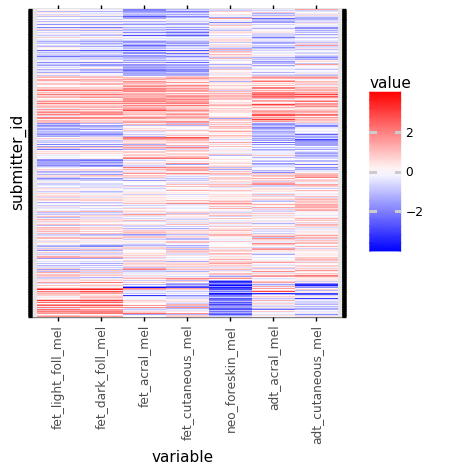

<ggplot: (-9223363292636299036)>


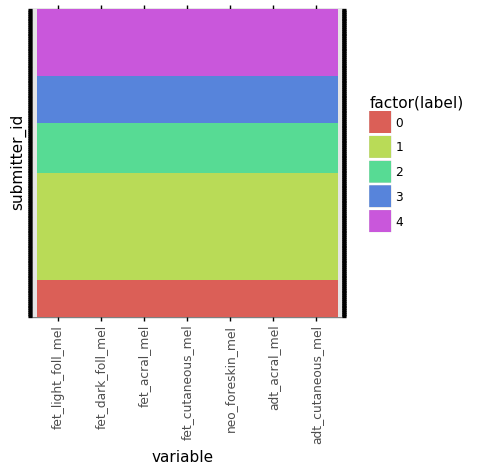

<ggplot: (-9223363292642267753)>


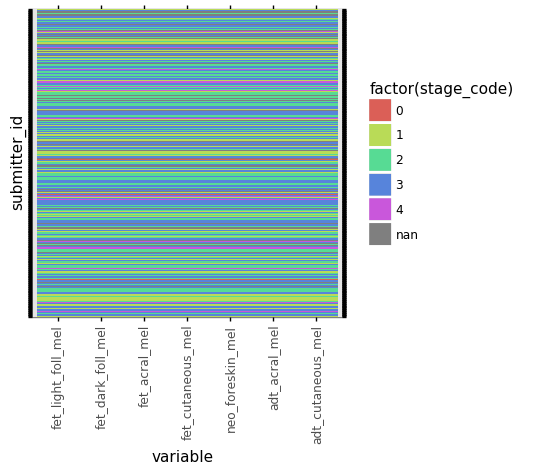

<ggplot: (-9223363292642460598)>


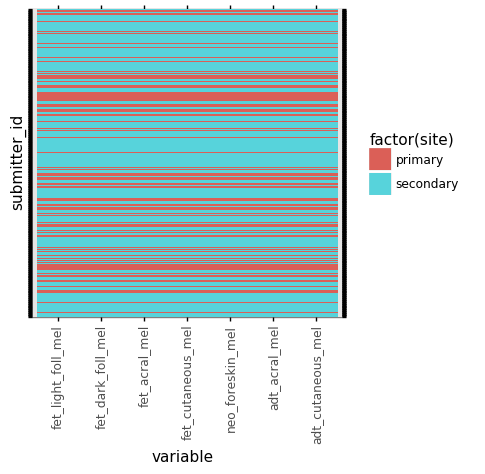

<ggplot: (8744212183293)>
computing...
0
1
2
3
4


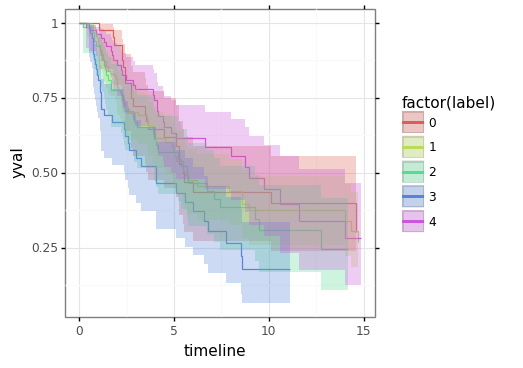

<ggplot: (8744239420406)>


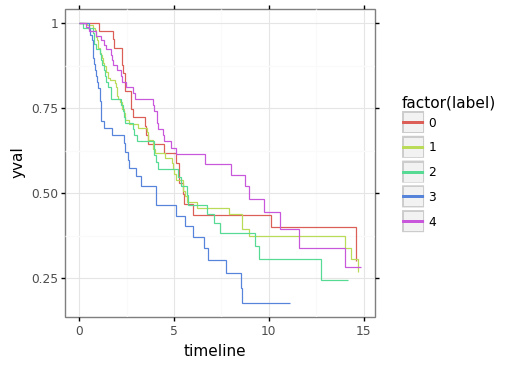

<ggplot: (-9223363292328274972)>


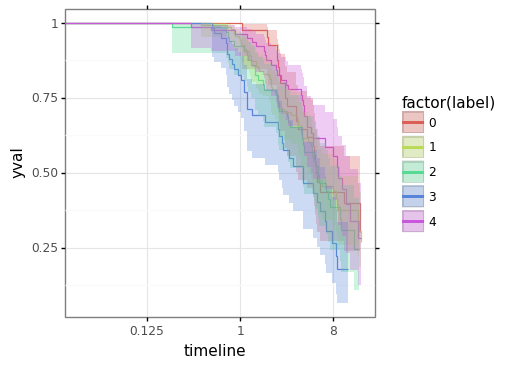

<ggplot: (-9223363292620083561)>


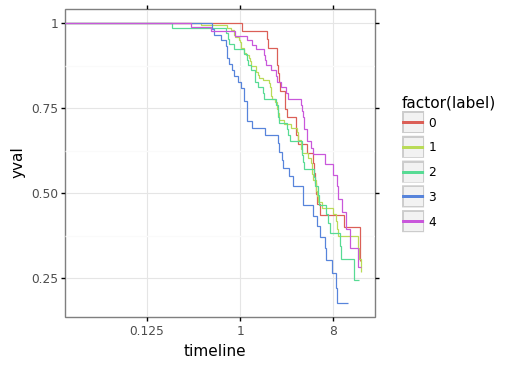

<ggplot: (8744234692244)>


In [42]:
print('computing...')

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn import preprocessing


### gene clustering
n_clust = 5
# dev_order_subset = ['mitf_program','axl_program']
dev_order_subset = [x for x in type_order_3 if x in set(input_adata.obs.class_3)][::-1]
# dev_order_subset = dev_order


data = tcga_multimod.loc[:,dev_order_subset].values
data = StandardScaler().fit_transform(data)
scaled_data = pd.DataFrame(data, columns=dev_order_subset)
cluster = AgglomerativeClustering(n_clusters=n_clust, 
                                  affinity='euclidean', 
                                  linkage='ward')  
labels = cluster.fit_predict(data).tolist()
tcga_multimod['label'] = labels
index_order = tcga_multimod.sort_values('label')['submitter_id'].tolist()

# replace with scaled data
tcga_multimod = pd.concat([tcga_multimod.loc[:,list(set(tcga_multimod.columns)-set(dev_order_subset))],scaled_data],axis=1)

### melt
static_features = ['bcr_patient_barcode','submitter_id',
                  ref_metric,f'{ref_metric}.time',
                  'site','stage_code','label']
mel_meta_merge_melt = pd.melt(tcga_multimod.loc[:, static_features+dev_order_subset], id_vars = static_features)
mel_meta_merge_melt['submitter_id'] = (mel_meta_merge_melt['submitter_id']
                                  .astype(str)
                                  .astype(CategoricalDtype(index_order, ordered = True))
                                 )
mel_meta_merge_melt['variable'] = (mel_meta_merge_melt['variable']
                               .astype(str)
                               .astype(CategoricalDtype(dev_order_subset, ordered=True))
                              )
mel_meta_merge_melt = mel_meta_merge_melt[[x is not np.nan for x in mel_meta_merge_melt.variable]]

plotnine.options.figure_size = (4,4)
for x in ['value']:
    plot = (ggplot(mel_meta_merge_melt)
            + theme_bw()
            + theme(axis_text_x = element_text(angle = 90),
                    axis_text_y = element_blank()
                   )
            + geom_tile(aes('variable','submitter_id',fill=x))
            + scale_fill_cmap('bwr',
                              limits=[-max([max(mel_meta_merge_melt[x]), abs(min(mel_meta_merge_melt[x]))]),
                                      max([max(mel_meta_merge_melt[x]), abs(min(mel_meta_merge_melt[x]))])])
           )
    print(plot)

plotnine.options.figure_size = (4,4)
for x in ['label','stage_code','site']:
    plot = (ggplot(mel_meta_merge_melt)
            + theme_bw()
            + theme(axis_text_x = element_text(angle = 90),
                    axis_text_y = element_blank()
                   )
            + geom_tile(aes('variable','submitter_id',fill=f'factor({x})'))
           )
    print(plot)
    
#################################################################################
    
print('computing...')

# metrics
metric_label = ref_metric
metric = f'{metric_label}.time'

# filters
timeline_threshold = 15
keep_labels = [x for x in range(n_clust)]
# keep_labels = [8,6]


stage_corr = tcga_multimod.dropna()
stage_corr[metric_label] = stage_corr[metric_label].astype(int)
stage_corr[metric] = stage_corr[metric]/365

## create a kmf object
kmf = KaplanMeierFitter() 

## Fit the data into the model
kmf_df = pd.DataFrame()
kmf_ribbon = pd.DataFrame()
for x in set(stage_corr['label']):
    print(x)
    durations = stage_corr[stage_corr['label'] == x][metric].tolist()
    event_observed = stage_corr[stage_corr['label'] == x][metric_label].tolist()
    kmf.fit(durations, event_observed,label = 'yval')
    kmf_slice = pd.merge(kmf.survival_function_.reset_index(),
                  kmf.confidence_interval_.reset_index().rename(columns = {'index':'timeline'}),
                  'inner',
                  'timeline')
    kmf_slice['label'] = x
    kmf_df = kmf_df.append(kmf_slice)
    kmf_ribbon = kmf_df.append(kmf_slice[:-1])

# apply filters
kmf_df = kmf_df[kmf_df['timeline'] < timeline_threshold]
kmf_df = kmf_df[[x in keep_labels for x in kmf_df.label]]


plot = (ggplot(kmf_df)
        + theme_bw()
        + geom_step(aes('timeline','yval',group='factor(label)',color='factor(label)'))
        + geom_rect(rect_converter(kmf_df, 'timeline', 'yval', 'yval_upper_0.95', 'yval_lower_0.95','label'),
                    aes(xmin='xmin', xmax='xmax', ymin='ymin', ymax='ymax', fill='factor(label)'), alpha=0.3)
#         + scale_x_continuous(trans = 'log2')
   )     
print(plot)

plot = (ggplot(kmf_df)
        + theme_bw()
        + geom_step(aes('timeline','yval',group='factor(label)',color='factor(label)'))
#         + geom_rect(rect_converter(kmf_df, 'timeline', 'yval', 'yval_upper_0.95', 'yval_lower_0.95','label'),
#                     aes(xmin='xmin', xmax='xmax', ymin='ymin', ymax='ymax', fill='factor(label)'), alpha=0.3)
#         + scale_x_continuous(trans = 'log2')
   )     
print(plot)

plot = (ggplot(kmf_df)
        + theme_bw()
        + geom_step(aes('timeline','yval',group='factor(label)',color='factor(label)'))
        + geom_rect(rect_converter(kmf_df, 'timeline', 'yval', 'yval_upper_0.95', 'yval_lower_0.95','label'),
                    aes(xmin='xmin', xmax='xmax', ymin='ymin', ymax='ymax', fill='factor(label)'), alpha=0.3)
        + scale_x_continuous(trans = 'log2')
   )     
print(plot)

plot = (ggplot(kmf_df)
        + theme_bw()
        + geom_step(aes('timeline','yval',group='factor(label)',color='factor(label)'))
#         + geom_rect(rect_converter(kmf_df, 'timeline', 'yval', 'yval_upper_0.95', 'yval_lower_0.95','label'),
#                     aes(xmin='xmin', xmax='xmax', ymin='ymin', ymax='ymax', fill='factor(label)'), alpha=0.3)
        + scale_x_continuous(trans = 'log2')
   )     
print(plot)
    

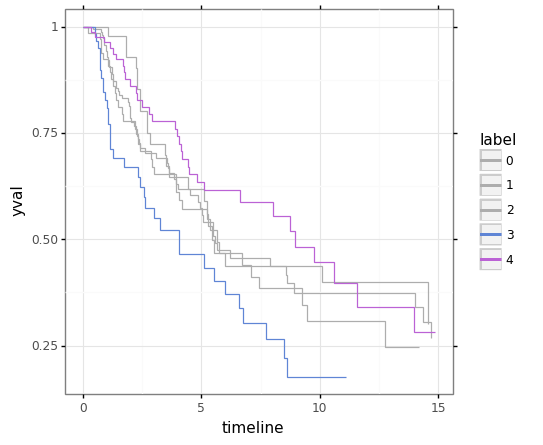

<ggplot: (-9223363292720061510)>


In [67]:
color_dict = {'0':'#ADADAD',
              '1':'#ADADAD',
              '2':'#ADADAD',
              '3':'#5F85D5',
              '4':'#BB62D5'
             }
kmf_df['label'] = kmf_df['label'].astype(str)
plot = (ggplot(kmf_df)
        + theme_bw()
        + geom_step(aes('timeline','yval',group='label',color='label'))
        + scale_color_manual(values = color_dict)
#         + geom_rect(rect_converter(kmf_df, 'timeline', 'yval', 'yval_upper_0.95', 'yval_lower_0.95','label'),
#                     aes(xmin='xmin', xmax='xmax', ymin='ymin', ymax='ymax', fill='factor(label)'), alpha=0.3)
#         + scale_x_continuous(trans = 'log2')
   )     
print(plot)

In [41]:
print('computing...')

from lifelines.statistics import logrank_test
L1 = 3
L2 = 4

T1 = stage_corr[stage_corr['label'] == L1][metric].tolist()
E1 = stage_corr[stage_corr['label'] == L1][metric_label].tolist()
                
T2 = stage_corr[stage_corr['label'] == L2][metric].tolist()
E2 = stage_corr[stage_corr['label'] == L2][metric_label].tolist()

results = logrank_test(T1, T2, event_observed_A=E1, event_observed_B=E2)
results.print_summary()

"""
              t_0 = -1
            alpha = 0.95
null_distribution = chi squared
               df = 1
   use_bonferroni = True

---
test_statistic        p
         3.528  0.00034  **


"""

print(results.p_value)        # 0.46759
print(results.test_statistic) # 0.528

computing...
<lifelines.StatisticalResult>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1

---
 test_statistic      p  -log2(p)
          11.77 <0.005     10.70
0.0006015710951246652
11.771109551929513


##### next

In [ ]:
print('computing...')

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn import preprocessing


### gene clustering
n_clust = 5
keep_label = 3
ref_metric = 'OS'

data = tcga_multimod.loc[:,dev_order].values
data = StandardScaler().fit_transform(data)
scaled_data = pd.DataFrame(data, columns=dev_order)
cluster = AgglomerativeClustering(n_clusters=n_clust, 
                                  affinity='euclidean', 
                                  linkage='ward')  
labels = cluster.fit_predict(data).tolist()
labels = [x if x == keep_label else -1 for x in labels]

tcga_multimod['label'] = labels
index_order = tcga_multimod.sort_values('label')['submitter_id'].tolist()

# replace with scaled data
tcga_multimod = pd.concat([tcga_multimod.loc[:,list(set(tcga_multimod.columns)-set(dev_order))],scaled_data],axis=1)

### melt
mel_meta_merge_melt = pd.melt(tcga_multimod, id_vars = ['bcr_patient_barcode','submitter_id',
                                                  ref_metric,f'{ref_metric}.time',
                                                  'site','stage_code','label'])
mel_meta_merge_melt['submitter_id'] = (mel_meta_merge_melt['submitter_id']
                                  .astype(str)
                                  .astype(CategoricalDtype(index_order, ordered = True))
                                 )
mel_meta_merge_melt['variable'] = (mel_meta_merge_melt['variable']
                               .astype(str)
                               .astype(CategoricalDtype(dev_order, ordered=True))
                              )

plotnine.options.figure_size = (4,4)
for x in ['value']:
    plot = (ggplot(mel_meta_merge_melt)
            + theme_bw()
            + theme(axis_text_x = element_text(angle = 90),
                    axis_text_y = element_blank()
                   )
            + geom_tile(aes('variable','submitter_id',fill=x))
            + scale_fill_cmap('bwr',
                              limits=[-max([max(mel_meta_merge_melt[x]), abs(min(mel_meta_merge_melt[x]))]),
                                      max([max(mel_meta_merge_melt[x]), abs(min(mel_meta_merge_melt[x]))])])
           )
    print(plot)

plotnine.options.figure_size = (4,4)
for x in ['label','stage_code','site']:
    plot = (ggplot(mel_meta_merge_melt)
            + theme_bw()
            + theme(axis_text_x = element_text(angle = 90),
                    axis_text_y = element_blank()
                   )
            + geom_tile(aes('variable','submitter_id',fill=f'factor({x})'))
           )
    print(plot)
    
#################################################################################
    
print('computing...')

# metrics
metric_label = ref_metric
metric = f'{metric_label}.time'

# filters
timeline_threshold = 30
stage_corr = tcga_multimod.dropna()
stage_corr[metric_label] = stage_corr[metric_label].astype(int)
stage_corr[metric] = stage_corr[metric]/365



## create a kmf object
kmf = KaplanMeierFitter() 

## Fit the data into the model
kmf_df = pd.DataFrame()
kmf_ribbon = pd.DataFrame()
for x in set(stage_corr['label']):
    print(x)
    durations = stage_corr[stage_corr['label'] == x][metric].tolist()
    event_observed = stage_corr[stage_corr['label'] == x][metric_label].tolist()
    kmf.fit(durations, event_observed,label = 'yval')
    kmf_slice = pd.merge(kmf.survival_function_.reset_index(),
                  kmf.confidence_interval_.reset_index().rename(columns = {'index':'timeline'}),
                  'inner',
                  'timeline')
    kmf_slice['label'] = x
    kmf_df = kmf_df.append(kmf_slice)
    kmf_ribbon = kmf_df.append(kmf_slice[:-1])

# apply filters
kmf_df = kmf_df[kmf_df['timeline'] < timeline_threshold]

plot = (ggplot(kmf_df)
        + theme_bw()
        + geom_step(aes('timeline','yval',group='factor(label)',color='factor(label)'))
        + geom_rect(rect_converter(kmf_df, 'timeline', 'yval', 'yval_upper_0.95', 'yval_lower_0.95','label'),
                    aes(xmin='xmin', xmax='xmax', ymin='ymin', ymax='ymax', fill='factor(label)'), alpha=0.3)
#         + scale_x_continuous(trans = 'log2')
   )     
print(plot)

plot = (ggplot(kmf_df)
        + theme_bw()
        + geom_step(aes('timeline','yval',group='factor(label)',color='factor(label)'))
#         + geom_rect(rect_converter(kmf_df, 'timeline', 'yval', 'yval_upper_0.95', 'yval_lower_0.95','label'),
#                     aes(xmin='xmin', xmax='xmax', ymin='ymin', ymax='ymax', fill='factor(label)'), alpha=0.3)
#         + scale_x_continuous(trans = 'log2')
   )     
print(plot)

plot = (ggplot(kmf_df)
        + theme_bw()
        + geom_step(aes('timeline','yval',group='factor(label)',color='factor(label)'))
        + geom_rect(rect_converter(kmf_df, 'timeline', 'yval', 'yval_upper_0.95', 'yval_lower_0.95','label'),
                    aes(xmin='xmin', xmax='xmax', ymin='ymin', ymax='ymax', fill='factor(label)'), alpha=0.3)
        + scale_x_continuous(trans = 'log2')
   )     
print(plot)

plot = (ggplot(kmf_df)
        + theme_bw()
        + geom_step(aes('timeline','yval',group='factor(label)',color='factor(label)'))
#         + geom_rect(rect_converter(kmf_df, 'timeline', 'yval', 'yval_upper_0.95', 'yval_lower_0.95','label'),
#                     aes(xmin='xmin', xmax='xmax', ymin='ymin', ymax='ymax', fill='factor(label)'), alpha=0.3)
        + scale_x_continuous(trans = 'log2')
   )     
print(plot)
    

##### (decommissioned) Cancer-normal ratio score

In [ ]:
# input_adata = adata_subset2_trimmed

# program_df = pd.read_csv('s3://daniel.le-work/MEL_project/axl_mitf_genes.csv')
# cancer_module = plot_df_slice.gene.tolist()[:10]
# normal_module = plot_df_slice.gene.tolist()[-10:]

# modules_dict = {'cancer_module':cancer_module,
#                 'normal_module':normal_module,
#                }

# input_adata.obs['cell'] = input_adata.obs.index.tolist()
# input_adata.obs['cell'] = (input_adata
#                           .obs['cell']
#                           .astype(str)
#                           .astype(CategoricalDtype(input_adata.obs['cell'].tolist())))
# cat, exp_df = prepare_dataframe(input_adata,
#                  var_names = [x for key,value in modules_dict.items() for x in value],
#                  groupby = 'cell')
# exp_df = exp_df.rank(pct=True, axis=0, method = 'min') # ranked expression per cell
# exp_df = exp_df.rank(pct=True, axis=1, method = 'min') # ranking ranked expression per gene (normalizing contribution of each gene)

# for key,value in modules_dict.items():
#     input_adata.obs[key] = exp_df.loc[:,value].mean(axis=1)
#     sc.pl.umap(input_adata, color=[key], cmap = 'magma_r', palette = 'tab20')

# input_adata.obs['can_norm'] = input_adata.obs['cancer_module']/input_adata.obs['normal_module']
# sc.pl.umap(input_adata, color=['can_norm'], cmap = 'magma_r', palette = 'tab20')


# # density of cancer score
# groupby = 'dev_subtype'
# can_norm_df = input_adata.obs.loc[:,['can_norm',groupby]]
# plotnine.options.figure_size = (3,3)
# plot = (ggplot(can_norm_df)
#         + theme_bw()
#         + theme(axis_text_x = element_text(angle=90))
#         + geom_boxplot(aes(groupby,'can_norm'))
# #         + scale_y_log10()
#        )
# plot



# DEV: correlation to dish differentiation

In [ ]:
wkdir, s3dir = '/GB100_1/raw_dish_allcells', 'daniel.le-work/dish_MEL'

# import data from s3
for file in ['adata_coi_noncyc']:
        
#     ! aws s3 cp s3://{s3dir}/{file}.p {wkdir}/
    var = pickle.load((open(f'{wkdir}/{file}.p', 'rb')))
    exec(f'{file} = var')
    del var
    
sc.pl.umap(adata_coi_noncyc, color=['detailed_annotation'])


In [ ]:
# input_adata = adata_coi_noncyc
# type_dict = {'neural_crest_precursor':'embryonic_stem_cell',
#               'early_neural_crest':'neural_crest_precursor',
#               'melanoblast':'early_neural_crest',
#               'dir_melanocyte':'melanoblast',  
#               'late_neural_crest':'neural_crest_precursor',
#               'SCP_early_melanoblast':'late_neural_crest',
#               'indir_melanocyte':'SCP_early_melanoblast',
#             }
# type_order = [f'{key}>>{value}' for key,value in type_dict.items()][::-1]
# print(type_order)

# dish_DE_df = pd.DataFrame()
# for key,value in type_dict.items():
#     print(f'{key}>>{value}')
#     tmpdf = pd.DataFrame()
#     tmpdf['gene'] = fast_DE(input_adata, value, 'detailed_annotation', key, gene_n=500)
#     tmpdf['detailed_annotation'] = f'{key}>>{value}'
#     dish_DE_df = dish_DE_df.append(tmpdf)
    
# dish_DE_df['detailed_annotation'] = (dish_DE_df['detailed_annotation']
#                       .astype(str)
#                       .astype(CategoricalDtype(type_order, ordered=True))
#                      )

# # omit_gene = pd.DataFrame(dish_DE_df['gene'].value_counts())
# # omit_gene = omit_gene[omit_gene.gene > 1].index.tolist()
# # dish_DE_df = dish_DE_df[[x not in omit_gene for x in dish_DE_df.gene]]

In [ ]:
input_adata = adata_coi_noncyc
type_order = ['embryonic_stem_cell',
              'neural_crest_precursor',
              'early_neural_crest',
              'late_neural_crest',
              'SCP_early_melanoblast',
              'melanoblast',
              'dir_melanocyte',
              'indir_melanocyte',
             ]

dish_DE_df = pd.DataFrame()
for x in tqdm.tqdm(type_order):
    tmpdf = pd.DataFrame()
    tmpdf['gene'] = fast_DE(input_adata, x,'detailed_annotation',gene_n=500)
    tmpdf['detailed_annotation'] = x
    dish_DE_df = dish_DE_df.append(tmpdf)
    
dish_DE_df['detailed_annotation'] = (dish_DE_df['detailed_annotation']
                      .astype(str)
                      .astype(CategoricalDtype(type_order, ordered=True))
                     )
# omit_gene = pd.DataFrame(dish_DE_df['gene'].value_counts())
# omit_gene = omit_gene[omit_gene.gene > 1].index.tolist()
# dish_DE_df = dish_DE_df[[x not in omit_gene for x in dish_DE_df.gene]]


In [ ]:
n_gene = 50
for dish_group in type_order:
    print(dish_group)
    input_adata = full_adata
    module_set = dish_DE_df[dish_DE_df.detailed_annotation == dish_group].gene.tolist()[:n_gene]
    module_set = list(set(module_set) & set(input_adata.var_names))

    input_adata.obs['cell'] = input_adata.obs.index.tolist()
    input_adata.obs['cell'] = (input_adata
                              .obs['cell']
                              .astype(str)
                              .astype(CategoricalDtype(input_adata.obs['cell'].tolist())))
    cat, exp_df = prepare_dataframe(input_adata,
                     var_names = input_adata.var_names,
                     groupby = 'cell')
    exp_df = exp_df.rank(pct=True, axis=1, method = 'min') # ranked expression per cell
#     exp_df = exp_df.rank(pct=True, axis=1, method = 'min') # ranking ranked expression per gene (normalizing contribution of each gene)
    input_adata.obs[f'{dish_group}_module'] = exp_df.loc[:,module_set].mean(axis=1)
    sc.pl.umap(input_adata, color=[f'{dish_group}_module'], cmap = 'magma', palette = 'tab20')


In [ ]:
# remove path
dir_path = ['dir_melanocyte','melanoblast','early_neural_crest'][::-1]
indir_path = ['indir_melanocyte','SCP_early_melanoblast','late_neural_crest'][::-1]
trunk_path = ['embryonic_stem_cell','neural_crest_precursor']
type_order = trunk_path + indir_path + dir_path

# 
input_adata = full_adata
coi = input_adata[input_adata.obs.class_1 == 'msc'].obs.index.tolist() + \
        adata_subset2_trimmed.obs.index.tolist()
dish_score_df = input_adata[[x in coi for x in input_adata.obs.index]]
dish_score_df = input_adata.obs.loc[:,['class_1','dev_stage']+[f'{x}_module' for x in type_order]]
dish_score_df['class_stage'] = [f'{x}_{y}' for x,y in zip(dish_score_df.class_1, dish_score_df.dev_stage)]
dish_score_melt = pd.melt(dish_score_df.drop(['class_1', 'dev_stage'], axis = 1).reset_index(), 
                          id_vars=['index','class_stage'])
dish_score_melt = dish_score_melt[[x in ['mel_adt','mel_neo','mel_fet','msc_fet'] \
                                   for x in dish_score_melt.class_stage]]
dish_score_melt['variable'] = (dish_score_melt['variable']
                               .astype(str)
                               .astype(CategoricalDtype([f'{x}_module' for x in type_order], ordered=True))
                              )
dish_score_melt['class_stage'] = (dish_score_melt['class_stage']
                               .astype(str)
                               .astype(CategoricalDtype(['mel_adt','mel_neo','mel_fet','msc_fet'], ordered=True))
                              )

# boxplots

plotnine.options.figure_size = (5,5)
plot = (ggplot(dish_score_melt)
        + theme_bw()
        + theme(aspect_ratio = 1,
                axis_text_x = element_blank(),
               )
        + geom_boxplot(aes('variable','value', color = 'variable'))
        + facet_wrap('~class_stage')
       )
print(plot)

# subsampled line plots

cell_n = 500

plot_df = pd.DataFrame()
for x in set(dish_score_melt.class_stage):
    df_slice = dish_score_melt[dish_score_melt.class_stage == x]
    cell_count = len(set(df_slice['index']))
    if cell_n <= cell_count:
        index_oi = df_slice.loc[:,['index']].drop_duplicates().sample(cell_n)['index'].tolist()
        df_slice = df_slice[[z in index_oi for z in df_slice['index']]]
        cell_count = cell_n
    df_slice['class_stage'] = [f'{y} ({cell_count})' for y in df_slice['class_stage']]
    plot_df = plot_df.append(df_slice)
        
plotnine.options.figure_size = (5,5)
plot = (ggplot(plot_df)
        + theme_bw()
        + theme(aspect_ratio = 1,
                axis_text_x = element_blank(),
                panel_spacing = 0.3
               )
        + geom_line(aes('variable','value',group='index'),alpha = 0.1)
#         + geom_point(aes('variable','value',color='variable'))
        + facet_wrap('~class_stage')
       )
print(plot)


In [ ]:
# correlate to scRNAseq of melanomas
melanoma_df = sc_mel_counts.drop(['cancer_patient'], axis=1)
# genesoi = [x for x in set(gene_order_greater + gene_order_less) if x in melanoma_df.columns.tolist()]
# melanoma_df = melanoma_df.loc[:, genesoi]
melanoma_df = melanoma_df.rank(pct=True, axis=1, method = 'min') # ranked expression per cell
# melanoma_df = melanoma_df.rank(pct=True, axis=1, method = 'min') # ranking ranked expression per gene (normalizing contribution of each gene)

mel_mod_df = pd.DataFrame({'patient':patient_values,
                         'cell_id':cell_id
                         })

for dish_group in type_order:
    print(dish_group)
    input_adata = melanoma_df
    module_set = dish_DE_df[dish_DE_df.detailed_annotation == dish_group].gene.tolist()
    module_set = list(set(module_set) & set(input_adata.columns))

    input_adata = input_adata.rank(pct=True, axis=1, method = 'min') # ranked expression per cell
#     exp_df = exp_df.rank(pct=True, axis=1, method = 'min') # ranking ranked expression per gene (normalizing contribution of each gene)
    mel_mod_df[f'{dish_group}_module'] = input_adata.loc[:,module_set].mean(axis=1).values
    

# boxplots
dish_score_melt = pd.melt(mel_mod_df.drop(['cell_id'], axis = 1), id_vars='patient')

dish_score_melt['variable'] = (dish_score_melt['variable']
                               .astype(str)
                               .astype(CategoricalDtype([f'{x}_module' for x in type_order], ordered=True))
                              )
# dish_score_melt['class_stage'] = (dish_score_melt['class_stage']
#                                .astype(str)
#                                .astype(CategoricalDtype(['mel_adt','mel_neo','mel_fet','msc_fet'], ordered=True))
#                               )

plotnine.options.figure_size = (7,7)
plot = (ggplot(dish_score_melt)
        + theme_bw()
        + theme(aspect_ratio = 1,
                axis_text_x = element_blank(),
                panel_spacing = 0.3
               )
        + geom_boxplot(aes('variable','value', color = 'variable'))
        + facet_wrap('~patient')
       )
print(plot)


# line plots
dish_score_melt = pd.melt(mel_mod_df, id_vars=['patient','cell_id'])

dish_score_melt['variable'] = (dish_score_melt['variable']
                               .astype(str)
                               .astype(CategoricalDtype([f'{x}_module' for x in type_order], ordered=True))
                              )

plotnine.options.figure_size = (7,7)
plot = (ggplot(dish_score_melt)
        + theme_bw()
        + theme(aspect_ratio = 1,
                axis_text_x = element_blank(),
                panel_spacing = 0.3
               )
        + geom_line(aes('variable','value',group='cell_id'),alpha = 0.1)
#         + geom_point(aes('variable','value',color='variable'))
        + facet_wrap('~patient')
       )
print(plot)


In [ ]:
print('computing...')

# TCGA
melanoma_df = tcga_df_fltr.T
# genesoi = [x for x in set(gene_order_greater + gene_order_less) if x in melanoma_df.columns.tolist()]
# melanoma_df = melanoma_df.loc[:, genesoi]
melanoma_df = melanoma_df.rank(pct=True, axis=1, method = 'min') # ranked expression per cell
# melanoma_df = melanoma_df.rank(pct=True, axis=1, method = 'min') # ranking ranked expression per gene (normalizing contribution of each gene)

mel_mod_df = pd.DataFrame({'patient':melanoma_df.index.values,
                         })

for dish_group in type_order:
    print(dish_group)
    input_adata = melanoma_df
    module_set = dish_DE_df[dish_DE_df.detailed_annotation == dish_group].gene.tolist()
    module_set = list(set(module_set) & set(input_adata.columns))

    input_adata = input_adata.rank(pct=True, axis=1, method = 'min') # ranked expression per cell
#     exp_df = exp_df.rank(pct=True, axis=1, method = 'min') # ranking ranked expression per gene (normalizing contribution of each gene)
    mel_mod_df[f'{dish_group}_module'] = input_adata.loc[:,module_set].mean(axis=1).values
    
mel_meta_merge = pd.merge(mel_mod_df,
                           tcga_meta_ordered.loc[:,['submitter_id','PFI.time','PFI']].rename(columns = {'submitter_id':'patient'}),
                           'left','patient').dropna()

### gene clustering
n_clust = 2
from sklearn import preprocessing
data = mel_meta_merge.iloc[:,1:-3].values
# data = preprocessing.minmax_scale(data.T).T
cluster = AgglomerativeClustering(n_clusters=n_clust, 
                                  affinity='euclidean', 
                                  linkage='ward')  
labels = cluster.fit_predict(data).tolist()
mel_meta_merge['label'] = labels
gene_order = mel_meta_merge.sort_values('label').patient.tolist()
###

mel_meta_merge_melt = pd.melt(mel_meta_merge, id_vars = ['patient','PFI','PFI.time','label'])
mel_meta_merge_melt['patient'] = (mel_meta_merge_melt['patient']
                                  .astype(str)
                                  .astype(CategoricalDtype(gene_order, ordered = True))
                                 )
mel_meta_merge_melt['variable'] = (mel_meta_merge_melt['variable']
                               .astype(str)
                               .astype(CategoricalDtype([f'{x}_module' for x in type_order], ordered=True))
                              )

plotnine.options.figure_size = (4,4)
plot = (ggplot(mel_meta_merge_melt)
        + theme_bw()
        + theme(axis_text_x = element_text(angle = 90),
                axis_text_y = element_blank()
               )
        + geom_tile(aes('variable','patient',fill='value'))
        + scale_fill_cmap('magma')
       )
print(plot)

plotnine.options.figure_size = (4,4)
plot = (ggplot(mel_meta_merge_melt)
        + theme_bw()
        + theme(axis_text_x = element_text(angle = 90),
               axis_text_y = element_blank()
               )
        + geom_tile(aes('variable','patient',fill='factor(label)'))
       )
print(plot)

plotnine.options.figure_size = (3,3)
plot = (ggplot(mel_meta_merge_melt)
        + theme_bw()
        + theme(aspect_ratio = 1,
                axis_text_x = element_text(angle = 90)
               )
        + geom_line(aes('variable','value',group='patient',color='factor(label)'), alpha = 0.1)
#         + facet_wrap('~label')
       )
print(plot)


# KM plot

stage_corr = mel_meta_merge_melt
stage_corr['PFI'] = stage_corr['PFI'].astype(int)
stage_corr['PFI.time'] = stage_corr['PFI.time']/365

kmf_df = pd.DataFrame()
kmf_ribbon = pd.DataFrame()
for x in set(stage_corr.label):
    print(x)
    kmf = KaplanMeierFitter() 
    durations = stage_corr[stage_corr['label'] == x]['PFI.time'].tolist()
    event_observed = stage_corr[stage_corr['label'] == x]['PFI'].tolist()
    kmf.fit(durations, event_observed,label = 'yval')
    kmf_slice = pd.merge(kmf.survival_function_.reset_index(),
                  kmf.confidence_interval_.reset_index().rename(columns = {'index':'timeline'}),
                  'inner',
                  'timeline')
    kmf_slice['label'] = x
    kmf_df = kmf_df.append(kmf_slice)
    kmf_ribbon = kmf_df.append(kmf_slice[:-1])

plot = (ggplot(kmf_df)
        + theme_bw()
        + geom_step(aes('timeline','yval',group='factor(label)',color='factor(label)'))
        + geom_rect(rect_converter(kmf_df, 'timeline', 'yval', 'yval_upper_0.95', 'yval_lower_0.95','label'),
                    aes(xmin='xmin', xmax='xmax', ymin='ymin', ymax='ymax', fill='factor(label)'), alpha=0.3)
   )     
print(plot)

plot = (ggplot(kmf_df)
        + theme_bw()
        + geom_step(aes('timeline','yval',group='factor(label)',color='factor(label)'))
        + geom_rect(rect_converter(kmf_df, 'timeline', 'yval', 'yval_upper_0.95', 'yval_lower_0.95','label'),
                    aes(xmin='xmin', xmax='xmax', ymin='ymin', ymax='ymax', fill='factor(label)'), alpha=0.3)
        + scale_x_continuous(trans = 'log2')
   )     
print(plot)


# (decommissioned) DEV: cellphone db testing

In [ ]:
# create new classes
full_adata.obs['dev_subtype_celltype'] = [f'{x}_{y}' for x,y in zip(full_adata.obs['dev_subtype'], full_adata.obs['class_1'])]
full_adata.obs['dev_subtype_celltype'] = full_adata.obs['dev_subtype_celltype'].astype(str).astype(CategoricalDtype(list(set(full_adata.obs['dev_subtype_celltype']))))
set(full_adata.obs['dev_subtype_celltype'])


In [ ]:
def calc_pct_expr(col):
    return np.sum(col)/len(col)

# cellphone db methods:
# ref: https://www.nature.com/articles/s41586-018-0698-6#Sec9
# >10% ligand and receptor in cell types
# permutation test te determine p-value
# HOWEVER: https://digitalcommons.wayne.edu/cgi/viewcontent.cgi?referer=https://www.google.com/&httpsredir=1&article=1479&context=jmasm
# above authors show, using simulations, that WMU test has higher power (ability to correctly reject null)

# input adata
alpha = 0.1
input_adata = full_adata
feature_axis = 'class_1' # must be binary!
classes = ['MEL', 'KRT']
input_adata = input_adata[[x in classes for x in input_adata.obs[feature_axis]]]

# cast counts data
cat, gene_df = prepare_dataframe(input_adata,
                         input_adata.var_names,
                         feature_axis)

# pull interactions list
interact_df = pd.read_csv('s3://daniel.le-work/MEL_project/DL20190307_interactions_cellphonedb.csv')
interact_df = interact_df.loc[:,['entry_name_a', 'entry_name_b']].dropna()
interact_df['entry_name_a'] = [x.split('_')[0] for x in interact_df['entry_name_a']]
interact_df['entry_name_b'] = [x.split('_')[0] for x in interact_df['entry_name_b']]

# non-zero expression df
nz_df = gene_df.astype(bool).reset_index().groupby(feature_axis).apply(calc_pct_expr)

# filter nz df by interaction genes
interaction_genes = list(set(interact_df['entry_name_a'].values.tolist() + interact_df['entry_name_b'].values.tolist()))
nz_df = (nz_df
         .loc[:,interaction_genes]
         .T
         .dropna())

# filter nz df by heuristic: pct_exp > 0.1 in both classes
nz_df = nz_df[[x >= 0.1 and y >= 0.1 for x,y in zip(nz_df[classes[0]], nz_df[classes[1]])]]
passed_genes = nz_df.index.tolist()

# filter interactions that pass heuristic
interact_df = interact_df[[x in passed_genes and y in passed_genes for x,y in zip(interact_df['entry_name_a'],interact_df['entry_name_b'])]]
interact_df['pairs'] = [f'pair_{x}' for x in range(len(interact_df))]
interact_df = pd.melt(interact_df, id_vars='pairs').sort_values('pairs')
interact_df = interact_df.drop('variable', axis = 1)
try:
    # mwu test for differential gene expression between classes
    stat_list = []
    pval_list = []
    test_count = 0
    for goi in interact_df.value:
        expr = gene_df.loc[:, [goi]].reset_index()
        c1_expr = expr[[x == classes[0] for x in expr[feature_axis]]][goi].values
        c2_expr = expr[[x == classes[1] for x in expr[feature_axis]]][goi].values
        stat,pval = stats.mannwhitneyu(c1_expr, c2_expr, alternative='two-sided')
        test_count += 1
        stat_list.append(stat)
        pval_list.append(pval)

    interact_df['intra_gene_diff'] = pval_list


    # mwu and mean ratio for differential paired gene expression within classes
    intergene_df = pd.DataFrame()
    for pair in list(set(interact_df.pairs)):
        gois = interact_df[interact_df.pairs == pair].value.values.tolist()
        goi1 = gois[0]
        goi2 = gois[1]
        expr = gene_df.loc[:, gois].reset_index()
        ratio_sign_list = []
        stat_list = []
        pval_list = []
        for class_val in classes:
            g1_expr = expr[[x == class_val for x in expr[feature_axis]]][goi1].values
            g2_expr = expr[[x == class_val for x in expr[feature_axis]]][goi2].values
            # calc ratio g1/g2
            ratio_sign = np.sign(np.mean(g1_expr) - np.mean(g2_expr))
            ratio_sign_list.append(ratio_sign)
            # calc mwu test
            stat,pval = stats.mannwhitneyu(g1_expr, g2_expr, alternative='two-sided')
            test_count += 1
            stat_list.append(stat)
            pval_list.append(pval)
        tmp_df = pd.DataFrame({'sign':ratio_sign_list,
                      'stat':stat_list,
                      'pval':pval_list,
                      'class_var':classes
                     })
        tmp_df['pairs'] = pair
        intergene_df = intergene_df.append(tmp_df)

    # parse intergene df and update interact df with pass/fail
    filter_df = pd.DataFrame()
    for pair in list(set(intergene_df.pairs)):
        slice_df = intergene_df[intergene_df.pairs == pair]
        sign_list = slice_df['sign'].values.tolist()
        pval_list = slice_df['pval'].values.tolist()
        class_list = slice_df['class_var'].values.tolist()
        filter_slice = pd.DataFrame({'pairs':[pair],
                                  'mutually_opposed':[sign_list[0] != sign_list[1]],
                                  f'intra_{class_list[0]}_diff':[pval_list[0]],
                                  f'intra_{class_list[1]}_diff':[pval_list[1]]
                                 })
        filter_df = filter_df.append(filter_slice)

    interact_df = pd.merge(interact_df, filter_df, 'left','pairs')
    # final filters: diametrically opposed expression within class, between gene pairs
    interact_df = interact_df[interact_df.mutually_opposed == True]
    # final filters: independence test between classes for each gene in pairs &
    #independence test within classes for each gene in pairs
    for pair in list(set(interact_df.pairs)):
        if np.sum((interact_df[intergene_df.pairs == pair]
                  .loc[:,[x.startswith('intra') for x in interact_df.columns]]
                  .values) < (alpha / test_count)) != 6:
            interact_df =  interact_df[interact_df.pairs != pair]
        else:
            pass

    if len(interact_df) == 0:
        raise exception
    else:
        for pair in list(set(interact_df.pairs)):
            df_slice = interact_df[interact_df.pairs == pair]
            display(df_slice)
            gois = df_slice.value.values.tolist()
            
            sc.pl.umap(input_adata, color = gois+[feature_axis], cmap = 'nipy_spectral')
            
            plot_df = gene_df.loc[:,gois].reset_index()
            plot_df = pd.melt(plot_df, id_vars=feature_axis)
            print(ggplot(plot_df)
                  + theme_bw()
            #       + geom_boxplot(aes(feature_axis, 'value', color = 'variable'))
                  + geom_jitter(aes('variable', 'value', color = 'variable'), alpha = 0.5)
                  + facet_wrap(f'~{feature_axis}', scales = 'free')
                 )
            
            out = symbol2field(gois)
            output = [print(f'{idx}: ', 
                   x['query'],
                   '\n',x['summary']) if ('summary' in x.keys()) else print(f'{idx}: ', 
                                                                            x['query'],
                                                                            '\n','N/A') for idx, x in enumerate(out)]
except:
    print('No significant interactions')
    

# (decommissioned) DEV: KRT analysis


## n_genes

In [ ]:
# n_genes
sc.pl.umap(adata_subset1_KRT, color = ['n_genes', 'age', 'n_counts', 'KRT10'], cmap = 'nipy_spectral', ncols = 2)
krt_ngenes = adata_subset1_KRT.obs.loc[:,['n_genes','age_group']].reset_index()
cat, krt_genes = prepare_dataframe(adata_subset1_KRT, adata_subset1_KRT.var_names, 'age_bin')
krt_genes = krt_genes.reset_index()
krt_df = pd.concat([krt_genes, krt_ngenes], axis = 1)


In [ ]:
print(ggplot(krt_df)
      + theme_bw()
      + theme(axis_text_x = element_text(angle = 90))
      + geom_boxplot(aes('age_bin','n_genes'))
     )

print(ggplot(krt_df)
      + theme_bw()
      + theme(axis_text_x = element_text(angle = 90))
      + geom_boxplot(aes('age_group','n_genes'))
     )

## acral vs cutaneous

In [ ]:
master_diff = pd.DataFrame()
for test in ['less','greater']:
    for dev_stage in ['adt', 'fet']:
        print(f'calculating {dev_stage} acral {test} than cutaneous...')
        input_slice = adata_subset1_KRT[adata_subset1_KRT.obs.dev_stage == dev_stage]
        genes = input_slice.var_names.tolist()
        cat, prep_slice = prepare_dataframe(input_slice,
                                             var_names = genes,
                                             groupby = 'subtypes')
        prep_slice = prep_slice[prep_slice.index != 'foreskin']
        cut_input = (prep_slice[[x == 'cutaneous' for x in prep_slice.index]]
                     .rank(pct=True, axis = 1, method = 'min'))
        acr_input = (prep_slice[[x == 'acral' for x in prep_slice.index]]
                     .rank(pct=True, axis = 1, method = 'min'))

        stat_pval_tuple = parallel_mwu(genes, 
                                       acr_input,
                                       cut_input,  
                                       test,
                                       usable_cores)
        stat_list = stat_pval_tuple[0]
        pval_list = stat_pval_tuple[1]
        diff_df = (pd.DataFrame({'gene':genes,
                                 'stat_1':stat_list,
                                 'pval_1':pval_list
                                })
                  )
        diff_df['dev_stage'] = dev_stage
        diff_df['test'] = test
        master_diff = master_diff.append(diff_df)


In [ ]:
print_n = 10
dev_stage = 'adt'
test = 'greater' # acr {test} than adt

(master_diff
 .query(f'dev_stage == "{dev_stage}"')
 .query(f'test == "{test}"')
 .sort_values('pval_1')
 .head(print_n))

In [ ]:
# need to subset on cell-specific dev_stage
full_adata.obs['cell_dev_subtype'] = [f'{x}_{y}' for x,y in zip(full_adata.obs.class_1, full_adata.obs.dev_subtype)]

gene = 'NTRK2'
groupby = 'cell_dev_subtype'

input_adata = full_adata[[x == 'MEL' or x == 'KRT' for x in full_adata.obs.class_1]]
input_adata = input_adata[input_adata.obs.dev_stage == dev_stage]
cat, exp_df = prepare_dataframe(input_adata,
                 var_names = cycling_module,
                 groupby = 'patient')
exp_df = exp_df.rank(pct=True, axis=0, method = 'min') # ranked expression per cell
exp_df = exp_df.rank(pct=True, axis=1, method = 'min') # ranking ranked expression per gene
input_adata.obs['cycling_module'] = exp_df.loc[:,cycling_module].mean(axis=1).values

sc.pl.umap(input_adata, color = [gene, groupby, 'cycling_module'], cmap='nipy_spectral', palette = 'tab20')
# sc.pl.umap(full_adata, color = [gene, 'dev_subtype','cycling_module'], cmap='nipy_spectral', palette = 'tab20')

cat, plot_df = prepare_dataframe(input_adata,
                            gene,
                            groupby
                           )
plot_df = plot_df.reset_index()
plotnine.options.figure_size = (4,4)
print(ggplot(plot_df)
      + theme_bw()
      + theme(axis_text_x = element_text(angle = 90))
      + geom_boxplot(aes(groupby, gene, color = groupby))
      + geom_jitter(aes(groupby, gene, color = groupby), alpha = 0.1)
      + geom_point(plot_df.groupby(groupby).mean().reset_index(), aes(groupby,gene,color=groupby), 
                   shape = '_', size = 10)
     )

out = symbol2field(gene)
output = [print(f'{idx}: ', 
       x['query'],
       '\n',x['summary']) if ('summary' in x.keys()) else print(f'{idx}: ', 
                                                                x['query'],
                                                                '\n','N/A') for idx, x in enumerate(out)]


### DEV: cellphoneDB to see if there is any signaling

In [ ]:
gene_n = 100
genesOI = (master_diff
         .query(f'dev_stage == "{dev_stage}"')
         .query(f'test == "{test}"')
         .sort_values('pval_1')
         .head(gene_n))['gene'].tolist()

interact_df = pd.read_csv('s3://daniel.le-work/MEL_project/DL20190307_interactions_cellphonedb.csv')
interact_df = interact_df.loc[:,['entry_name_a', 'entry_name_b']].dropna()
interact_df['entry_name_a'] = [x.split('_')[0] for x in interact_df['entry_name_a']]
interact_df['entry_name_b'] = [x.split('_')[0] for x in interact_df['entry_name_b']]

interact_df['pass'] = [x in genesOI or y in genesOI for x,y in zip(interact_df.entry_name_a, interact_df.entry_name_b)]
interact_df[interact_df['pass'] == True]


### DEV: Test model for technical noise - MEL dendrite stuck to KRT

In [ ]:
input_adata = full_adata
cat, exp_df = prepare_dataframe(input_adata,
                 var_names = 'NTRK2',
                 groupby = 'cell_dev_subtype')

plot_df = input_adata.obs.loc[:,['bKRT_module','cell_dev_subtype']]
plot_df['NTRK2'] = exp_df['NTRK2'].tolist()
plot_df = plot_df[[(x.startswith('MEL') or x.startswith('KRT')) and not x.endswith('foreskin') for x in plot_df.cell_dev_subtype]]

plotnine.options.figure_size = (8,8)
print(ggplot(plot_df)
      + theme_bw()
      + geom_bin2d(aes('NTRK2', 'bKRT_module'))
      + facet_wrap('~cell_dev_subtype')
     )



In [ ]:
(plot_df.groupby('cell_dev_subtype').corr('spearman') ** 2).dropna()

# (decommissioned) DEV: fast DE lookup

In [ ]:
# mel_1 = 'adt_acral'
# mel_2 = 'fet_acral'
# groupby = 'dev_subtype'
# gene_n = 100

# mel_adata = adata_subset2_trimmed
# krt_adata = full_adata

# print('mel lookup...')
# mel_list = fast_DE(input_adata=mel_adata, clusterOI=mel_1, groupby=groupby, reference=mel_2, gene_n=gene_n)
# # display(mel_list)

# print('krt lookup...')
# krt_list = fast_DE(input_adata=krt_adata, clusterOI=mel_1, groupby=groupby, reference=mel_2, gene_n=gene_n)
# # display(krt_list)

# print('intersect:')
# intersect_list = list(set(mel_list) & set(krt_list))
# display(intersect_list)

# print('mel specific:')
# mel_specific = list(set(mel_list) - set(intersect_list))
# display(mel_specific)

# print('krt specific:')
# krt_specific = list(set(krt_list) - set(intersect_list))
# display(krt_specific)

# Pickle utility

In [ ]:
# pickle adatas
wkdir, s3dir = '/home/ubuntu/data/DL20181011_melanocyte_test_data', 'daniel.le-work/MEL_project'

for objname in ['acr_v_cut_df']:
    pickle.dump(eval(objname), open( f"{wkdir}/{objname}.p", "wb" ) )
    syscmd = f'aws s3 cp {wkdir}/{objname}.p s3://{s3dir}/'
    subprocess.run(syscmd.split(' '))